# Master thesis, Usage of Artificial Neural Networks in data compression, Theoretical capacity of artificial neural networks
- Student: Petr Ptáček, PTA0054
- Superviser: Ing. Michal Vašinek Ph.D.

In [1]:
# Import tensorflow
# Tensorflow 2.10.0
import tensorflow as tf
from tensorflow.keras.utils import Sequence
from tensorflow.python.keras import backend as K

2024-03-13 10:30:28.156970: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-13 10:30:28.157066: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-13 10:30:28.232403: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-13 10:30:28.383769: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-13 10:30:29.827891: W tensorflow/compiler/tf2

In [2]:
#import maximal as ml
#from maximal.layers import Attention

In [3]:
# Iversionrt other modules
import os
import time
import datetime
import string
import random
import sys
import decimal
import copy
# Garbage collector
import gc
# Pandas dataframes
import pandas as pd
# Numpy
import numpy as np 
# Subprocess for gzip
import subprocess
import multiprocessing

# scikit-learn
#import sklearn
#from sklearn.model_selection import train_test_split

# Graphing
import matplotlib
#import seaborn as sns
from matplotlib import pyplot as plt
import seaborn as sns

# Warnings
import warnings

sns.set_theme()

## Definitions of constants

In [4]:
# On how many decimal ciphers to round
PRECISION = 4

# Parameter K - count of K previous bytes used to predict k + 1 byte
k = 1

# Number of workers for parallel training in fit methode. Only for train_model_v2()
#num_of_workers = 1
#use_parallel_training = False

# Dictionaries to map bytes to integer values
alphabet_maps = {
                "english": {int.to_bytes(i, length=1, byteorder="big"):i for i in range(0, 256)},
                "dna": 
                    {
                    int.to_bytes(65, length=1, byteorder="big"): 0, 
                    int.to_bytes(67, length=1, byteorder="big"): 1,
                    int.to_bytes(71, length=1, byteorder="big"): 2,
                    int.to_bytes(84, length=1, byteorder="big"): 3,
                    int.to_bytes(78, length=1, byteorder="big"): 4,
                    int.to_bytes(10, length=1, byteorder="big"): 5,
                    int.to_bytes(13, length=1, byteorder="big"): 6,
                    },
                }
# Inverse dictionaries to map integer values to bytes
alphabet_inverse_maps = {
                        "english": {v: k for k, v in alphabet_maps["english"].items()},
                        "dna": {v: k for k, v in alphabet_maps["dna"].items()}
                        }
# Alphabet sizes
alphabet_sizes = {"english": len(alphabet_maps["english"].keys()), "dna": len(alphabet_maps["dna"].keys())}
# Input shapes for ANN
input_shapes = {"english": (k, alphabet_sizes["english"]), "dna": (k, alphabet_sizes["dna"])}
# Output shapes for ANN
output_shapes = {"english": (1, alphabet_sizes["english"]), "dna": (1, alphabet_sizes["dna"])}
# Set actual alphabet
actual_alphabet_name = "english"
actual_alphabet_map = alphabet_maps[actual_alphabet_name]
actual_inverse_alphabet_map = alphabet_inverse_maps[actual_alphabet_name]
actual_alphabet_size = alphabet_sizes[actual_alphabet_name]
actual_input_shape = input_shapes[actual_alphabet_name]
actual_output_shape = output_shapes[actual_alphabet_name]

## Functions

### Universal functions

In [5]:
# Create one file from mutltiple files.
def merge_files_binary(filepaths:[str], output_filepath:str):
    with open(output_filepath, 'wb') as output:
        for input_file in filepaths:
            with open(input_file, 'rb') as input_data:
                output.write(input_data.read())

In [6]:
def load_and_save(input_filename: str, output_filename, max_size_in_bytes: int = 5_000_000, position_in_file: int = 0) -> (int):
    train_x = []
    train_y = []

    #print(filenames)
    # Set initial file_index and position in file.
    position_in_file = 0
    loaded_size = 0
    loaded_bytes = 0

    #print(f'Loading gutenberg dataset [{round( (file_index) / len(filenames) * 100, 1)} %]\r', end="")
    print(f"Reading from position: {position_in_file} {max_size_in_bytes} at max bytes.")
    # File Loop
    # Open File
    with open(input_filename, mode="rb") as input_file:
        with open(output_filename, mode="wb") as output_file:

            input_file.seek(position_in_file)
            output_file.seek(position_in_file)
            byte = input_file.read(1)
            # Main read loop
            while True:
                # If end of file
                if b'' == byte:
                    #print("File end")
                    break
                else:
                    output_file.write(byte)
                    
                    position_in_file += 1
                    input_file.seek(position_in_file)
                    output_file.seek(position_in_file)
                    
                    byte = input_file.read(1)
                    loaded_bytes += 1
                    if loaded_bytes >= max_size_in_bytes:
                        #print("Read End")
                        break
                    #print(f"Loaded bytes [{round(loaded_bytes / max_size_in_bytes * 100, PRECISION)} %]\r", end="")

    print(f"Loaded bytes [{round(loaded_bytes / max_size_in_bytes * 100, PRECISION)} %]")
    #print(f'Loading dataset by files [{round( (file_index) / len(filenames) * 100, 1)} %]\r', end="")

    #print(f'Loaded bytes [{loaded_bytes} / {max_size_in_bytes}]\r',end="")
    return loaded_bytes, position_in_file

def save_data_binary(output_filepath: str, data: np.array):
    with open(output_filepath, mode="wb") as file:
        for byte in data:
            file.write(byte)
            
# https://en.wikipedia.org/wiki/Data_compression_ratio
def calculate_compression_ratio(original_size, predicted_compressed_size):
    return round(original_size / predicted_compressed_size, PRECISION)

# all in bits
def calculate_bits_per_byte(original_size, predicted_compressed_size):
    return round(predicted_compressed_size / original_size, PRECISION) * 8

def calculate_space_saving(original_size, predicted_compressed_size):
    return round(1 - (predicted_compressed_size / original_size), PRECISION)


def log_to_file(filename: str, message: str):
    now = datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")
    with open(filename, mode="a") as file:
        file.write(f"{now};{message}\n")
        
def get_dir_size(path='.'):
    total = 0
    with os.scandir(path) as it:
        for entry in it:
            if entry.is_file():
                total += entry.stat().st_size
            elif entry.is_dir():
                total += get_dir_size(entry.path)
    return total

def get_model_size(path: str):
    return os.path.getsize(path)

def make_report(history, original_size_in_bits, predicted_size_in_bits, model_size_in_bytes, epochs, batch_size, shuffle, test_accuracy, k, model_name="", optimizer_name="", metric="loss", filename=r"./logs/experiment_specifics_log.txt"):
    # Make report
    min_loss_index = np.argmin(history.history[metric])
    min_loss = round(history.history["loss"][min_loss_index], PRECISION)
    max_train_accuracy = round(history.history["categorical_accuracy"][min_loss_index], PRECISION)
    max_validation_accuracy = round(history.history["val_categorical_accuracy"][min_loss_index], PRECISION)
    
    compression_ratio = calculate_compression_ratio(original_size_in_bits, predicted_size_in_bits)
    bits_per_byte = calculate_bits_per_byte(original_size_in_bits, predicted_size_in_bits)
    space_saving = calculate_space_saving(original_size_in_bits, predicted_size_in_bits)
    
    record = f"{model_name};{k};{epochs};{batch_size};{optimizer_name};{shuffle};{f'{{:.{PRECISION}f}}'.format(max_train_accuracy)}\
/{f'{{:.{PRECISION}f}}'.format(max_validation_accuracy)}/{f'{{:.{PRECISION}f}}'.format(test_accuracy)}\
;{f'{{:.{PRECISION}f}}'.format(min_loss)};{f'{{:.{PRECISION}f}}'.format(compression_ratio)}\
;{f'{{:.{PRECISION}f}}'.format(space_saving)};{f'{{:.{PRECISION}f}}'.format(bits_per_byte)}\
;{f'{{:.{PRECISION}f}}'.format(original_size_in_bits)};{f'{{:.{PRECISION}f}}'.format(predicted_size_in_bits)}\
;{f'{{:.{PRECISION}f}}'.format(model_size_in_bytes)}"
    #| Dense 0 | 1 | 10 | 32 | Adam | True | 0.2999 / 0.2868 / 0.2979 | 2.3602 | 2.3108 | 0.5673 | 1841350.0697 | | 903160.2500
    # Log to file
    log_to_file(filename, record)


def show_history(history, model_name=""):
    plt.figure()
    for key in history.history.keys():
        plt.plot(history.epoch, history.history[key], label=key)
    plt.title(model_name)
    plt.legend()
    plt.tight_layout()
    plt.savefig(f'images/history/history_{model_name}.pdf', format="pdf")
    

### Functions with use of File data generator (for big data)

In [7]:
def make_predictions_v2_process_batch(i_worker:int, i_batch_start:int, i_batch_end:int, test_data_generator, model):
        # For accuracy on test data
        correct_predictions = 0
        total_samples = 0
        # For predicted output size
        predicted_size_in_bits = 0.0
        print(len(test_data_generator))
        print(test_data_generator.file)
        return {
                'correct_predictions': correct_predictions,
                'predicted_size_in_bits': predicted_size_in_bits,
                'total_samples': total_samples
               }
    
        i = i_batch_start
        while i < i_batch_end:
            test_batch_x, test_batch_y = test_data_generator[i]
            # Make predictions
            pred_batch_y  = model.predict_on_batch(test_batch_x)

            # Calculate accuracy for the batch
            batch_size = len(test_batch_y)
            total_samples += batch_size
            correct_predictions += np.sum(np.argmax(test_batch_y, axis=-1) == np.argmax(pred_batch_y, axis=-1))

            # Calculate entropy for the batch
            batch_entropy = -np.sum(test_batch_y * np.log2(np.clip(pred_batch_y, 1e-10, 1.0)))
            predicted_size_in_bits += batch_entropy

            i += 1

        # Store the results in a dictionary
        return {
                'correct_predictions': correct_predictions,
                'predicted_size_in_bits': predicted_size_in_bits,
                'total_samples': total_samples
               }

def make_predictions_v2_parallel(test_data_generator, model, weight_filepath):
    # Load best setup
    model.load_weights(weight_filepath)
    # For accuracy on test data
    correct_predictions = 0
    total_samples = 0
    # For predicted output size
    predicted_size_in_bits = 0.0
    
    # Define step for process workers
    step = int(np.ceil((len(test_data_generator) + num_of_workers - 1) / num_of_workers))
    
    process_batch_args = []
    # Iterate through batches and process them using the pool
    for i_worker in range(0, num_of_workers):
        i_batch_start = i_worker * step
        i_batch_end = i_worker * step + step if (i_worker * step + step) < len(test_data_generator) else len(test_data_generator)
        print(i_batch_start, i_batch_end)
        # Submit the batch processing task to the pool
        #pool.apply_async(process_batch, args=(i_worker, i_batch_start, i_batch_end, results))
        process_batch_args.append((i_worker, i_batch_start, i_batch_end, copy.deepcopy(test_data_generator), [pred_batch_y for pred_batch_y in model.predict_on_batch()]))
    
    
    # Process the results from the pool
    with multiprocessing.Pool(processes=num_of_workers) as pool:
        # Use starmap
        for result in pool.starmap(make_predictions_v2_process_batch, process_batch_args):
            print("Starmap:")
            print(result)
            correct_predictions += result['correct_predictions']
            total_samples += result['total_samples']
            predicted_size_in_bits += result['predicted_size_in_bits']

    print()
    test_accuracy = correct_predictions / total_samples
    test_accuracy = round(test_accuracy, PRECISION)
    print(f"Accuracy: {test_accuracy}")
    

def make_predictions_v2(test_data_generator, model, weight_filepath):
    # Load best setup
    model.load_weights(weight_filepath)

    # For accuracy on test data
    correct_predictions = 0
    total_samples = 0
    # For predicted output size
    predicted_size_in_bits = 0.0

    
    # Make predictions on batches
    for i_batch, (test_batch_x, test_batch_y) in enumerate(test_data_generator):
        print(f"Making prediction on test data. Batch [{round(i_batch / len(test_data_generator) * 100, 2)} %]\r", end="")
        
        # Make predictions
        pred_batch_y  = model.predict_on_batch(test_batch_x)
        
        # Calculate accuracy for the batch
        batch_size = len(test_batch_y)
        total_samples += batch_size
        correct_predictions += np.sum(np.argmax(test_batch_y, axis=-1) == np.argmax(pred_batch_y, axis=-1))

        # Calculate entropy for the batch
        batch_entropy = -np.sum(test_batch_y * np.log2(np.clip(pred_batch_y, 1e-10, 1.0)))
        predicted_size_in_bits += batch_entropy
        
        #pred_y: (128, 1, 256), <class 'numpy.ndarray'>
        #test_batch_x: (128, 3, 256), <class 'numpy.ndarray'>
        #test_batch_y: (128, 1, 256), <class 'numpy.ndarray'>
        # Calculate test accuracy + predicted output size
        """
        for i in range(0, len(pred_batch_y)):
            right += 1 if actual_inverse_alphabet_map[np.argmax(test_batch_y[i][0])] == actual_inverse_alphabet_map[np.argmax(pred_batch_y[i])] else 0 
            prob_of_actual_char = pred_batch_y[i][0][np.argmax(test_batch_y[i][0])]
            b_e -=  1 * np.log2(prob_of_actual_char, where=prob_of_actual_char>0)
        """
    print()
    test_accuracy = correct_predictions / total_samples
    test_accuracy = round(test_accuracy, PRECISION)
    print(f"Accuracy: {test_accuracy}")
    return test_accuracy, predicted_size_in_bits

def train_model_v2(train_data_generator, validation_data_generator, model, weight_filepath, model_filepath, batch_size, epochs, shuffle=True):
    # Create checkpoint for storing only best results
    model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
        filepath=weight_filepath,
        save_weights_only=True,
        monitor='loss',
        mode='auto',
        save_best_only=True)
    
    # Shuffle train data at start of each epoch
    # Fit model.
    # workers=num_of_workers, use_multiprocessing=use_parallel_training
    history = model.fit(train_data_generator, validation_data=validation_data_generator, epochs=epochs,
                        callbacks=[model_checkpoint_callback], shuffle=shuffle, verbose=1)
    
    # Save trained weights and biases.
    model.save(model_filepath)

    # Show train history
    show_history(history, model.name)
    
    return history

def experiment_v2(train_data_generator, validation_data_generator, test_data_generator, model, weight_filepath, model_filepath,
                  original_size_in_bits, k, batch_size=128, epochs=10, shuffle=True,
                  output_filename=r"./logs/experiment_specifics_log.txt"):
    # Train Model
    history = train_model_v2(train_data_generator, validation_data_generator, model, weight_filepath, model_filepath, batch_size, epochs, shuffle)
    # Make Predictions
    test_accuracy, predicted_size_in_bits = make_predictions_v2(test_data_generator, model, weight_filepath)
    # Get size of model
    model_size_in_bytes = get_model_size(weight_filepath)
    
    # Make Report
    make_report(history, original_size_in_bits, predicted_size_in_bits, model_size_in_bytes, 
                epochs=epochs, batch_size=batch_size, shuffle=shuffle, test_accuracy=test_accuracy, model_name=model.name, 
                optimizer_name=str(model.optimizer).split(" ")[0].split(".")[-1], k=k, filename=output_filename)

### Functions with use of normal data generator (for small input data <= 1MB)

In [8]:
def load_file_binary(filepath:str, k: int):
    data_x = []
    data_y = []
    
    # Open File
    with open(filepath, mode="rb") as file:
        byte_x = [file.read(1) for i in range(0, k)]
        byte_y = [file.read(1)]
        
        # Main read loop
        while True:
            # If end of file
            if b'' in byte_x or b'' in byte_y:
                break
            else:
                data_x.append(byte_x)
                data_y.append(byte_y)
                # Read like this: "Hello world!" -> ("Hel","l"), ("ell","o"), ("llo"," "), ...
                byte_x = [file.read(1) for i in range(0, k)] #file.read(lengthOfSubstring)
                byte_y = [file.read(1)]
    
    data_x = np.array(data_x, dtype="bytes")
    data_y = np.array(data_y, dtype="bytes")
    return data_x, data_y

def load_data_binary(pattern: str, shuffle: bool = False, seed:int = None, lengthOfSubstring: int = 3, portion: float = 1.0, max_size_in_bytes: int = 5_000_000) -> ([],[]):
    train_x = []
    train_y = []
    
    # Get list of filenames from pattern
    filenames = tf.data.Dataset.list_files(pattern, shuffle=shuffle, seed=seed)
    filenames = [i.numpy() for i in filenames]
    filenames = random.sample(filenames, int(len(filenames) * portion))
    #print(filenames)
    # Set initial file_index and position in file.
    position_in_file = 0
    file_index = 0
    loaded_size = 0
    loaded_bytes = 0
    print(f"Loaded bytes [{round(loaded_bytes / max_size_in_bytes * 100, PRECISION)} %]\r", end="")
    #print(f'Loading gutenberg dataset [{round( (file_index) / len(filenames) * 100, 1)} %]\r', end="")
    # File Loop
    while file_index < len(filenames):
        # Open File
        with open(filenames[file_index], mode="rb") as file:
            # Add size
            loaded_size += os.fstat(file.fileno()).st_size
            
            file.seek(position_in_file)
            byte_x = [file.read(1) for i in range(0, lengthOfSubstring)] #file.read(lengthOfSubstring)
            byte_y = [file.read(1)]
            # Main read loop
            while True:
                # If end of file
                if b'' in byte_x or b'' in byte_y:
                    file_index += 1
                    position_in_file = 0
                    #print("File end")
                    break
                else:
                    train_x.append(byte_x)
                    train_y.append(byte_y)
                    # Read like this: "Hello world!" -> ("Hel","l"), ("ell","o"), ("llo"," "), ...
                    position_in_file += 1
                    file.seek(position_in_file)
                    byte_x = [file.read(1) for i in range(0, lengthOfSubstring)] #file.read(lengthOfSubstring)
                    byte_y = [file.read(1)]
                    loaded_bytes += 1
                    if loaded_bytes >= max_size_in_bytes:
                        #file_index = len(filenames)
                        #print("Read End")
                        break
                    #print(f"Loaded bytes [{round(loaded_bytes / max_size_in_bytes * 100, PRECISION)} %]\r", end="")
                        
        print(f"Loaded bytes [{round(loaded_bytes / max_size_in_bytes * 100, PRECISION)} %]\r", end="")
        if loaded_bytes >= max_size_in_bytes:
            break
        #print(f'Loading dataset by files [{round( (file_index) / len(filenames) * 100, 1)} %]\r', end="")
        
        #print(f'Loaded bytes [{loaded_bytes} / {max_size_in_bytes}]\r',end="")
    
    train_x = np.array(train_x, dtype="bytes")
    train_y = np.array(train_y, dtype="bytes")
    return train_x, train_y, loaded_size

def calculate_accuracy(pred_y, data_y, alphabet_size = 256, alphabet_inverse_map = alphabet_inverse_maps["english"]):
    right = 0
    for i in range(0, len(pred_y)):
        right += 1 if list(data_y[i])[0] == alphabet_inverse_map[np.argmax(pred_y[i])] else 0 
        
    accuracy = right / len(pred_y)
    accuracy = round(accuracy, PRECISION)
    print(f"Accuracy: {accuracy}")
    return accuracy

def calculate_predicted_size(pred_y, test_y, alphabet_map=alphabet_maps["english"]):
    predicted_size_in_bits = 0
    for i, prediction in enumerate(pred_y):
        prob_of_actual_char = prediction[0][alphabet_map[test_y[i][0]]]
        predicted_size_in_bits -=  1 * np.log2(prob_of_actual_char, where=prob_of_actual_char>0)
    return predicted_size_in_bits

def experiment(train_x, train_y, val_x, val_y, test_x, test_y, model, weight_filepath, model_filepath,
               original_size_in_bits, batch_size=128, epochs=10, shuffle=True, x_alphabetSize=actual_alphabet_size,
               y_alphabetSize=actual_alphabet_size, x_alphabet=actual_alphabet_map, y_alphabet=actual_alphabet_map, k=k,
               output_filename=r"./logs/experiment_specifics_log.txt"):
    # Train Model
    history = train_model(train_x, train_y, val_x, val_y, model, weight_filepath, model_filepath, batch_size, epochs, shuffle, x_alphabetSize, y_alphabetSize, x_alphabet, y_alphabet)
    print("training done")
    # Make Predictions
    pred_y = make_predictions(test_x, test_y, model, weight_filepath, batch_size)
    print("predictions done")
    # Calculate test accuracy
    y_inverse_alphabet = {v: k for k, v in y_alphabet.items()}
    test_accuracy = calculate_accuracy(pred_y, test_y, alphabet_size=y_alphabetSize, alphabet_inverse_map=y_inverse_alphabet)
    
    print("test accuracy done")
    # Calculate predicted compressed size
    predicted_size_in_bits = calculate_predicted_size(pred_y, test_y, actual_alphabet_map)
    print("calculated predicted size of file")
    # Calculate size of model, weights, biases in bits
    #model_size_in_bits = get_dir_size(model_filepath)
    model_size_in_bytes = get_model_size(weight_filepath)
    
    # Make Report
    make_report(history, original_size_in_bits, predicted_size_in_bits, model_size_in_bytes, 
                epochs=epochs, batch_size=batch_size, shuffle=shuffle, test_accuracy=test_accuracy, model_name=model.name, 
                optimizer_name=str(model.optimizer).split(" ")[0].split(".")[-1], k=k, filename=output_filename)
    
    
def train_model(train_x, train_y, val_x, val_y, model, weight_filepath, model_filepath, batch_size, epochs, shuffle=True, x_alphabetSize=actual_alphabet_size,
                y_alphabetSize=actual_alphabet_size, x_alphabet=actual_alphabet_map, y_alphabet=actual_alphabet_map):
    # Create checkpoint for storing only best results
    model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
        filepath=weight_filepath,
        save_weights_only=True,
        monitor='loss',
        mode='auto',
        save_best_only=True)
    
    #train_gen = DataGenerator(train_x, train_y, batch_size, x_num_classes=x_alphabetSize, y_num_classes=y_alphabetSize, x_alphabet=x_alphabet, y_alphabet=y_alphabet)
    #val_gen = DataGenerator(val_x, val_y, batch_size, x_num_classes=x_alphabetSize, y_num_classes=y_alphabetSize, x_alphabet=x_alphabet, y_alphabet=y_alphabet)

    # Shuffle train data at start of each epoch
    # Fit model.
    #history = model.fit(train_gen, validation_data=val_gen, epochs=epochs, callbacks=[model_checkpoint_callback], shuffle=shuffle, verbose=1)
    history = model.fit(x=train_x, y=train_y, validation_data=(val_x, val_y), batch_size=batch_size, epochs=epochs, callbacks=[model_checkpoint_callback], shuffle=shuffle, verbose=1)
    
    # Save trained weights and biases.
    model.save(model_filepath)

    # Show train history
    show_history(history, model.name)
    
    return history


def make_predictions(test_x, test_y, model, weight_filepath, batch_size):
    # Load best setup
    model.load_weights(weight_filepath)

    # Make predictions on data
    test_gen = DataGenerator(test_x, test_y, batch_size)
    pred_y = model.predict(test_gen)
    return pred_y

## Custom layers


In [9]:
class AttentionLuong(tf.keras.layers.Layer):
    def __init__(self,**kwargs):
        super(AttentionLuong, self).__init__(**kwargs)

    def build(self,input_shape):
        self.W=self.add_weight(name="att_weight",shape=(input_shape[-1],1),initializer="normal")
        self.b=self.add_weight(name="att_bias",shape=(input_shape[1],1),initializer="zeros")        
        super(AttentionLuong, self).build(input_shape)

    def call(self,x):
        dot = K.dot(x,self.W)+self.b
        print('dot', dot.shape)
        th = K.tanh(dot)
        print('th', th.shape)
        et=K.squeeze(th,axis=-1)
        print('squeeze', et.shape)
        at=K.softmax(et)
        print('softmax', et.shape)
        at=K.expand_dims(at,axis=-1)
        print('expand_dims', et.shape)
        output=x*at
        print('output', output.shape)
        res = K.sum(output,axis=1)
        print('res', res.shape)
        return res

    def compute_output_shape(self,input_shape):
        return (input_shape[0],input_shape[-1])

    def get_config(self):
        return super(AttentionLuong,self).get_config()

## Classes

In [10]:
class DataGeneratorForGPU(Sequence):
    def __init__(self, x_set, y_set, batch_size):
        self.x, self.y = x_set, y_set
        self.batch_size = batch_size
        
    def __len__(self):
        return int(np.ceil(len(self.x) / float(self.batch_size)))

    def __getitem__(self, idx):
        batch_x = self.x[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_y = self.y[idx * self.batch_size:(idx + 1) * self.batch_size]
        
        # Return sizes are (batch_size, 3, 256), (batch_size, 1, 256)
        return batch_x, batch_y

In [11]:
class DataGenerator(Sequence):
    def __init__(self, x_set, y_set, batch_size, x_num_classes=256, y_num_classes=256, x_alphabet=actual_alphabet_map, y_alphabet=actual_alphabet_map):
        self.x, self.y = x_set, y_set
        self.batch_size = batch_size
        self.x_alphabet = x_alphabet
        self.y_alphabet = y_alphabet
        self.x_num_classes = x_num_classes
        self.y_num_classes = y_num_classes

    def __len__(self):
        return int(np.ceil(len(self.x) / float(self.batch_size)))

    def __getitem__(self, idx):
       
        batch_x = self.x[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_y = self.y[idx * self.batch_size:(idx + 1) * self.batch_size]
        
        # From bytes to Int in range <0, 255>
        #batch_x = np.array([[int.from_bytes(x, byteorder="big") for x in batch_x[i]] for i in range(0, len(batch_x))])
        #batch_y = np.array([[int.from_bytes(y, byteorder="big") for y in batch_y[i]] for i in range(0, len(batch_y))])
        batch_x = np.array([[self.x_alphabet[x] for x in batch_x[i]] for i in range(0, len(batch_x))])
        batch_y = np.array([[self.y_alphabet[y] for y in batch_y[i]] for i in range(0, len(batch_y))])
        
        # From integers to vectors of size 256, one hot encoding
        batch_x = np.array([tf.keras.utils.to_categorical(x, num_classes=self.x_num_classes) for x in batch_x])
        batch_y = np.array([tf.keras.utils.to_categorical(y, num_classes=self.y_num_classes) for y in batch_y])
        
        # Return sizes are (batch_size, 3, 256), (batch_size, 1, 256)
        return batch_x, batch_y
    
class DataGeneratorFromFile(Sequence):
    def __init__(self, filename:str, batch_size, k=k, x_num_classes=256, y_num_classes=256, x_alphabet=actual_alphabet_map, y_alphabet=actual_alphabet_map):
        self.k = k
        self.filename = filename
        self.file = open(filename, "rb")
        self.size_of_data = os.path.getsize(filename)
        self.batch_size = batch_size
        self.x_alphabet = x_alphabet
        self.y_alphabet = y_alphabet
        self.x_num_classes = x_num_classes
        self.y_num_classes = y_num_classes

    def __len__(self):
        return int(np.ceil(self.size_of_data / float(self.batch_size)))

    def __getitem__(self, idx):
        batch_x = []
        batch_y = []
        position_in_file = idx * self.batch_size
        # set position in file depending on idx.
        self.file.seek(position_in_file)
        
        byte_x = [self.file.read(1) for i in range(0, k)] #file.read(lengthOfSubstring)
        byte_y = [self.file.read(1)]
        
        for _ in range(0, self.batch_size):
            # If end of file
            if b'' in byte_x or b'' in byte_y:
                break
            else:
                batch_x.append(byte_x)
                batch_y.append(byte_y)
                
                position_in_file += 1
                
                self.file.seek(position_in_file)
                
                byte_x = [self.file.read(1) for i in range(0, k)] #file.read(lengthOfSubstring)
                byte_y = [self.file.read(1)]
    
        
        # From bytes to Int in range <0, 255>
        #batch_x = np.array([[int.from_bytes(x, byteorder="big") for x in batch_x[i]] for i in range(0, len(batch_x))])
        #batch_y = np.array([[int.from_bytes(y, byteorder="big") for y in batch_y[i]] for i in range(0, len(batch_y))])
        batch_x = np.array([[self.x_alphabet[x] for x in batch_x[i]] for i in range(0, len(batch_x))])
        batch_y = np.array([[self.y_alphabet[y] for y in batch_y[i]] for i in range(0, len(batch_y))])
        
        # From integers to vectors of size 256, one hot encoding
        batch_x = np.array([tf.keras.utils.to_categorical(x, num_classes=self.x_num_classes) for x in batch_x])
        batch_y = np.array([tf.keras.utils.to_categorical(y, num_classes=self.y_num_classes) for y in batch_y])
        
        if batch_x.shape == (0,) or  batch_y.shape == (0,):
            raise IndexError(f"Index {idx} is out of bounds for data generator with {len(self)} batches.")

        
        # Return sizes are (batch_size, 3, 256), (batch_size, 1, 256)
        return batch_x, batch_y
    
    def __del__(self):
        self.file.close()

In [12]:
class DataGeneratorFromFile(Sequence):
    def __init__(self, filename, batch_size, k, x_alphabet, y_alphabet, x_num_classes=256, y_num_classes=256):
        self.k = k
        self.filename = filename
        self.batch_size = batch_size
        self.x_alphabet = x_alphabet
        self.y_alphabet = y_alphabet
        self.x_num_classes = x_num_classes
        self.y_num_classes = y_num_classes
        self.file_size = os.path.getsize(filename)
        
        # Open the file as a memory-mapped file for faster access
        self.file = np.memmap(filename, dtype='uint8', mode='r', shape=(self.file_size,))
        
    def __len__(self):
        return int(np.ceil(len(self.file) / float(self.batch_size)))
    
    def __getitem__(self, idx):
        start_idx = idx * self.batch_size
        end_idx = min(start_idx + self.batch_size, (self.file_size - self.k))
        
        # Extract sequences of k previous characters and the next character to predict
        batch_x = []
        batch_y = []
        
        for i in range(start_idx, end_idx):
            sequence_x = self.file[i:i + self.k]
            sequence_y = [self.file[i + self.k]]
            
            # Convert to one-hot encoding
            sequence_x = [tf.keras.utils.to_categorical(char, num_classes=self.x_num_classes) for char in sequence_x]
            sequence_y = [tf.keras.utils.to_categorical(char, num_classes=self.y_num_classes) for char in sequence_y]
            
            batch_x.append(sequence_x)
            batch_y.append(sequence_y)
        
        batch_x, batch_y = np.array(batch_x).reshape(-1, self.k, self.x_num_classes), np.array(batch_y).reshape((-1, 1, self.y_num_classes))
        #return [[alphabet_inverse_maps["english"][y] for y in x] for x in batch_x], [[alphabet_inverse_maps["english"][y] for y in x] for x in batch_y]
        return batch_x, batch_y
    
    def on_epoch_end(self):
        # Optionally perform actions at the end of each epoch
        gc.collect(2)

    def delete(self):
        # Close the memory-mapped file when the generator is deleted
        self.file._mmap.close()


## Models

In [13]:
def print_model(m):
    print(f"Model: {m.name} Size {m.count_params() * 4} B, Input file size {int(original_size_in_bits / 8)} B")
    if (original_size_in_bits / 8 < m.count_params() * 4):
        print("\tModel > Input File ")
    else:
        print("\tModel <= Input File")
        
def plot_model(m):
    display(tf.keras.utils.plot_model(model=m, show_shapes=True, show_dtype=False,
                                      show_layer_names=False, show_layer_activations=True,
                                      rankdir="TB",
                                      to_file=f'images/models/{m._name}.png'))

### RNN

#### RNN, LSTM, Attention

In [225]:
def create_recurrent_lstm_model_5_attention(actual_input_shape:int, actual_output_shape:int, actual_alphabet_size:int, optimizer="RMSprop"):
    # Create model of recurent ANN
    # Input layer
    input_layer = tf.keras.Input(shape=actual_input_shape)
    
    # First LSTM layer
    x = tf.keras.layers.LSTM(256, activation="tanh", return_sequences=True)(input_layer)
    
    # Second LSTM layer
    x = tf.keras.layers.LSTM(256, activation="tanh", return_sequences=True)(x)
    
    # First self attention layer - Luong's multiplicative style
    x = AttentionLuong()(x)
    
    # Classification dense layer
    x = tf.keras.layers.Dense(actual_alphabet_size, activation="softmax", )(x)
    x = tf.keras.layers.Reshape(actual_output_shape)(x)
    
    # Create model
    m = tf.keras.Model(input_layer, x)
    m._name = "Recurrent_LSTM_5_attention"

    # Compile Model
    m.compile(optimizer=optimizer,
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
              metrics=[tf.keras.metrics.CategoricalAccuracy()])
    
    return m

In [226]:
m = create_recurrent_lstm_model_5_attention(actual_input_shape, actual_output_shape, actual_alphabet_size)
m.summary()

dot (None, 1, 1)
th (None, 1, 1)
squeeze (None, 1)
softmax (None, 1)
expand_dims (None, 1)
output (None, 1, 256)
res (None, 256)
Model: "Recurrent_LSTM_5_attention"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_45 (InputLayer)       [(None, 1, 256)]          0         
                                                                 
 lstm_22 (LSTM)              (None, 1, 256)            525312    
                                                                 
 lstm_23 (LSTM)              (None, 1, 256)            525312    
                                                                 
 attention_luong_2 (Attenti  (None, 256)               257       
 onLuong)                                                        
                                                                 
 dense_113 (Dense)           (None, 256)               65792     
                                           

In [14]:
def create_recurrent_lstm_model_5_attention(actual_input_shape:int, actual_output_shape:int, actual_alphabet_size:int, optimizer="RMSprop"):
    # Create model of recurent ANN
    # Input layer
    input_layer = tf.keras.Input(shape=actual_input_shape)
    
    # First LSTM layer
    x = tf.keras.layers.LSTM(256, activation="tanh", return_sequences=True)(input_layer)

    # First self attention layer - Luong's multiplicative style
    #x = tf.keras.layers.MultiHeadAttention(num_heads=k, key_dim=256, value_dim=256)(query=x, value=x, key=x)
    # Layer Normalization
    #x = tf.keras.layers.LayerNormalization()(x)
    
    # Second LSTM layer
    x = tf.keras.layers.LSTM(256, activation="tanh", return_sequences=True)(x)
    
    # First self attention layer - Luong's multiplicative style
    x = tf.keras.layers.MultiHeadAttention(num_heads=k, key_dim=256, value_dim=256)(query=x, value=x, key=x)
    # Layer Normalization
    x = tf.keras.layers.LayerNormalization()(x)
    
    # Global average pooling
    x = tf.keras.layers.GlobalAveragePooling1D()(x)
    
    # Flatten layer
    #x = tf.keras.layers.Flatten()(x)
    
    # Classification dense layer
    x = tf.keras.layers.Dense(actual_alphabet_size, activation="softmax", )(x)
    x = tf.keras.layers.Reshape(actual_output_shape)(x)
    
    # Create model
    m = tf.keras.Model(input_layer, x)
    m._name = "Recurrent_LSTM_5_attention"

    # Compile Model
    m.compile(optimizer=optimizer,
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
              metrics=[tf.keras.metrics.CategoricalAccuracy()])
    
    return m

In [268]:
m = create_recurrent_lstm_model_5_attention(actual_input_shape, actual_output_shape, actual_alphabet_size)
m.summary()

Model: "Recurrent_LSTM_5_attention"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_65 (InputLayer)       [(None, 7, 256)]             0         []                            
                                                                                                  
 lstm_62 (LSTM)              (None, 7, 256)               525312    ['input_65[0][0]']            
                                                                                                  
 multi_head_attention_27 (M  (None, 7, 256)               1840640   ['lstm_62[0][0]',             
 ultiHeadAttention)                                                  'lstm_62[0][0]',             
                                                                     'lstm_62[0][0]']             
                                                                         

In [14]:
#os.environ['KERAS_ATTENTION_DEBUG'] = '1'
#import attention

In [28]:
m = create_recurrent_gru_model_5_attention(actual_input_shape, actual_output_shape, actual_alphabet_size)
m.summary()

dot (None, 4, 1)
th (None, 4, 1)
squeeze (None, 4)
softmax (None, 4)
expand_dims (None, 4)
output (None, 4, 256)
res (None, 256)
Model: "Recurrent_LSTM_5_attention"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 4, 256)]          0         
                                                                 
 lstm_6 (LSTM)               (None, 4, 256)            525312    
                                                                 
 lstm_7 (LSTM)               (None, 4, 256)            525312    
                                                                 
 attention_luong_1 (Attenti  (None, 256)               260       
 onLuong)                                                        
                                                                 
 dense (Dense)               (None, 256)               65792     
                                           

#### RNN, LSTM

In [15]:
# GPU VERSION
def create_recurrent_lstm_model_1(actual_input_shape:int, actual_output_shape:int, actual_alphabet_size:int, optimizer="RMSprop"):
    # Create model of recurent ANN
    input_layer = tf.keras.Input(shape=actual_input_shape)

    lstm_layer = tf.keras.layers.LSTM(32, activation="tanh",stateful=False, return_sequences=True)(input_layer)
    lstm_layer = tf.keras.layers.LSTM(32, activation="tanh",stateful=False, return_sequences=False)(lstm_layer)

    #flatten_layer = tf.keras.layers.Flatten()(gru_layer)
    
    #dense_layer = tf.keras.layers.Dense(256, activation="relu")(flatten_layer)
        
    output_layer = tf.keras.layers.Dense(actual_alphabet_size, activation="softmax",)(lstm_layer)
    output_layer = tf.keras.layers.Reshape(actual_output_shape)(output_layer)
    
    # Create model
    m = tf.keras.Model(input_layer, output_layer)
    m._name = "Recurrent_LSTM_1"

    # Compile Model
    m.compile(optimizer=optimizer,
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
              metrics=[tf.keras.metrics.CategoricalAccuracy()])
    
    return m

def create_recurrent_lstm_model_2(actual_input_shape:int, actual_output_shape:int, actual_alphabet_size:int, optimizer="RMSprop"):
    # Create model of recurent ANN
    input_layer = tf.keras.Input(shape=actual_input_shape)

    lstm_layer = tf.keras.layers.LSTM(64, activation="tanh", stateful=False, return_sequences=True)(input_layer)
    lstm_layer = tf.keras.layers.LSTM(64, activation="tanh",stateful=False, return_sequences=False)(lstm_layer)

    #flatten_layer = tf.keras.layers.Flatten()(gru_layer)
    
    #dense_layer = tf.keras.layers.Dense(256, activation="relu")(flatten_layer)
        
    output_layer = tf.keras.layers.Dense(actual_alphabet_size, activation="softmax",)(lstm_layer)
    output_layer = tf.keras.layers.Reshape(actual_output_shape)(output_layer)
    
    # Create model
    m = tf.keras.Model(input_layer, output_layer)
    m._name = "Recurrent_LSTM_2"

    # Compile Model
    m.compile(optimizer=optimizer,
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
              metrics=[tf.keras.metrics.CategoricalAccuracy()])
    
    return m

def create_recurrent_lstm_model_3(actual_input_shape:int, actual_output_shape:int, actual_alphabet_size:int, optimizer="RMSprop"):
    # Create model of recurent ANN
    input_layer = tf.keras.Input(shape=actual_input_shape)

    lstm_layer = tf.keras.layers.LSTM(256, activation="tanh", stateful=False, return_sequences=False)(input_layer)    
        
    output_layer = tf.keras.layers.Dense(actual_alphabet_size, activation="softmax", )(lstm_layer)
    output_layer = tf.keras.layers.Reshape(actual_output_shape)(output_layer)
    
    # Create model
    m = tf.keras.Model(input_layer, output_layer)
    m._name = "Recurrent_LSTM_3"

    # Compile Model
    m.compile(optimizer=optimizer,
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
              metrics=[tf.keras.metrics.CategoricalAccuracy()])
    
    return m

def create_recurrent_lstm_model_5(actual_input_shape:int, actual_output_shape:int, actual_alphabet_size:int, optimizer="RMSprop"):
    # Create model of recurent ANN
    input_layer = tf.keras.Input(shape=actual_input_shape)

    lstm_layer = tf.keras.layers.LSTM(256, activation="tanh", stateful=False, return_sequences=True)(input_layer)    
    lstm_layer = tf.keras.layers.LSTM(256, activation="tanh", stateful=False, return_sequences=False)(lstm_layer)    

    output_layer = tf.keras.layers.Dense(actual_alphabet_size, activation="softmax", )(lstm_layer)
    output_layer = tf.keras.layers.Reshape(actual_output_shape)(output_layer)
    
    # Create model
    m = tf.keras.Model(input_layer, output_layer)
    m._name = "Recurrent_LSTM_5"

    # Compile Model
    m.compile(optimizer=optimizer,
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
              metrics=[tf.keras.metrics.CategoricalAccuracy()])
    
    return m

def create_recurrent_lstm_model_6(actual_input_shape:int, actual_output_shape:int, actual_alphabet_size:int, optimizer="RMSprop"):
    # Create model of recurent ANN
    input_layer = tf.keras.Input(shape=actual_input_shape)

    lstm_layer = tf.keras.layers.LSTM(256, activation="tanh", stateful=False, return_sequences=True)(input_layer) 
    lstm_layer = tf.keras.layers.LSTM(256, activation="tanh", stateful=False, return_sequences=True)(lstm_layer)    
    lstm_layer = tf.keras.layers.LSTM(256, activation="tanh", stateful=False, return_sequences=False)(lstm_layer)    

    output_layer = tf.keras.layers.Dense(actual_alphabet_size, activation="softmax", )(lstm_layer)
    output_layer = tf.keras.layers.Reshape(actual_output_shape)(output_layer)
    
    # Create model
    m = tf.keras.Model(input_layer, output_layer)
    m._name = "Recurrent_LSTM_6"

    # Compile Model
    m.compile(optimizer=optimizer,
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
              metrics=[tf.keras.metrics.CategoricalAccuracy()])
    
    return m

#### RNN, GRU, Attention

In [196]:
def create_recurrent_gru_model_5_attention(actual_input_shape:int, actual_output_shape:int, actual_alphabet_size:int, optimizer="RMSprop"):
    # Create model of recurent ANN
    # Input layer
    input_layer = tf.keras.Input(shape=actual_input_shape)

    # First GRU layer
    x = tf.keras.layers.GRU(256, activation="tanh", stateful=False, return_sequences=True)(input_layer) 

    # Second GRU layer
    x = tf.keras.layers.GRU(256, activation="tanh", stateful=False, return_sequences=True)(x)  

    # First self attention layer - Luong's multiplicative style
    x = AttentionLuong()(x)

    # Classification dense layer
    x = tf.keras.layers.Dense(actual_alphabet_size, activation="softmax", )(x)
    x = tf.keras.layers.Reshape(actual_output_shape)(x)
    
    # Create model
    m = tf.keras.Model(input_layer, x)
    m._name = "Recurrent_GRU_5_attention"

    # Compile Model
    m.compile(optimizer=optimizer,
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
              metrics=[tf.keras.metrics.CategoricalAccuracy()])
    
    return m

In [15]:
def create_recurrent_gru_model_5_attention(actual_input_shape:int, actual_output_shape:int, actual_alphabet_size:int, optimizer="RMSprop"):
    # Create model of recurent ANN
    # Input layer
    input_layer = tf.keras.Input(shape=actual_input_shape)

    # First GRU layer
    x = tf.keras.layers.GRU(256, activation="tanh", stateful=False, return_sequences=True)(input_layer) 

    # Second GRU layer
    x = tf.keras.layers.GRU(256, activation="tanh", stateful=False, return_sequences=True)(x)  

    # First self attention layer - Luong's multiplicative style
    x = tf.keras.layers.MultiHeadAttention(num_heads=k, key_dim=256, value_dim=256)(query=x, value=x, key=x)
    # Layer Normalization
    x = tf.keras.layers.LayerNormalization()(x)
    
    # Global average pooling
    x = tf.keras.layers.GlobalAveragePooling1D()(x)
    
    # Classification dense layer
    x = tf.keras.layers.Dense(actual_alphabet_size, activation="softmax", )(x)
    x = tf.keras.layers.Reshape(actual_output_shape)(x)
    
    # Create model
    m = tf.keras.Model(input_layer, x)
    m._name = "Recurrent_GRU_5_attention"

    # Compile Model
    m.compile(optimizer=optimizer,
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
              metrics=[tf.keras.metrics.CategoricalAccuracy()])
    
    return m

#### RNN, GRU

In [60]:
# 0 is worse than 1 -> Skip
# 4 is worse than 5 -> Skip

In [17]:
def create_recurrent_gru_model_0(actual_input_shape:int, actual_output_shape:int, actual_alphabet_size:int, optimizer="RMSprop"):
    # Create model of recurent ANN
    input_layer = tf.keras.Input(shape=actual_input_shape)

    gru_layer = tf.keras.layers.GRU(32, activation="tanh",stateful=False, return_sequences=False)(input_layer)
        
    output_layer = tf.keras.layers.Dense(actual_alphabet_size, activation="softmax",)(gru_layer)
    output_layer = tf.keras.layers.Reshape(actual_output_shape)(output_layer)
    
    # Create model
    m = tf.keras.Model(input_layer, output_layer)
    m._name = "Recurrent_GRU_0"

    # Compile Model
    m.compile(optimizer=optimizer,
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
              metrics=[tf.keras.metrics.CategoricalAccuracy()])
    
    return m

def create_recurrent_gru_model_1(actual_input_shape:int, actual_output_shape:int, actual_alphabet_size:int, optimizer="RMSprop"):
    # Create model of recurent ANN
    input_layer = tf.keras.Input(shape=actual_input_shape)

    gru_layer = tf.keras.layers.GRU(32, activation="tanh",stateful=False, return_sequences=True)(input_layer)
    gru_layer = tf.keras.layers.GRU(32, activation="tanh",stateful=False, return_sequences=False)(gru_layer)

    #flatten_layer = tf.keras.layers.Flatten()(gru_layer)
    
    #dense_layer = tf.keras.layers.Dense(256, activation="relu")(flatten_layer)
        
    output_layer = tf.keras.layers.Dense(actual_alphabet_size, activation="softmax",)(gru_layer)
    output_layer = tf.keras.layers.Reshape(actual_output_shape)(output_layer)
    
    # Create model
    m = tf.keras.Model(input_layer, output_layer)
    m._name = "Recurrent_GRU_1"

    # Compile Model
    m.compile(optimizer=optimizer,
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
              metrics=[tf.keras.metrics.CategoricalAccuracy()])
    
    return m

def create_recurrent_gru_model_2(actual_input_shape:int, actual_output_shape:int, actual_alphabet_size:int, optimizer="RMSprop"):
    # Create model of recurent ANN
    input_layer = tf.keras.Input(shape=actual_input_shape)

    gru_layer = tf.keras.layers.GRU(64, activation="tanh", stateful=False, return_sequences=True)(input_layer)
    gru_layer = tf.keras.layers.GRU(64, activation="tanh",stateful=False, return_sequences=False)(gru_layer)

    #flatten_layer = tf.keras.layers.Flatten()(gru_layer)
    
    #dense_layer = tf.keras.layers.Dense(256, activation="relu")(flatten_layer)
        
    output_layer = tf.keras.layers.Dense(actual_alphabet_size, activation="softmax",)(gru_layer)
    output_layer = tf.keras.layers.Reshape(actual_output_shape)(output_layer)
    
    # Create model
    m = tf.keras.Model(input_layer, output_layer)
    m._name = "Recurrent_GRU_2"

    # Compile Model
    m.compile(optimizer=optimizer,
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
              metrics=[tf.keras.metrics.CategoricalAccuracy()])
    
    return m

def create_recurrent_gru_model_3(actual_input_shape:int, actual_output_shape:int, actual_alphabet_size:int, optimizer="RMSprop"):
    # Create model of recurent ANN
    input_layer = tf.keras.Input(shape=actual_input_shape)

    gru_layer = tf.keras.layers.GRU(256, activation="tanh", stateful=False, return_sequences=False)(input_layer)    
        
    output_layer = tf.keras.layers.Dense(actual_alphabet_size, activation="softmax", )(gru_layer)
    output_layer = tf.keras.layers.Reshape(actual_output_shape)(output_layer)
    
    # Create model
    m = tf.keras.Model(input_layer, output_layer)
    m._name = "Recurrent_GRU_3"

    # Compile Model
    m.compile(optimizer=optimizer,
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
              metrics=[tf.keras.metrics.CategoricalAccuracy()])
    
    return m

def create_recurrent_gru_model_4(actual_input_shape:int, actual_output_shape:int, actual_alphabet_size:int, optimizer="RMSprop"):
    # Create model of recurent ANN
    input_layer = tf.keras.Input(shape=actual_input_shape)

    gru_layer = tf.keras.layers.Bidirectional(tf.keras.layers.GRU(256, activation="tanh", stateful=False, return_sequences=False))(input_layer)    
        
    output_layer = tf.keras.layers.Dense(actual_alphabet_size, activation="softmax", )(gru_layer)
    output_layer = tf.keras.layers.Reshape(actual_output_shape)(output_layer)
    
    # Create model
    m = tf.keras.Model(input_layer, output_layer)
    m._name = "Recurrent_GRU_4"

    # Compile Model
    m.compile(optimizer=optimizer,
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
              metrics=[tf.keras.metrics.CategoricalAccuracy()])
    
    return m

def create_recurrent_gru_model_5(actual_input_shape:int, actual_output_shape:int, actual_alphabet_size:int, optimizer="RMSprop"):
    # Create model of recurent ANN
    input_layer = tf.keras.Input(shape=actual_input_shape)

    gru_layer = tf.keras.layers.GRU(256, activation="tanh", stateful=False, return_sequences=True)(input_layer)    
    gru_layer = tf.keras.layers.GRU(256, activation="tanh", stateful=False, return_sequences=False)(gru_layer)    

    output_layer = tf.keras.layers.Dense(actual_alphabet_size, activation="softmax", )(gru_layer)
    output_layer = tf.keras.layers.Reshape(actual_output_shape)(output_layer)
    
    # Create model
    m = tf.keras.Model(input_layer, output_layer)
    m._name = "Recurrent_GRU_5"

    # Compile Model
    m.compile(optimizer=optimizer,
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
              metrics=[tf.keras.metrics.CategoricalAccuracy()])
    
    return m

def create_recurrent_gru_model_6(actual_input_shape:int, actual_output_shape:int, actual_alphabet_size:int, optimizer="RMSprop"):
    # Create model of recurent ANN
    input_layer = tf.keras.Input(shape=actual_input_shape)

    gru_layer = tf.keras.layers.GRU(256, activation="tanh", stateful=False, return_sequences=True)(input_layer) 
    gru_layer = tf.keras.layers.GRU(256, activation="tanh", stateful=False, return_sequences=True)(gru_layer)    
    gru_layer = tf.keras.layers.GRU(256, activation="tanh", stateful=False, return_sequences=False)(gru_layer)    

    output_layer = tf.keras.layers.Dense(actual_alphabet_size, activation="softmax", )(gru_layer)
    output_layer = tf.keras.layers.Reshape(actual_output_shape)(output_layer)
    
    # Create model
    m = tf.keras.Model(input_layer, output_layer)
    m._name = "Recurrent_GRU_6"

    # Compile Model
    m.compile(optimizer=optimizer,
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
              metrics=[tf.keras.metrics.CategoricalAccuracy()])
    
    return m

### DNN

In [17]:
def create_dense_model_08(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-7, decay=0, amsgrad=False)):
    # Create model of dense ANN
    input_layer = tf.keras.Input(shape=actual_input_shape)

    flatten_layer1 = tf.keras.layers.Flatten()(input_layer)
    
    dense_layer1 = tf.keras.layers.Dense(1024, activation="relu")(flatten_layer1)
    
    dense_layer2 = tf.keras.layers.Dense(1024, activation="relu")(dense_layer1)
    
    dense_layer3 = tf.keras.layers.Dense(512, activation="relu")(dense_layer2)
    
    dense_layer4 = tf.keras.layers.Dense(256, activation="relu")(dense_layer3)
    
    output_layer = tf.keras.layers.Dense(actual_alphabet_size, activation="softmax",)(dense_layer3)
    output_layer = tf.keras.layers.Reshape(actual_output_shape)(output_layer)

    # Create model
    dense_model = tf.keras.Model(input_layer, output_layer)
    dense_model._name = "Dense_08"
    
    # Compile Model
    dense_model.compile(optimizer=optimizer,
                    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
                    metrics=[tf.keras.metrics.CategoricalAccuracy()])
    return dense_model

2024-02-02 15:25:40.068561: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-02 15:25:40.899087: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-02 15:25:40.899154: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-02 15:25:40.910195: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-02 15:25:40.910276: I external/local_xla/xla/stream_executor

ValueError: decay is deprecated in the new Keras optimizer, please check the docstring for valid arguments, or use the legacy optimizer, e.g., tf.keras.optimizers.legacy.Adam.

In [ ]:
def create_dense_model_09(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-7, decay=0, amsgrad=False)):
    # Create model of dense ANN
    input_layer = tf.keras.Input(shape=actual_input_shape)

    flatten_layer1 = tf.keras.layers.Flatten()(input_layer)
    
    dense_layer1 = tf.keras.layers.Dense(1024, activation="relu")(flatten_layer1)
    
    dense_layer2 = tf.keras.layers.Dense(512, activation="relu")(dense_layer1)
    
    dense_layer3 = tf.keras.layers.Dense(512, activation="relu")(dense_layer2)
    
    dense_layer4 = tf.keras.layers.Dense(256, activation="relu")(dense_layer3)
    
    output_layer = tf.keras.layers.Dense(actual_alphabet_size, activation="softmax",)(dense_layer3)
    output_layer = tf.keras.layers.Reshape(actual_output_shape)(output_layer)

    # Create model
    dense_model = tf.keras.Model(input_layer, output_layer)
    dense_model._name = "Dense_09"
    
    # Compile Model
    dense_model.compile(optimizer=optimizer,
                    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
                    metrics=[tf.keras.metrics.CategoricalAccuracy()])
    return dense_model

In [7]:
def create_dense_model_0(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-7, decay=0, amsgrad=False)):
    # Create model of dense ANN
    input_layer = tf.keras.Input(shape=actual_input_shape)

    flatten_layer1 = tf.keras.layers.Flatten()(input_layer)
    
    dense_layer1 = tf.keras.layers.Dense(1024, activation="relu")(flatten_layer1)
    
    dense_layer2 = tf.keras.layers.Dense(512, activation="relu")(dense_layer1)
    
    dense_layer3 = tf.keras.layers.Dense(256, activation="relu")(dense_layer2)

    dense_layer4 = tf.keras.layers.Dense(128, activation="relu")(dense_layer3)

    output_layer = tf.keras.layers.Dense(actual_alphabet_size, activation="softmax",)(dense_layer4)
    output_layer = tf.keras.layers.Reshape(actual_output_shape)(output_layer)

    # Create model
    dense_model_0 = tf.keras.Model(input_layer, output_layer)
    dense_model_0._name = "Dense_0"
    
    # Compile Model
    dense_model_0.compile(optimizer=optimizer,
                    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
                    metrics=[tf.keras.metrics.CategoricalAccuracy()])
    return dense_model_0

def create_dense_model_02(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-7, decay=0, amsgrad=False)):
    # Create model of dense ANN
    input_layer = tf.keras.Input(shape=actual_input_shape)

    flatten_layer1 = tf.keras.layers.Flatten()(input_layer)

    dense_layer1 = tf.keras.layers.Dense(1024, activation="relu")(flatten_layer1)
    #dense_layer1 = tf.keras.layers.Dropout(0.2)(dense_layer1)

    dense_layer2 = tf.keras.layers.Dense(256, activation="relu")(dense_layer1)
    #dense_layer2 = tf.keras.layers.Dropout(0.2)(dense_layer2)

    output_layer = tf.keras.layers.Dense(actual_alphabet_size, activation="softmax",)(dense_layer2)
    output_layer = tf.keras.layers.Reshape(actual_output_shape)(output_layer)

    # Create model
    dense_model_02 = tf.keras.Model(input_layer, output_layer)
    dense_model_02._name = "Dense_0.2"
    
    # Compile Model
    dense_model_02.compile(optimizer=optimizer,
                    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
                    metrics=[tf.keras.metrics.CategoricalAccuracy()])
    return dense_model_02

def create_dense_model_03(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-7, decay=0, amsgrad=False)):
    # Create model of dense ANN
    input_layer = tf.keras.Input(shape=actual_input_shape)

    flatten_layer1 = tf.keras.layers.Flatten()(input_layer)
    
    dense_layer1 = tf.keras.layers.Dense(512, activation="relu")(flatten_layer1)
    
    dense_layer2 = tf.keras.layers.Dense(256, activation="relu")(dense_layer1)

    dense_layer3 = tf.keras.layers.Dense(128, activation="relu")(dense_layer2)

    output_layer = tf.keras.layers.Dense(actual_alphabet_size, activation="softmax",)(dense_layer3)
    output_layer = tf.keras.layers.Reshape(actual_output_shape)(output_layer)

    # Create model
    dense_model_03 = tf.keras.Model(input_layer, output_layer)
    dense_model_03._name = "Dense_0.3"
    
    # Compile Model
    dense_model_03.compile(optimizer=optimizer,
                    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
                    metrics=[tf.keras.metrics.CategoricalAccuracy()])
    return dense_model_03

def create_dense_model_04(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-7, decay=0, amsgrad=False)):
    # Create model of dense ANN
    input_layer = tf.keras.Input(shape=actual_input_shape)

    flatten_layer1 = tf.keras.layers.Flatten()(input_layer)

    dense_layer1 = tf.keras.layers.Dense(256, activation="relu")(flatten_layer1)
    #dense_layer1 = tf.keras.layers.Dropout(0.2)(dense_layer1)

    dense_layer2 = tf.keras.layers.Dense(128, activation="relu")(dense_layer1)
    #dense_layer2 = tf.keras.layers.Dropout(0.2)(dense_layer2)

    output_layer = tf.keras.layers.Dense(actual_alphabet_size, activation="softmax",)(dense_layer2)
    output_layer = tf.keras.layers.Reshape(actual_output_shape)(output_layer)

    # Create model
    dense_model_04 = tf.keras.Model(input_layer, output_layer)
    dense_model_04._name = "Dense_0.4"
    
    # Compile Model
    dense_model_04.compile(optimizer=optimizer,
                    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
                    metrics=[tf.keras.metrics.CategoricalAccuracy()])
    return dense_model_04

def create_dense_model_05(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-7, decay=0, amsgrad=False)):
    # Create model of dense ANN
    input_layer = tf.keras.Input(shape=actual_input_shape)

    flatten_layer1 = tf.keras.layers.Flatten()(input_layer)
    
    dense_layer1 = tf.keras.layers.Dense(128, activation="relu")(flatten_layer1)
    #dense_layer1 = tf.keras.layers.Dense(512, activation="relu")(flatten_layer1)
    #dense_layer1 = tf.keras.layers.Dropout(0.2)(dense_layer1)
    
    dense_layer2 = tf.keras.layers.Dense(64, activation="relu")(dense_layer1)
    #dense_layer2 = tf.keras.layers.Dense(256, activation="relu")(dense_layer1)
    #dense_layer2 = tf.keras.layers.Dropout(0.2)(dense_layer2)

    output_layer = tf.keras.layers.Dense(actual_alphabet_size, activation="softmax",)(dense_layer2)
    output_layer = tf.keras.layers.Reshape(actual_output_shape)(output_layer)

    # Create model
    dense_model_05 = tf.keras.Model(input_layer, output_layer)
    dense_model_05._name = "Dense_0.5"
    # Compile model
    dense_model_05.compile(optimizer=optimizer,
                    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
                    metrics=[tf.keras.metrics.CategoricalAccuracy()])
    
    return dense_model_05

def create_dense_model_1(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-7, decay=0, amsgrad=False)):
    # Create model of dense ANN
    input_layer = tf.keras.Input(shape=actual_input_shape)

    flatten_layer1 = tf.keras.layers.Flatten()(input_layer)
    
    dense_layer1 = tf.keras.layers.Dense(64, activation="relu")(flatten_layer1)
    #dense_layer1 = tf.keras.layers.Dense(512, activation="relu")(flatten_layer1)
    #dense_layer1 = tf.keras.layers.Dropout(0.2)(dense_layer1)
    
    dense_layer2 = tf.keras.layers.Dense(32, activation="relu")(dense_layer1)
    #dense_layer2 = tf.keras.layers.Dense(256, activation="relu")(dense_layer1)
    #dense_layer2 = tf.keras.layers.Dropout(0.2)(dense_layer2)

    output_layer = tf.keras.layers.Dense(actual_alphabet_size, activation="softmax",)(dense_layer2)
    output_layer = tf.keras.layers.Reshape(actual_output_shape)(output_layer)

    # Create model
    dense_model_1 = tf.keras.Model(input_layer, output_layer)
    dense_model_1._name = "Dense_1"
    # Compile model
    dense_model_1.compile(optimizer=optimizer,
                    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
                    metrics=[tf.keras.metrics.CategoricalAccuracy()])
    
    return dense_model_1


def create_dense_model_2(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-7, decay=0, amsgrad=False)):
    # Create model of dense ANN
    input_layer = tf.keras.Input(shape=actual_input_shape)

    flatten_layer1 = tf.keras.layers.Flatten()(input_layer)
    
    dense_layer1 = tf.keras.layers.Dense(32, activation="relu")(flatten_layer1)

    output_layer = tf.keras.layers.Dense(actual_alphabet_size, activation="softmax",)(dense_layer1)
    output_layer = tf.keras.layers.Reshape(actual_output_shape)(output_layer)

    # Create model
    dense_model_2 = tf.keras.Model(input_layer, output_layer)
    dense_model_2._name = "Dense_2"
    # Compile model
    dense_model_2.compile(optimizer=optimizer,
                    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
                    metrics=[tf.keras.metrics.CategoricalAccuracy()])
    
    return dense_model_2

def create_dense_model_3(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-7, decay=0, amsgrad=False)):
    # Create model of dense ANN
    input_layer = tf.keras.Input(shape=actual_input_shape)

    flatten_layer1 = tf.keras.layers.Flatten()(input_layer)
    
    output_layer = tf.keras.layers.Dense(actual_alphabet_size, activation="softmax",)(flatten_layer1)
    output_layer = tf.keras.layers.Reshape(actual_output_shape)(output_layer)

    # Create model
    dense_model_3 = tf.keras.Model(input_layer, output_layer)
    dense_model_3._name = "Dense_3"
    
    # Compile Model
    dense_model_3.compile(optimizer=optimizer,
                    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
                    metrics=[tf.keras.metrics.CategoricalAccuracy()])
    return dense_model_3

In [8]:
def create_dense_model_4(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-7, decay=0, amsgrad=False)):
    # Create model of dense ANN
    input_layer = tf.keras.Input(shape=actual_input_shape)

    flatten_layer1 = tf.keras.layers.Flatten()(input_layer)

    dense_layer1 = tf.keras.layers.Dense(512, activation="relu")(flatten_layer1)
    #dense_layer1 = tf.keras.layers.Dropout(0.2)(dense_layer1)

    dense_layer2 = tf.keras.layers.Dense(512, activation="relu")(dense_layer1)
    #dense_layer2 = tf.keras.layers.Dropout(0.2)(dense_layer2)
    
    dense_layer3 = tf.keras.layers.Dense(256, activation="relu")(dense_layer2)
    
    output_layer = tf.keras.layers.Dense(actual_alphabet_size, activation="softmax",)(dense_layer3)
    output_layer = tf.keras.layers.Reshape(actual_output_shape)(output_layer)

    # Create model
    dense_model = tf.keras.Model(input_layer, output_layer)
    dense_model._name = "Dense_4"
    
    # Compile Model
    dense_model.compile(optimizer=optimizer,
                    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
                    metrics=[tf.keras.metrics.CategoricalAccuracy()])
    return dense_model

In [9]:
def create_dense_model_5(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-7, decay=0, amsgrad=False)):
    # Create model of dense ANN
    input_layer = tf.keras.Input(shape=actual_input_shape)

    flatten_layer1 = tf.keras.layers.Flatten()(input_layer)

    dense_layer1 = tf.keras.layers.Dense(512, activation="relu")(flatten_layer1)

    dense_layer2 = tf.keras.layers.Dense(512, activation="relu")(dense_layer1)
    
    output_layer = tf.keras.layers.Dense(actual_alphabet_size, activation="softmax",)(dense_layer2)
    output_layer = tf.keras.layers.Reshape(actual_output_shape)(output_layer)

    # Create model
    dense_model = tf.keras.Model(input_layer, output_layer)
    dense_model._name = "Dense_5"
    
    # Compile Model
    dense_model.compile(optimizer=optimizer,
                    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
                    metrics=[tf.keras.metrics.CategoricalAccuracy()])
    return dense_model

In [10]:
def create_dense_model_6(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-7, decay=0, amsgrad=False)):
    # Create model of dense ANN
    input_layer = tf.keras.Input(shape=actual_input_shape)

    flatten_layer1 = tf.keras.layers.Flatten()(input_layer)

    dense_layer1 = tf.keras.layers.Dense(256, activation="relu")(flatten_layer1)

    dense_layer2 = tf.keras.layers.Dense(256, activation="relu")(dense_layer1)
    
    dense_layer3 = tf.keras.layers.Dense(256, activation="relu")(dense_layer2)
    
    dense_layer4 = tf.keras.layers.Dense(256, activation="relu")(dense_layer3)
    
    
    output_layer = tf.keras.layers.Dense(actual_alphabet_size, activation="softmax",)(dense_layer4)
    output_layer = tf.keras.layers.Reshape(actual_output_shape)(output_layer)

    # Create model
    dense_model = tf.keras.Model(input_layer, output_layer)
    dense_model._name = "Dense_6"
    
    # Compile Model
    dense_model.compile(optimizer=optimizer,
                    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
                    metrics=[tf.keras.metrics.CategoricalAccuracy()])
    return dense_model

In [11]:
def create_dense_model_7(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-7, decay=0, amsgrad=False)):
    # Create model of dense ANN
    input_layer = tf.keras.Input(shape=actual_input_shape)

    flatten_layer1 = tf.keras.layers.Flatten()(input_layer)
    
    dense_layer1 = tf.keras.layers.Dense(8, activation="relu")(flatten_layer1)
    
    output_layer = tf.keras.layers.Dense(actual_alphabet_size, activation="softmax",)(dense_layer1)
    output_layer = tf.keras.layers.Reshape(actual_output_shape)(output_layer)

    # Create model
    dense_model = tf.keras.Model(input_layer, output_layer)
    dense_model._name = "Dense_7"
    
    # Compile Model
    dense_model.compile(optimizer=optimizer,
                    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
                    metrics=[tf.keras.metrics.CategoricalAccuracy()])
    return dense_model

In [26]:
def create_dense_model_0(optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-7, decay=0, amsgrad=False)):
    # Create model of dense ANN
    input_layer = tf.keras.Input(shape=actual_input_shape)

    flatten_layer1 = tf.keras.layers.Flatten()(input_layer)

    dense_layer1 = tf.keras.layers.Dense(1024, activation="relu")(flatten_layer1)
    #dense_layer1 = tf.keras.layers.Dropout(0.2)(dense_layer1)

    dense_layer2 = tf.keras.layers.Dense(256, activation="relu")(dense_layer1)
    #dense_layer2 = tf.keras.layers.Dropout(0.2)(dense_layer2)

    output_layer = tf.keras.layers.Dense(actual_alphabet_size, activation="softmax",)(dense_layer2)
    output_layer = tf.keras.layers.Reshape(actual_output_shape)(output_layer)

    # Create model
    dense_model_0 = tf.keras.Model(input_layer, output_layer)
    dense_model_0._name = "Dense_0"
    
    # Compile Model
    dense_model_0.compile(optimizer=optimizer,
                    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
                    metrics=[tf.keras.metrics.CategoricalAccuracy()])
    return dense_model_0


In [23]:
# k = 4
m = create_dense_model_0()
m.summary()

Model: "Dense_0"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 4, 256)]          0         
                                                                 
 flatten_3 (Flatten)         (None, 1024)              0         
                                                                 
 dense_12 (Dense)            (None, 1024)              1049600   
                                                                 
 dense_13 (Dense)            (None, 256)               262400    
                                                                 
 dense_14 (Dense)            (None, 256)               65792     
                                                                 
 reshape_2 (Reshape)         (None, 1, 256)            0         
                                                                 
Total params: 1377792 (5.26 MB)
Trainable params: 1377792 (

In [135]:
# k = 3
m = create_recurrent_lstm_model_5_attention(actual_input_shape, actual_output_shape, actual_alphabet_size)
m.summary()

Model: "Recurrent_LSTM_5_attention"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_10 (InputLayer)       [(None, 7, 256)]             0         []                            
                                                                                                  
 lstm_4 (LSTM)               (None, 7, 256)               525312    ['input_10[0][0]']            
                                                                                                  
 lstm_5 (LSTM)               (None, 7, 256)               525312    ['lstm_4[0][0]']              
                                                                                                  
 multi_head_attention_9 (Mu  (None, 7, 256)               1840640   ['lstm_5[0][0]',              
 ltiHeadAttention)                                                   'lst

In [133]:
res = []
for k in [4, 5, 6, 7]:
    count_of_parameters = 856064 + (k * 262912)
    size = count_of_parameters * 4 / 1000 / 1000
    res.append(str(np.round(size, 4)))
print("& " + " & ".join(res) + " \\\\", end="")

& 7.6308 & 8.6825 & 9.7341 & 10.7858 \\

In [40]:
1118976 # 1
1907712 # 4
2170624 # 5

1907712

In [93]:
526080  - 526336

-256

In [121]:
units = 256
x = (units * units * 3 + units * units * 3 + 6 * units)
units = 256
y = (units * units * 3 + units * units * 3 + 6 * units)
num_heads=k
key_dim=256
value_dim=256
z = num_heads * (3 * key_dim**2 + value_dim * key_dim) + num_heads *(3 * key_dim) + key_dim
w = 2 * 256
units = 256
ww = units * units + units
x, y, z, w, ww, x+y+z+w+ww

(394752, 394752, 263168, 512, 65792, 1118976)

In [125]:
1380096 - 1379840

256

In [126]:
1116928 + (k * 262912) + 256

1380096

In [131]:
1117184 + (k * 262912)

2168832

In [130]:
1116928 + 256

1117184

In [117]:
k = 1
856064 + k * (262912) 

1118976

In [114]:
262144 + 768

262912

In [69]:
key_dim = 256
value_dim = 256
num_heads = 1  # For 1 head

params_multihead = (3 * key_dim**2 + value_dim * key_dim) + 4 * key_dim

print("Total number of trainable parameters in MultiHeadAttention layer:", params_multihead)


Total number of trainable parameters in MultiHeadAttention layer: 263168


In [175]:
36384 + (80 * (k * 256) + 80)

77424

In [174]:
(256 * 80 + 256) + (80 * 64 + 80) +(64 * 32 + 64) + (32 * 16 + 32) + (16 * 32 + 16) + (32 * 64 + 32) + (64 * 80 + 64)

36384

In [152]:
(256 * 1024 + 256)

262400

In [ ]:
256 * 

In [34]:
((k*256) * (k*256) + (k*256)) + ((k*256) * (k*256) + (k*256)) + ((k*256) * 256 + 256) + ((256 * 256 + 256)

1443840

In [31]:
328192 + (1024 * (k * 256) + 1024)

1115648

#### V3 DNN, Attention

In [185]:
# On how many decimal ciphers to round
PRECISION = 4

# Parameter K - count of K previous bytes used to predict k + 1 byte
k = 5

# Number of workers for parallel training in fit methode. Only for train_model_v2()
#num_of_workers = 1
#use_parallel_training = False

# Dictionaries to map bytes to integer values
alphabet_maps = {
                "english": {int.to_bytes(i, length=1, byteorder="big"):i for i in range(0, 256)},
                "dna": 
                    {
                    int.to_bytes(65, length=1, byteorder="big"): 0, 
                    int.to_bytes(67, length=1, byteorder="big"): 1,
                    int.to_bytes(71, length=1, byteorder="big"): 2,
                    int.to_bytes(84, length=1, byteorder="big"): 3,
                    int.to_bytes(78, length=1, byteorder="big"): 4,
                    int.to_bytes(10, length=1, byteorder="big"): 5,
                    int.to_bytes(13, length=1, byteorder="big"): 6,
                    },
                }
# Inverse dictionaries to map integer values to bytes
alphabet_inverse_maps = {
                        "english": {v: k for k, v in alphabet_maps["english"].items()},
                        "dna": {v: k for k, v in alphabet_maps["dna"].items()}
                        }
# Alphabet sizes
alphabet_sizes = {"english": len(alphabet_maps["english"].keys()), "dna": len(alphabet_maps["dna"].keys())}
# Input shapes for ANN
input_shapes = {"english": (k, alphabet_sizes["english"]), "dna": (k, alphabet_sizes["dna"])}
# Output shapes for ANN
output_shapes = {"english": (1, alphabet_sizes["english"]), "dna": (1, alphabet_sizes["dna"])}
# Set actual alphabet
actual_alphabet_name = "english"
actual_alphabet_map = alphabet_maps[actual_alphabet_name]
actual_inverse_alphabet_map = alphabet_inverse_maps[actual_alphabet_name]
actual_alphabet_size = alphabet_sizes[actual_alphabet_name]
actual_input_shape = input_shapes[actual_alphabet_name]
actual_output_shape = output_shapes[actual_alphabet_name]

#### V3 DNN, optimized for > 1MB input

In [19]:
def create_dense_model_v3_0(actual_input_shape:int, actual_output_shape:int, actual_alphabet_size:int, optimizer="Adam"):
    # Create model of dense ANN
    input_layer = tf.keras.Input(shape=actual_input_shape)

    flatten_layer1 = tf.keras.layers.Flatten()(input_layer)
    
    output_layer = tf.keras.layers.Dense(actual_alphabet_size, activation="softmax",)(flatten_layer1)
    output_layer = tf.keras.layers.Reshape(actual_output_shape)(output_layer)

    # Create model
    dense_model = tf.keras.Model(input_layer, output_layer)
    dense_model._name = "Dense_v3_0"
    
    # Compile Model
    dense_model.compile(optimizer=optimizer,
                    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
                    metrics=[tf.keras.metrics.CategoricalAccuracy()])
    return dense_model


def create_dense_model_v3_1(actual_input_shape:int, actual_output_shape:int, actual_alphabet_size:int, optimizer="Adam"):
    # Create model of dense ANN
    input_layer = tf.keras.Input(shape=actual_input_shape)

    flatten_layer1 = tf.keras.layers.Flatten()(input_layer)
    
    dense_layer = tf.keras.layers.Dense(256, activation="relu")(flatten_layer1)
    
    output_layer = tf.keras.layers.Dense(actual_alphabet_size, activation="softmax",)(dense_layer)
    output_layer = tf.keras.layers.Reshape(actual_output_shape)(output_layer)

    # Create model
    dense_model = tf.keras.Model(input_layer, output_layer)
    dense_model._name = "Dense_v3_1"
    
    # Compile Model
    dense_model.compile(optimizer=optimizer,
                    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
                    metrics=[tf.keras.metrics.CategoricalAccuracy()])
    return dense_model

def create_dense_model_v3_2(actual_input_shape:int, actual_output_shape:int, actual_alphabet_size:int, optimizer="Adam"):
    # Create model of dense ANN
    input_layer = tf.keras.Input(shape=actual_input_shape)

    flatten_layer1 = tf.keras.layers.Flatten()(input_layer)
    
    dense_layer = tf.keras.layers.Dense(256, activation="relu")(flatten_layer1)
    dense_layer = tf.keras.layers.Dense(256, activation="relu")(dense_layer)
    
    output_layer = tf.keras.layers.Dense(actual_alphabet_size, activation="softmax",)(dense_layer)
    output_layer = tf.keras.layers.Reshape(actual_output_shape)(output_layer)

    # Create model
    dense_model = tf.keras.Model(input_layer, output_layer)
    dense_model._name = "Dense_v3_2"
    
    # Compile Model
    dense_model.compile(optimizer=optimizer,
                    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
                    metrics=[tf.keras.metrics.CategoricalAccuracy()])
    return dense_model

def create_dense_model_v3_3(actual_input_shape:int, actual_output_shape:int, actual_alphabet_size:int, optimizer="Adam"):
    # Create model of dense ANN
    input_layer = tf.keras.Input(shape=actual_input_shape)

    flatten_layer1 = tf.keras.layers.Flatten()(input_layer)
    
    dense_layer = tf.keras.layers.Dense(256, activation="relu")(flatten_layer1)
    dense_layer = tf.keras.layers.Dense(256, activation="relu")(dense_layer)
    dense_layer = tf.keras.layers.Dense(256, activation="relu")(dense_layer)

    
    output_layer = tf.keras.layers.Dense(actual_alphabet_size, activation="softmax",)(dense_layer)
    output_layer = tf.keras.layers.Reshape(actual_output_shape)(output_layer)

    # Create model
    dense_model = tf.keras.Model(input_layer, output_layer)
    dense_model._name = "Dense_v3_3"
    
    # Compile Model
    dense_model.compile(optimizer=optimizer,
                    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
                    metrics=[tf.keras.metrics.CategoricalAccuracy()])
    return dense_model

def create_dense_model_v3_4(actual_input_shape:int, actual_output_shape:int, actual_alphabet_size:int, optimizer="Adam"):
    # Create model of dense ANN
    input_layer = tf.keras.Input(shape=actual_input_shape)

    flatten_layer1 = tf.keras.layers.Flatten()(input_layer)
    
    dense_layer = tf.keras.layers.Dense(256, activation="relu")(flatten_layer1)
    dense_layer = tf.keras.layers.Dense(256, activation="relu")(dense_layer)
    dense_layer = tf.keras.layers.Dense(256, activation="relu")(dense_layer)
    dense_layer = tf.keras.layers.Dense(256, activation="relu")(dense_layer)

    
    output_layer = tf.keras.layers.Dense(actual_alphabet_size, activation="softmax",)(dense_layer)
    output_layer = tf.keras.layers.Reshape(actual_output_shape)(output_layer)

    # Create model
    dense_model = tf.keras.Model(input_layer, output_layer)
    dense_model._name = "Dense_v3_4"
    
    # Compile Model
    dense_model.compile(optimizer=optimizer,
                    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
                    metrics=[tf.keras.metrics.CategoricalAccuracy()])
    return dense_model


def create_dense_model_v3_5(actual_input_shape:int, actual_output_shape:int, actual_alphabet_size:int, optimizer="Adam"):
    # Create model of dense ANN
    input_layer = tf.keras.Input(shape=actual_input_shape)

    flatten_layer1 = tf.keras.layers.Flatten()(input_layer)
    
    dense_layer = tf.keras.layers.Dense(512, activation="relu")(flatten_layer1)
    
    output_layer = tf.keras.layers.Dense(actual_alphabet_size, activation="softmax",)(dense_layer)
    output_layer = tf.keras.layers.Reshape(actual_output_shape)(output_layer)

    # Create model
    dense_model = tf.keras.Model(input_layer, output_layer)
    dense_model._name = "Dense_v3_5"
    
    # Compile Model
    dense_model.compile(optimizer=optimizer,
                    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
                    metrics=[tf.keras.metrics.CategoricalAccuracy()])
    return dense_model


def create_dense_model_v3_6(actual_input_shape:int, actual_output_shape:int, actual_alphabet_size:int, optimizer="Adam"):
    # Create model of dense ANN
    input_layer = tf.keras.Input(shape=actual_input_shape)

    flatten_layer1 = tf.keras.layers.Flatten()(input_layer)
    
    dense_layer = tf.keras.layers.Dense(256, activation="relu")(flatten_layer1)
    dense_layer = tf.keras.layers.Dense(256, activation="relu")(dense_layer)
    dense_layer = tf.keras.layers.Dense(256, activation="relu")(dense_layer)
    dense_layer = tf.keras.layers.Dense(512, activation="relu")(dense_layer)
    
    output_layer = tf.keras.layers.Dense(actual_alphabet_size, activation="softmax",)(dense_layer)
    output_layer = tf.keras.layers.Reshape(actual_output_shape)(output_layer)

    # Create model
    dense_model = tf.keras.Model(input_layer, output_layer)
    dense_model._name = "Dense_v3_6"
    
    # Compile Model
    dense_model.compile(optimizer=optimizer,
                    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
                    metrics=[tf.keras.metrics.CategoricalAccuracy()])
    return dense_model

def create_dense_model_v3_7(actual_input_shape:int, actual_output_shape:int, actual_alphabet_size:int, optimizer="Adam"):
    # Create model of dense ANN
    input_layer = tf.keras.Input(shape=actual_input_shape)

    flatten_layer1 = tf.keras.layers.Flatten()(input_layer)
    
    dense_layer = tf.keras.layers.Dense(256, activation="relu")(flatten_layer1)
    dense_layer = tf.keras.layers.Dense(256, activation="relu")(dense_layer)
    dense_layer = tf.keras.layers.Dense(256, activation="relu")(dense_layer)
    dense_layer = tf.keras.layers.Dense(256, activation="relu")(dense_layer)
    dense_layer = tf.keras.layers.Dense(512, activation="relu")(dense_layer)

    
    output_layer = tf.keras.layers.Dense(actual_alphabet_size, activation="softmax",)(dense_layer)
    output_layer = tf.keras.layers.Reshape(actual_output_shape)(output_layer)

    # Create model
    dense_model = tf.keras.Model(input_layer, output_layer)
    dense_model._name = "Dense_v3_7"
    
    # Compile Model
    dense_model.compile(optimizer=optimizer,
                    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
                    metrics=[tf.keras.metrics.CategoricalAccuracy()])
    return dense_model


def create_dense_model_v3_8(actual_input_shape:int, actual_output_shape:int, actual_alphabet_size:int, optimizer="Adam"):
    # Create model of dense ANN
    input_layer = tf.keras.Input(shape=actual_input_shape)

    flatten_layer1 = tf.keras.layers.Flatten()(input_layer)
    
    dense_layer = tf.keras.layers.Dense(256, activation="relu")(flatten_layer1)
    dense_layer = tf.keras.layers.Dense(256, activation="relu")(dense_layer)
    dense_layer = tf.keras.layers.Dense(256, activation="relu")(dense_layer)
    dense_layer = tf.keras.layers.Dense(512, activation="relu")(dense_layer)
    dense_layer = tf.keras.layers.Dense(512, activation="relu")(dense_layer)

    
    output_layer = tf.keras.layers.Dense(actual_alphabet_size, activation="softmax",)(dense_layer)
    output_layer = tf.keras.layers.Reshape(actual_output_shape)(output_layer)

    # Create model
    dense_model = tf.keras.Model(input_layer, output_layer)
    dense_model._name = "Dense_v3_8"
    
    # Compile Model
    dense_model.compile(optimizer=optimizer,
                    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
                    metrics=[tf.keras.metrics.CategoricalAccuracy()])
    return dense_model


def create_dense_model_v3_9(actual_input_shape:int, actual_output_shape:int, actual_alphabet_size:int, optimizer="Adam"):
    # Create model of dense ANN
    input_layer = tf.keras.Input(shape=actual_input_shape)

    flatten_layer1 = tf.keras.layers.Flatten()(input_layer)
    
    dense_layer = tf.keras.layers.Dense(256, activation="relu")(flatten_layer1)
    dense_layer = tf.keras.layers.Dense(256, activation="relu")(dense_layer)
    dense_layer = tf.keras.layers.Dense(256, activation="relu")(dense_layer)
    dense_layer = tf.keras.layers.Dense(256, activation="relu")(dense_layer)
    dense_layer = tf.keras.layers.Dense(512, activation="relu")(dense_layer)
    dense_layer = tf.keras.layers.Dense(512, activation="relu")(dense_layer)
    
    output_layer = tf.keras.layers.Dense(actual_alphabet_size, activation="softmax",)(dense_layer)
    output_layer = tf.keras.layers.Reshape(actual_output_shape)(output_layer)

    # Create model
    dense_model = tf.keras.Model(input_layer, output_layer)
    dense_model._name = "Dense_v3_9"
    
    # Compile Model
    dense_model.compile(optimizer=optimizer,
                    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
                    metrics=[tf.keras.metrics.CategoricalAccuracy()])
    return dense_model


def create_dense_model_v3_10(actual_input_shape:int, actual_output_shape:int, actual_alphabet_size:int, optimizer="Adam"):
    # Create model of dense ANN
    input_layer = tf.keras.Input(shape=actual_input_shape)

    flatten_layer1 = tf.keras.layers.Flatten()(input_layer)
    
    dense_layer = tf.keras.layers.Dense(1024, activation="relu")(flatten_layer1)

    output_layer = tf.keras.layers.Dense(actual_alphabet_size, activation="softmax",)(dense_layer)
    output_layer = tf.keras.layers.Reshape(actual_output_shape)(output_layer)

    # Create model
    dense_model = tf.keras.Model(input_layer, output_layer)
    dense_model._name = "Dense_v3_10"
    
    # Compile Model
    dense_model.compile(optimizer=optimizer,
                    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
                    metrics=[tf.keras.metrics.CategoricalAccuracy()])
    return dense_model


#### V2 DNN, Optimized for <= 1MB input

In [20]:
def create_dense_model_v2_0(actual_input_shape:int, actual_output_shape:int, actual_alphabet_size:int, optimizer="Adam"):
    # Create model of dense ANN
    input_layer = tf.keras.Input(shape=actual_input_shape)

    flatten_layer1 = tf.keras.layers.Flatten()(input_layer)
    
    output_layer = tf.keras.layers.Dense(actual_alphabet_size, activation="softmax",)(flatten_layer1)
    output_layer = tf.keras.layers.Reshape(actual_output_shape)(output_layer)

    # Create model
    dense_model = tf.keras.Model(input_layer, output_layer)
    dense_model._name = "Dense_v2_0"
    
    # Compile Model
    dense_model.compile(optimizer=optimizer,
                    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
                    metrics=[tf.keras.metrics.CategoricalAccuracy()])
    return dense_model

def create_dense_model_v2_1(actual_input_shape:int, actual_output_shape:int, actual_alphabet_size:int, optimizer="Adam"):
    # Create model of dense ANN
    # AutoEncoder
    input_layer = tf.keras.Input(shape=actual_input_shape)

    flatten_layer1 = tf.keras.layers.Flatten()(input_layer)
    
    dense_layer1 = tf.keras.layers.Dense(8, activation="relu")(flatten_layer1)

    output_layer = tf.keras.layers.Dense(actual_alphabet_size, activation="softmax",)(dense_layer1)
    output_layer = tf.keras.layers.Reshape(actual_output_shape)(output_layer)

    # Create model
    dense_model = tf.keras.Model(input_layer, output_layer)
    dense_model._name = "Dense_v2_1"
    
    # Compile Model
    dense_model.compile(optimizer=optimizer,
                    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
                    metrics=[tf.keras.metrics.CategoricalAccuracy()])
    return dense_model

def create_dense_model_v2_2(actual_input_shape:int, actual_output_shape:int, actual_alphabet_size:int, optimizer="Adam"):
    # Create model of dense ANN
    # AutoEncoder
    input_layer = tf.keras.Input(shape=actual_input_shape)

    flatten_layer1 = tf.keras.layers.Flatten()(input_layer)
    
    dense_layer1 = tf.keras.layers.Dense(32, activation="relu")(flatten_layer1)
    
    dense_layer2 = tf.keras.layers.Dense(8, activation="relu")(dense_layer1)
    
    dense_layer3 = tf.keras.layers.Dense(32, activation="relu")(dense_layer2)
    
    output_layer = tf.keras.layers.Dense(actual_alphabet_size, activation="softmax",)(dense_layer3)
    output_layer = tf.keras.layers.Reshape(actual_output_shape)(output_layer)

    # Create model
    dense_model = tf.keras.Model(input_layer, output_layer)
    dense_model._name = "Dense_v2_2"
    
    # Compile Model
    dense_model.compile(optimizer=optimizer,
                    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
                    metrics=[tf.keras.metrics.CategoricalAccuracy()])
    return dense_model

def create_dense_model_v2_3(actual_input_shape:int, actual_output_shape:int, actual_alphabet_size:int, optimizer="Adam"):
    # Create model of dense ANN
    # AutoEncoder
    input_layer = tf.keras.Input(shape=actual_input_shape)

    flatten_layer1 = tf.keras.layers.Flatten()(input_layer)
    
    dense_layer1 = tf.keras.layers.Dense(64, activation="relu")(flatten_layer1)
    
    dense_layer2 = tf.keras.layers.Dense(32, activation="relu")(dense_layer1)
    
    dense_layer3 = tf.keras.layers.Dense(64, activation="relu")(dense_layer2)
    
    output_layer = tf.keras.layers.Dense(actual_alphabet_size, activation="softmax",)(dense_layer3)
    output_layer = tf.keras.layers.Reshape(actual_output_shape)(output_layer)

    # Create model
    dense_model = tf.keras.Model(input_layer, output_layer)
    dense_model._name = "Dense_v2_3"
    
    # Compile Model
    dense_model.compile(optimizer=optimizer,
                    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
                    metrics=[tf.keras.metrics.CategoricalAccuracy()])
    return dense_model

def create_dense_model_v2_4(actual_input_shape:int, actual_output_shape:int, actual_alphabet_size:int, optimizer="Adam"):
    # Create model of dense ANN
    # AutoEncoder
    input_layer = tf.keras.Input(shape=actual_input_shape)

    flatten_layer1 = tf.keras.layers.Flatten()(input_layer)
    
    dense_layer1 = tf.keras.layers.Dense(64, activation="relu")(flatten_layer1)
    
    dense_layer2 = tf.keras.layers.Dense(32, activation="relu")(dense_layer1)
    
    dense_layer3 = tf.keras.layers.Dense(16, activation="relu")(dense_layer2)

    dense_layer4 = tf.keras.layers.Dense(32, activation="relu")(dense_layer3)
    
    dense_layer5 = tf.keras.layers.Dense(64, activation="relu")(dense_layer4)
    
    output_layer = tf.keras.layers.Dense(actual_alphabet_size, activation="softmax",)(dense_layer5)
    output_layer = tf.keras.layers.Reshape(actual_output_shape)(output_layer)

    # Create model
    dense_model = tf.keras.Model(input_layer, output_layer)
    dense_model._name = "Dense_v2_4"
    
    # Compile Model
    dense_model.compile(optimizer=optimizer,
                    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
                    metrics=[tf.keras.metrics.CategoricalAccuracy()])
    return dense_model

def create_dense_model_v2_4_0(actual_input_shape:int, actual_output_shape:int, actual_alphabet_size:int, optimizer="Adam"):
    # Create model of dense ANN
    # AutoEncoder
    input_layer = tf.keras.Input(shape=actual_input_shape)

    flatten_layer1 = tf.keras.layers.Flatten()(input_layer)
    
    dense_layer = tf.keras.layers.Dense(64, activation="relu")(flatten_layer1)
    dense_layer = tf.keras.layers.Dense(64, activation="relu")(dense_layer)
    dense_layer = tf.keras.layers.Dense(32, activation="relu")(dense_layer)
    dense_layer = tf.keras.layers.Dense(16, activation="relu")(dense_layer)
    dense_layer = tf.keras.layers.Dense(32, activation="relu")(dense_layer)
    dense_layer = tf.keras.layers.Dense(64, activation="relu")(dense_layer)
    dense_layer = tf.keras.layers.Dense(64, activation="relu")(dense_layer)
    
    output_layer = tf.keras.layers.Dense(actual_alphabet_size, activation="softmax",)(dense_layer)
    output_layer = tf.keras.layers.Reshape(actual_output_shape)(output_layer)

    # Create model
    dense_model = tf.keras.Model(input_layer, output_layer)
    dense_model._name = "Dense_v2_4_0"
    
    # Compile Model
    dense_model.compile(optimizer=optimizer,
                    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
                    metrics=[tf.keras.metrics.CategoricalAccuracy()])
    return dense_model


def create_dense_model_v2_4_1(actual_input_shape:int, actual_output_shape:int, actual_alphabet_size:int, optimizer="Adam"):
    # Create model of dense ANN
    # AutoEncoder
    input_layer = tf.keras.Input(shape=actual_input_shape)

    flatten_layer1 = tf.keras.layers.Flatten()(input_layer)
    
    dense_layer = tf.keras.layers.Dense(80, activation="relu")(flatten_layer1)
    dense_layer = tf.keras.layers.Dense(64, activation="relu")(dense_layer)
    dense_layer = tf.keras.layers.Dense(32, activation="relu")(dense_layer)
    dense_layer = tf.keras.layers.Dense(16, activation="relu")(dense_layer)
    dense_layer = tf.keras.layers.Dense(32, activation="relu")(dense_layer)
    dense_layer = tf.keras.layers.Dense(64, activation="relu")(dense_layer)
    dense_layer = tf.keras.layers.Dense(80, activation="relu")(dense_layer)
    
    output_layer = tf.keras.layers.Dense(actual_alphabet_size, activation="softmax",)(dense_layer)
    output_layer = tf.keras.layers.Reshape(actual_output_shape)(output_layer)

    # Create model
    dense_model = tf.keras.Model(input_layer, output_layer)
    dense_model._name = "Dense_v2_4_1"
    
    # Compile Model
    dense_model.compile(optimizer=optimizer,
                    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
                    metrics=[tf.keras.metrics.CategoricalAccuracy()])
    return dense_model


def create_dense_model_v2_4_2(actual_input_shape:int, actual_output_shape:int, actual_alphabet_size:int, optimizer="Adam"):
    # Create model of dense ANN
    # AutoEncoder
    input_layer = tf.keras.Input(shape=actual_input_shape)

    flatten_layer1 = tf.keras.layers.Flatten()(input_layer)
    
    dense_layer = tf.keras.layers.Dense(96, activation="relu")(flatten_layer1)
    dense_layer = tf.keras.layers.Dense(64, activation="relu")(dense_layer)
    dense_layer = tf.keras.layers.Dense(32, activation="relu")(dense_layer)
    dense_layer = tf.keras.layers.Dense(16, activation="relu")(dense_layer)
    dense_layer = tf.keras.layers.Dense(8, activation="relu")(dense_layer)
    dense_layer = tf.keras.layers.Dense(16, activation="relu")(dense_layer)
    dense_layer = tf.keras.layers.Dense(32, activation="relu")(dense_layer)
    dense_layer = tf.keras.layers.Dense(64, activation="relu")(dense_layer)
    dense_layer = tf.keras.layers.Dense(96, activation="relu")(dense_layer)
    
    output_layer = tf.keras.layers.Dense(actual_alphabet_size, activation="softmax",)(dense_layer)
    output_layer = tf.keras.layers.Reshape(actual_output_shape)(output_layer)

    # Create model
    dense_model = tf.keras.Model(input_layer, output_layer)
    dense_model._name = "Dense_v2_4_2"
    
    # Compile Model
    dense_model.compile(optimizer=optimizer,
                    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
                    metrics=[tf.keras.metrics.CategoricalAccuracy()])
    return dense_model


def create_dense_model_v2_5(actual_input_shape:int, actual_output_shape:int, actual_alphabet_size:int, optimizer="Adam"):
    # Create model of dense ANN
    # AutoEncoder
    input_layer = tf.keras.Input(shape=actual_input_shape)

    flatten_layer1 = tf.keras.layers.Flatten()(input_layer)
    
    dense_layer1 = tf.keras.layers.Dense(128, activation="relu")(flatten_layer1)
    
    dense_layer2 = tf.keras.layers.Dense(64, activation="relu")(dense_layer1)
    
    dense_layer3 = tf.keras.layers.Dense(128, activation="relu")(dense_layer2)
    
    output_layer = tf.keras.layers.Dense(actual_alphabet_size, activation="softmax",)(dense_layer3)
    output_layer = tf.keras.layers.Reshape(actual_output_shape)(output_layer)

    # Create model
    dense_model = tf.keras.Model(input_layer, output_layer)
    dense_model._name = "Dense_v2_5"
    
    # Compile Model
    dense_model.compile(optimizer=optimizer,
                    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
                    metrics=[tf.keras.metrics.CategoricalAccuracy()])
    return dense_model
 
def create_dense_model_v2_6(actual_input_shape:int, actual_output_shape:int, actual_alphabet_size:int, optimizer="Adam"):
    # Create model of dense ANN
    # AutoEncoder
    input_layer = tf.keras.Input(shape=actual_input_shape)

    flatten_layer1 = tf.keras.layers.Flatten()(input_layer)
    
    dense_layer1 = tf.keras.layers.Dense(128, activation="relu")(flatten_layer1)
    dense_layer2 = tf.keras.layers.Dense(64, activation="relu")(dense_layer1)
    dense_layer3 = tf.keras.layers.Dense(32, activation="relu")(dense_layer2)
    dense_layer4 = tf.keras.layers.Dense(64, activation="relu")(dense_layer3)
    dense_layer5 = tf.keras.layers.Dense(128, activation="relu")(dense_layer4)
    
    output_layer = tf.keras.layers.Dense(actual_alphabet_size, activation="softmax",)(dense_layer5)
    output_layer = tf.keras.layers.Reshape(actual_output_shape)(output_layer)

    # Create model
    dense_model = tf.keras.Model(input_layer, output_layer)
    dense_model._name = "Dense_v2_6"
    
    # Compile Model
    dense_model.compile(optimizer=optimizer,
                    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
                    metrics=[tf.keras.metrics.CategoricalAccuracy()])
    return dense_model


def create_dense_model_v2_7(actual_input_shape:int, actual_output_shape:int, actual_alphabet_size:int, optimizer="Adam"):
    # Create model of dense ANN
    # AutoEncoder
    input_layer = tf.keras.Input(shape=actual_input_shape)

    flatten_layer1 = tf.keras.layers.Flatten()(input_layer)
    
    dense_layer1 = tf.keras.layers.Dense(128, activation="relu")(flatten_layer1)
    dense_layer2 = tf.keras.layers.Dense(64, activation="relu")(dense_layer1)
    dense_layer3 = tf.keras.layers.Dense(32, activation="relu")(dense_layer2)
    dense_layer4 = tf.keras.layers.Dense(16, activation="relu")(dense_layer3)
    dense_layer5 = tf.keras.layers.Dense(32, activation="relu")(dense_layer4)
    dense_layer6 = tf.keras.layers.Dense(64, activation="relu")(dense_layer5)
    dense_layer7 = tf.keras.layers.Dense(128, activation="relu")(dense_layer6)
    
    output_layer = tf.keras.layers.Dense(actual_alphabet_size, activation="softmax",)(dense_layer7)
    output_layer = tf.keras.layers.Reshape(actual_output_shape)(output_layer)

    # Create model
    dense_model = tf.keras.Model(input_layer, output_layer)
    dense_model._name = "Dense_v2_7"
    
    # Compile Model
    dense_model.compile(optimizer=optimizer,
                    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
                    metrics=[tf.keras.metrics.CategoricalAccuracy()])
    return dense_model


def create_dense_model_v2_8(actual_input_shape:int, actual_output_shape:int, actual_alphabet_size:int, optimizer="Adam"):
    # Create model of dense ANN
    # AutoEncoder
    input_layer = tf.keras.Input(shape=actual_input_shape)

    flatten_layer1 = tf.keras.layers.Flatten()(input_layer)
    
    dense_layer1 = tf.keras.layers.Dense(128, activation="relu")(flatten_layer1)
    dense_layer2 = tf.keras.layers.Dense(128, activation="relu")(dense_layer1)
    dense_layer3 = tf.keras.layers.Dense(64, activation="relu")(dense_layer2)    
    dense_layer4 = tf.keras.layers.Dense(32, activation="relu")(dense_layer3)
    dense_layer5 = tf.keras.layers.Dense(16, activation="relu")(dense_layer4)
    dense_layer6 = tf.keras.layers.Dense(32, activation="relu")(dense_layer5)
    dense_layer7 = tf.keras.layers.Dense(64, activation="relu")(dense_layer6)
    dense_layer8 = tf.keras.layers.Dense(128, activation="relu")(dense_layer7)
    dense_layer9 = tf.keras.layers.Dense(128, activation="relu")(dense_layer8)
    
    output_layer = tf.keras.layers.Dense(actual_alphabet_size, activation="softmax",)(dense_layer9)
    output_layer = tf.keras.layers.Reshape(actual_output_shape)(output_layer)

    # Create model
    dense_model = tf.keras.Model(input_layer, output_layer)
    dense_model._name = "Dense_v2_8"
    
    # Compile Model
    dense_model.compile(optimizer=optimizer,
                    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
                    metrics=[tf.keras.metrics.CategoricalAccuracy()])
    return dense_model


def create_dense_model_v2_9(actual_input_shape:int, actual_output_shape:int, actual_alphabet_size:int, optimizer="Adam"):
    # Create model of dense ANN
    # AutoEncoder
    input_layer = tf.keras.Input(shape=actual_input_shape)

    flatten_layer1 = tf.keras.layers.Flatten()(input_layer)
    
    dense_layer = tf.keras.layers.Dense(128, activation="relu")(flatten_layer1)
    dense_layer = tf.keras.layers.Dense(128, activation="relu")(dense_layer)
    dense_layer = tf.keras.layers.Dense(64, activation="relu")(dense_layer)    
    dense_layer = tf.keras.layers.Dense(64, activation="relu")(dense_layer)    
    dense_layer = tf.keras.layers.Dense(32, activation="relu")(dense_layer)
    dense_layer = tf.keras.layers.Dense(16, activation="relu")(dense_layer)
    dense_layer = tf.keras.layers.Dense(32, activation="relu")(dense_layer)
    dense_layer = tf.keras.layers.Dense(64, activation="relu")(dense_layer)
    dense_layer = tf.keras.layers.Dense(64, activation="relu")(dense_layer)    
    dense_layer = tf.keras.layers.Dense(128, activation="relu")(dense_layer)
    dense_layer = tf.keras.layers.Dense(128, activation="relu")(dense_layer)
    
    output_layer = tf.keras.layers.Dense(actual_alphabet_size, activation="softmax",)(dense_layer)
    output_layer = tf.keras.layers.Reshape(actual_output_shape)(output_layer)

    # Create model
    dense_model = tf.keras.Model(input_layer, output_layer)
    dense_model._name = "Dense_v2_9"
    
    # Compile Model
    dense_model.compile(optimizer=optimizer,
                    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
                    metrics=[tf.keras.metrics.CategoricalAccuracy()])
    return dense_model

 
def create_dense_model_v2_10(actual_input_shape:int, actual_output_shape:int, actual_alphabet_size:int, optimizer="Adam"):
    # Create model of dense ANN
    # AutoEncoder
    input_layer = tf.keras.Input(shape=actual_input_shape)

    flatten_layer1 = tf.keras.layers.Flatten()(input_layer)
    
    dense_layer = tf.keras.layers.Dense(128, activation="relu")(flatten_layer1)
    dense_layer = tf.keras.layers.Dense(128, activation="relu")(dense_layer)
    dense_layer = tf.keras.layers.Dense(128, activation="relu")(dense_layer)
    dense_layer = tf.keras.layers.Dense(64, activation="relu")(dense_layer)    
    dense_layer = tf.keras.layers.Dense(64, activation="relu")(dense_layer)    
    dense_layer = tf.keras.layers.Dense(32, activation="relu")(dense_layer)
    dense_layer = tf.keras.layers.Dense(16, activation="relu")(dense_layer)
    dense_layer = tf.keras.layers.Dense(32, activation="relu")(dense_layer)
    dense_layer = tf.keras.layers.Dense(64, activation="relu")(dense_layer)
    dense_layer = tf.keras.layers.Dense(64, activation="relu")(dense_layer)    
    dense_layer = tf.keras.layers.Dense(128, activation="relu")(dense_layer)
    dense_layer = tf.keras.layers.Dense(128, activation="relu")(dense_layer)
    dense_layer = tf.keras.layers.Dense(128, activation="relu")(dense_layer)
    
    output_layer = tf.keras.layers.Dense(actual_alphabet_size, activation="softmax",)(dense_layer)
    output_layer = tf.keras.layers.Reshape(actual_output_shape)(output_layer)

    # Create model
    dense_model = tf.keras.Model(input_layer, output_layer)
    dense_model._name = "Dense_v2_10"
    
    # Compile Model
    dense_model.compile(optimizer=optimizer,
                    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
                    metrics=[tf.keras.metrics.CategoricalAccuracy()])
    return dense_model


def create_dense_model_v2_11(actual_input_shape:int, actual_output_shape:int, actual_alphabet_size:int, optimizer="Adam"):
    # Create model of dense ANN
    # AutoEncoder
    input_layer = tf.keras.Input(shape=actual_input_shape)

    flatten_layer1 = tf.keras.layers.Flatten()(input_layer)
    
    dense_layer = tf.keras.layers.Dense(128, activation="relu")(flatten_layer1)
    dense_layer = tf.keras.layers.Dense(128, activation="relu")(dense_layer)
    dense_layer = tf.keras.layers.Dense(128, activation="relu")(dense_layer)
    dense_layer = tf.keras.layers.Dense(64, activation="relu")(dense_layer)    
    dense_layer = tf.keras.layers.Dense(64, activation="relu")(dense_layer)   
    dense_layer = tf.keras.layers.Dense(64, activation="relu")(dense_layer)    
    dense_layer = tf.keras.layers.Dense(32, activation="relu")(dense_layer)
    dense_layer = tf.keras.layers.Dense(16, activation="relu")(dense_layer)
    dense_layer = tf.keras.layers.Dense(32, activation="relu")(dense_layer)
    dense_layer = tf.keras.layers.Dense(64, activation="relu")(dense_layer)
    dense_layer = tf.keras.layers.Dense(64, activation="relu")(dense_layer)   
    dense_layer = tf.keras.layers.Dense(64, activation="relu")(dense_layer)    
    dense_layer = tf.keras.layers.Dense(128, activation="relu")(dense_layer)
    dense_layer = tf.keras.layers.Dense(128, activation="relu")(dense_layer)
    dense_layer = tf.keras.layers.Dense(128, activation="relu")(dense_layer)
    
    output_layer = tf.keras.layers.Dense(actual_alphabet_size, activation="softmax",)(dense_layer)
    output_layer = tf.keras.layers.Reshape(actual_output_shape)(output_layer)

    # Create model
    dense_model = tf.keras.Model(input_layer, output_layer)
    dense_model._name = "Dense_v2_11"
    
    # Compile Model
    dense_model.compile(optimizer=optimizer,
                    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
                    metrics=[tf.keras.metrics.CategoricalAccuracy()])
    return dense_model

In [14]:
def create_dense_model_v2_0(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-7, decay=0, amsgrad=False)):
    # Create model of dense ANN
    input_layer = tf.keras.Input(shape=actual_input_shape)

    flatten_layer1 = tf.keras.layers.Flatten()(input_layer)
    
    output_layer = tf.keras.layers.Dense(actual_alphabet_size, activation="softmax",)(flatten_layer1)
    output_layer = tf.keras.layers.Reshape(actual_output_shape)(output_layer)

    # Create model
    dense_model = tf.keras.Model(input_layer, output_layer)
    dense_model._name = "Dense_v2_0"
    
    # Compile Model
    dense_model.compile(optimizer=optimizer,
                    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
                    metrics=[tf.keras.metrics.CategoricalAccuracy()])
    return dense_model

m = create_dense_model_v2_0()
print_model(m)

def create_dense_model_v2_1(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-7, decay=0, amsgrad=False)):
    # Create model of dense ANN
    # AutoEncoder
    input_layer = tf.keras.Input(shape=actual_input_shape)

    flatten_layer1 = tf.keras.layers.Flatten()(input_layer)
    
    dense_layer1 = tf.keras.layers.Dense(8, activation="relu")(flatten_layer1)

    output_layer = tf.keras.layers.Dense(actual_alphabet_size, activation="softmax",)(dense_layer1)
    output_layer = tf.keras.layers.Reshape(actual_output_shape)(output_layer)

    # Create model
    dense_model = tf.keras.Model(input_layer, output_layer)
    dense_model._name = "Dense_v2_1"
    
    # Compile Model
    dense_model.compile(optimizer=optimizer,
                    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
                    metrics=[tf.keras.metrics.CategoricalAccuracy()])
    return dense_model

m = create_dense_model_v2_1()
print_model(m)

def create_dense_model_v2_2(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-7, decay=0, amsgrad=False)):
    # Create model of dense ANN
    # AutoEncoder
    input_layer = tf.keras.Input(shape=actual_input_shape)

    flatten_layer1 = tf.keras.layers.Flatten()(input_layer)
    
    dense_layer1 = tf.keras.layers.Dense(32, activation="relu")(flatten_layer1)
    
    dense_layer2 = tf.keras.layers.Dense(8, activation="relu")(dense_layer1)
    
    dense_layer3 = tf.keras.layers.Dense(32, activation="relu")(dense_layer2)
    
    output_layer = tf.keras.layers.Dense(actual_alphabet_size, activation="softmax",)(dense_layer3)
    output_layer = tf.keras.layers.Reshape(actual_output_shape)(output_layer)

    # Create model
    dense_model = tf.keras.Model(input_layer, output_layer)
    dense_model._name = "Dense_v2_2"
    
    # Compile Model
    dense_model.compile(optimizer=optimizer,
                    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
                    metrics=[tf.keras.metrics.CategoricalAccuracy()])
    return dense_model

m = create_dense_model_v2_2()
print_model(m)
    
def create_dense_model_v2_3(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-7, decay=0, amsgrad=False)):
    # Create model of dense ANN
    # AutoEncoder
    input_layer = tf.keras.Input(shape=actual_input_shape)

    flatten_layer1 = tf.keras.layers.Flatten()(input_layer)
    
    dense_layer1 = tf.keras.layers.Dense(64, activation="relu")(flatten_layer1)
    
    dense_layer2 = tf.keras.layers.Dense(32, activation="relu")(dense_layer1)
    
    dense_layer3 = tf.keras.layers.Dense(64, activation="relu")(dense_layer2)
    
    output_layer = tf.keras.layers.Dense(actual_alphabet_size, activation="softmax",)(dense_layer3)
    output_layer = tf.keras.layers.Reshape(actual_output_shape)(output_layer)

    # Create model
    dense_model = tf.keras.Model(input_layer, output_layer)
    dense_model._name = "Dense_v2_3"
    
    # Compile Model
    dense_model.compile(optimizer=optimizer,
                    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
                    metrics=[tf.keras.metrics.CategoricalAccuracy()])
    return dense_model

m = create_dense_model_v2_3()
print_model(m)
    
def create_dense_model_v2_4(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-7, decay=0, amsgrad=False)):
    # Create model of dense ANN
    # AutoEncoder
    input_layer = tf.keras.Input(shape=actual_input_shape)

    flatten_layer1 = tf.keras.layers.Flatten()(input_layer)
    
    dense_layer1 = tf.keras.layers.Dense(64, activation="relu")(flatten_layer1)
    
    dense_layer2 = tf.keras.layers.Dense(32, activation="relu")(dense_layer1)
    
    dense_layer3 = tf.keras.layers.Dense(16, activation="relu")(dense_layer2)

    dense_layer4 = tf.keras.layers.Dense(32, activation="relu")(dense_layer3)
    
    dense_layer5 = tf.keras.layers.Dense(64, activation="relu")(dense_layer4)
    
    output_layer = tf.keras.layers.Dense(actual_alphabet_size, activation="softmax",)(dense_layer5)
    output_layer = tf.keras.layers.Reshape(actual_output_shape)(output_layer)

    # Create model
    dense_model = tf.keras.Model(input_layer, output_layer)
    dense_model._name = "Dense_v2_4"
    
    # Compile Model
    dense_model.compile(optimizer=optimizer,
                    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
                    metrics=[tf.keras.metrics.CategoricalAccuracy()])
    return dense_model

m = create_dense_model_v2_4()
print_model(m)

def create_dense_model_v2_4_0(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-7, decay=0, amsgrad=False)):
    # Create model of dense ANN
    # AutoEncoder
    input_layer = tf.keras.Input(shape=actual_input_shape)

    flatten_layer1 = tf.keras.layers.Flatten()(input_layer)
    
    dense_layer = tf.keras.layers.Dense(64, activation="relu")(flatten_layer1)
    dense_layer = tf.keras.layers.Dense(64, activation="relu")(dense_layer)
    dense_layer = tf.keras.layers.Dense(32, activation="relu")(dense_layer)
    dense_layer = tf.keras.layers.Dense(16, activation="relu")(dense_layer)
    dense_layer = tf.keras.layers.Dense(32, activation="relu")(dense_layer)
    dense_layer = tf.keras.layers.Dense(64, activation="relu")(dense_layer)
    dense_layer = tf.keras.layers.Dense(64, activation="relu")(dense_layer)
    
    output_layer = tf.keras.layers.Dense(actual_alphabet_size, activation="softmax",)(dense_layer)
    output_layer = tf.keras.layers.Reshape(actual_output_shape)(output_layer)

    # Create model
    dense_model = tf.keras.Model(input_layer, output_layer)
    dense_model._name = "Dense_v2_4_0"
    
    # Compile Model
    dense_model.compile(optimizer=optimizer,
                    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
                    metrics=[tf.keras.metrics.CategoricalAccuracy()])
    return dense_model

m = create_dense_model_v2_4_0()
print_model(m)

def create_dense_model_v2_4_1(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-7, decay=0, amsgrad=False)):
    # Create model of dense ANN
    # AutoEncoder
    input_layer = tf.keras.Input(shape=actual_input_shape)

    flatten_layer1 = tf.keras.layers.Flatten()(input_layer)
    
    dense_layer = tf.keras.layers.Dense(80, activation="relu")(flatten_layer1)
    dense_layer = tf.keras.layers.Dense(64, activation="relu")(dense_layer)
    dense_layer = tf.keras.layers.Dense(32, activation="relu")(dense_layer)
    dense_layer = tf.keras.layers.Dense(16, activation="relu")(dense_layer)
    dense_layer = tf.keras.layers.Dense(32, activation="relu")(dense_layer)
    dense_layer = tf.keras.layers.Dense(64, activation="relu")(dense_layer)
    dense_layer = tf.keras.layers.Dense(80, activation="relu")(dense_layer)
    
    output_layer = tf.keras.layers.Dense(actual_alphabet_size, activation="softmax",)(dense_layer)
    output_layer = tf.keras.layers.Reshape(actual_output_shape)(output_layer)

    # Create model
    dense_model = tf.keras.Model(input_layer, output_layer)
    dense_model._name = "Dense_v2_4_1"
    
    # Compile Model
    dense_model.compile(optimizer=optimizer,
                    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
                    metrics=[tf.keras.metrics.CategoricalAccuracy()])
    return dense_model

m = create_dense_model_v2_4_1()
print_model(m)

def create_dense_model_v2_4_2(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-7, decay=0, amsgrad=False)):
    # Create model of dense ANN
    # AutoEncoder
    input_layer = tf.keras.Input(shape=actual_input_shape)

    flatten_layer1 = tf.keras.layers.Flatten()(input_layer)
    
    dense_layer = tf.keras.layers.Dense(96, activation="relu")(flatten_layer1)
    dense_layer = tf.keras.layers.Dense(64, activation="relu")(dense_layer)
    dense_layer = tf.keras.layers.Dense(32, activation="relu")(dense_layer)
    dense_layer = tf.keras.layers.Dense(16, activation="relu")(dense_layer)
    dense_layer = tf.keras.layers.Dense(8, activation="relu")(dense_layer)
    dense_layer = tf.keras.layers.Dense(16, activation="relu")(dense_layer)
    dense_layer = tf.keras.layers.Dense(32, activation="relu")(dense_layer)
    dense_layer = tf.keras.layers.Dense(64, activation="relu")(dense_layer)
    dense_layer = tf.keras.layers.Dense(96, activation="relu")(dense_layer)
    
    output_layer = tf.keras.layers.Dense(actual_alphabet_size, activation="softmax",)(dense_layer)
    output_layer = tf.keras.layers.Reshape(actual_output_shape)(output_layer)

    # Create model
    dense_model = tf.keras.Model(input_layer, output_layer)
    dense_model._name = "Dense_v2_4_2"
    
    # Compile Model
    dense_model.compile(optimizer=optimizer,
                    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
                    metrics=[tf.keras.metrics.CategoricalAccuracy()])
    return dense_model

m = create_dense_model_v2_4_2()
print_model(m)
    
def create_dense_model_v2_5(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-7, decay=0, amsgrad=False)):
    # Create model of dense ANN
    # AutoEncoder
    input_layer = tf.keras.Input(shape=actual_input_shape)

    flatten_layer1 = tf.keras.layers.Flatten()(input_layer)
    
    dense_layer1 = tf.keras.layers.Dense(128, activation="relu")(flatten_layer1)
    
    dense_layer2 = tf.keras.layers.Dense(64, activation="relu")(dense_layer1)
    
    dense_layer3 = tf.keras.layers.Dense(128, activation="relu")(dense_layer2)
    
    output_layer = tf.keras.layers.Dense(actual_alphabet_size, activation="softmax",)(dense_layer3)
    output_layer = tf.keras.layers.Reshape(actual_output_shape)(output_layer)

    # Create model
    dense_model = tf.keras.Model(input_layer, output_layer)
    dense_model._name = "Dense_v2_5"
    
    # Compile Model
    dense_model.compile(optimizer=optimizer,
                    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
                    metrics=[tf.keras.metrics.CategoricalAccuracy()])
    return dense_model

m = create_dense_model_v2_5()
print_model(m)
    
def create_dense_model_v2_6(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-7, decay=0, amsgrad=False)):
    # Create model of dense ANN
    # AutoEncoder
    input_layer = tf.keras.Input(shape=actual_input_shape)

    flatten_layer1 = tf.keras.layers.Flatten()(input_layer)
    
    dense_layer1 = tf.keras.layers.Dense(128, activation="relu")(flatten_layer1)
    dense_layer2 = tf.keras.layers.Dense(64, activation="relu")(dense_layer1)
    dense_layer3 = tf.keras.layers.Dense(32, activation="relu")(dense_layer2)
    dense_layer4 = tf.keras.layers.Dense(64, activation="relu")(dense_layer3)
    dense_layer5 = tf.keras.layers.Dense(128, activation="relu")(dense_layer4)
    
    output_layer = tf.keras.layers.Dense(actual_alphabet_size, activation="softmax",)(dense_layer5)
    output_layer = tf.keras.layers.Reshape(actual_output_shape)(output_layer)

    # Create model
    dense_model = tf.keras.Model(input_layer, output_layer)
    dense_model._name = "Dense_v2_6"
    
    # Compile Model
    dense_model.compile(optimizer=optimizer,
                    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
                    metrics=[tf.keras.metrics.CategoricalAccuracy()])
    return dense_model

m = create_dense_model_v2_6()
print_model(m)

def create_dense_model_v2_7(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-7, decay=0, amsgrad=False)):
    # Create model of dense ANN
    # AutoEncoder
    input_layer = tf.keras.Input(shape=actual_input_shape)

    flatten_layer1 = tf.keras.layers.Flatten()(input_layer)
    
    dense_layer1 = tf.keras.layers.Dense(128, activation="relu")(flatten_layer1)
    dense_layer2 = tf.keras.layers.Dense(64, activation="relu")(dense_layer1)
    dense_layer3 = tf.keras.layers.Dense(32, activation="relu")(dense_layer2)
    dense_layer4 = tf.keras.layers.Dense(16, activation="relu")(dense_layer3)
    dense_layer5 = tf.keras.layers.Dense(32, activation="relu")(dense_layer4)
    dense_layer6 = tf.keras.layers.Dense(64, activation="relu")(dense_layer5)
    dense_layer7 = tf.keras.layers.Dense(128, activation="relu")(dense_layer6)
    
    output_layer = tf.keras.layers.Dense(actual_alphabet_size, activation="softmax",)(dense_layer7)
    output_layer = tf.keras.layers.Reshape(actual_output_shape)(output_layer)

    # Create model
    dense_model = tf.keras.Model(input_layer, output_layer)
    dense_model._name = "Dense_v2_7"
    
    # Compile Model
    dense_model.compile(optimizer=optimizer,
                    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
                    metrics=[tf.keras.metrics.CategoricalAccuracy()])
    return dense_model

m = create_dense_model_v2_7()
print_model(m)
    
def create_dense_model_v2_8(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-7, decay=0, amsgrad=False)):
    # Create model of dense ANN
    # AutoEncoder
    input_layer = tf.keras.Input(shape=actual_input_shape)

    flatten_layer1 = tf.keras.layers.Flatten()(input_layer)
    
    dense_layer1 = tf.keras.layers.Dense(128, activation="relu")(flatten_layer1)
    dense_layer2 = tf.keras.layers.Dense(128, activation="relu")(dense_layer1)
    dense_layer3 = tf.keras.layers.Dense(64, activation="relu")(dense_layer2)    
    dense_layer4 = tf.keras.layers.Dense(32, activation="relu")(dense_layer3)
    dense_layer5 = tf.keras.layers.Dense(16, activation="relu")(dense_layer4)
    dense_layer6 = tf.keras.layers.Dense(32, activation="relu")(dense_layer5)
    dense_layer7 = tf.keras.layers.Dense(64, activation="relu")(dense_layer6)
    dense_layer8 = tf.keras.layers.Dense(128, activation="relu")(dense_layer7)
    dense_layer9 = tf.keras.layers.Dense(128, activation="relu")(dense_layer8)
    
    output_layer = tf.keras.layers.Dense(actual_alphabet_size, activation="softmax",)(dense_layer9)
    output_layer = tf.keras.layers.Reshape(actual_output_shape)(output_layer)

    # Create model
    dense_model = tf.keras.Model(input_layer, output_layer)
    dense_model._name = "Dense_v2_8"
    
    # Compile Model
    dense_model.compile(optimizer=optimizer,
                    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
                    metrics=[tf.keras.metrics.CategoricalAccuracy()])
    return dense_model

m = create_dense_model_v2_8()
print_model(m)
    
def create_dense_model_v2_9(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-7, decay=0, amsgrad=False)):
    # Create model of dense ANN
    # AutoEncoder
    input_layer = tf.keras.Input(shape=actual_input_shape)

    flatten_layer1 = tf.keras.layers.Flatten()(input_layer)
    
    dense_layer = tf.keras.layers.Dense(128, activation="relu")(flatten_layer1)
    dense_layer = tf.keras.layers.Dense(128, activation="relu")(dense_layer)
    dense_layer = tf.keras.layers.Dense(64, activation="relu")(dense_layer)    
    dense_layer = tf.keras.layers.Dense(64, activation="relu")(dense_layer)    
    dense_layer = tf.keras.layers.Dense(32, activation="relu")(dense_layer)
    dense_layer = tf.keras.layers.Dense(16, activation="relu")(dense_layer)
    dense_layer = tf.keras.layers.Dense(32, activation="relu")(dense_layer)
    dense_layer = tf.keras.layers.Dense(64, activation="relu")(dense_layer)
    dense_layer = tf.keras.layers.Dense(64, activation="relu")(dense_layer)    
    dense_layer = tf.keras.layers.Dense(128, activation="relu")(dense_layer)
    dense_layer = tf.keras.layers.Dense(128, activation="relu")(dense_layer)
    
    output_layer = tf.keras.layers.Dense(actual_alphabet_size, activation="softmax",)(dense_layer)
    output_layer = tf.keras.layers.Reshape(actual_output_shape)(output_layer)

    # Create model
    dense_model = tf.keras.Model(input_layer, output_layer)
    dense_model._name = "Dense_v2_9"
    
    # Compile Model
    dense_model.compile(optimizer=optimizer,
                    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
                    metrics=[tf.keras.metrics.CategoricalAccuracy()])
    return dense_model

m = create_dense_model_v2_9()
print_model(m)
    
def create_dense_model_v2_10(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-7, decay=0, amsgrad=False)):
    # Create model of dense ANN
    # AutoEncoder
    input_layer = tf.keras.Input(shape=actual_input_shape)

    flatten_layer1 = tf.keras.layers.Flatten()(input_layer)
    
    dense_layer = tf.keras.layers.Dense(128, activation="relu")(flatten_layer1)
    dense_layer = tf.keras.layers.Dense(128, activation="relu")(dense_layer)
    dense_layer = tf.keras.layers.Dense(128, activation="relu")(dense_layer)
    dense_layer = tf.keras.layers.Dense(64, activation="relu")(dense_layer)    
    dense_layer = tf.keras.layers.Dense(64, activation="relu")(dense_layer)    
    dense_layer = tf.keras.layers.Dense(32, activation="relu")(dense_layer)
    dense_layer = tf.keras.layers.Dense(16, activation="relu")(dense_layer)
    dense_layer = tf.keras.layers.Dense(32, activation="relu")(dense_layer)
    dense_layer = tf.keras.layers.Dense(64, activation="relu")(dense_layer)
    dense_layer = tf.keras.layers.Dense(64, activation="relu")(dense_layer)    
    dense_layer = tf.keras.layers.Dense(128, activation="relu")(dense_layer)
    dense_layer = tf.keras.layers.Dense(128, activation="relu")(dense_layer)
    dense_layer = tf.keras.layers.Dense(128, activation="relu")(dense_layer)
    
    output_layer = tf.keras.layers.Dense(actual_alphabet_size, activation="softmax",)(dense_layer)
    output_layer = tf.keras.layers.Reshape(actual_output_shape)(output_layer)

    # Create model
    dense_model = tf.keras.Model(input_layer, output_layer)
    dense_model._name = "Dense_v2_10"
    
    # Compile Model
    dense_model.compile(optimizer=optimizer,
                    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
                    metrics=[tf.keras.metrics.CategoricalAccuracy()])
    return dense_model

m = create_dense_model_v2_10()
print_model(m)
    
def create_dense_model_v2_11(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-7, decay=0, amsgrad=False)):
    # Create model of dense ANN
    # AutoEncoder
    input_layer = tf.keras.Input(shape=actual_input_shape)

    flatten_layer1 = tf.keras.layers.Flatten()(input_layer)
    
    dense_layer = tf.keras.layers.Dense(128, activation="relu")(flatten_layer1)
    dense_layer = tf.keras.layers.Dense(128, activation="relu")(dense_layer)
    dense_layer = tf.keras.layers.Dense(128, activation="relu")(dense_layer)
    dense_layer = tf.keras.layers.Dense(64, activation="relu")(dense_layer)    
    dense_layer = tf.keras.layers.Dense(64, activation="relu")(dense_layer)   
    dense_layer = tf.keras.layers.Dense(64, activation="relu")(dense_layer)    
    dense_layer = tf.keras.layers.Dense(32, activation="relu")(dense_layer)
    dense_layer = tf.keras.layers.Dense(16, activation="relu")(dense_layer)
    dense_layer = tf.keras.layers.Dense(32, activation="relu")(dense_layer)
    dense_layer = tf.keras.layers.Dense(64, activation="relu")(dense_layer)
    dense_layer = tf.keras.layers.Dense(64, activation="relu")(dense_layer)   
    dense_layer = tf.keras.layers.Dense(64, activation="relu")(dense_layer)    
    dense_layer = tf.keras.layers.Dense(128, activation="relu")(dense_layer)
    dense_layer = tf.keras.layers.Dense(128, activation="relu")(dense_layer)
    dense_layer = tf.keras.layers.Dense(128, activation="relu")(dense_layer)
    
    output_layer = tf.keras.layers.Dense(actual_alphabet_size, activation="softmax",)(dense_layer)
    output_layer = tf.keras.layers.Reshape(actual_output_shape)(output_layer)

    # Create model
    dense_model = tf.keras.Model(input_layer, output_layer)
    dense_model._name = "Dense_v2_11"
    
    # Compile Model
    dense_model.compile(optimizer=optimizer,
                    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
                    metrics=[tf.keras.metrics.CategoricalAccuracy()])
    return dense_model

m = create_dense_model_v2_11()
print_model(m)

Model: Dense_v2_0 Size 787456 B
	Model <= Input File
Model: Dense_v2_1 Size 33824 B
	Model <= Input File
Model: Dense_v2_2 Size 134432 B
	Model <= Input File
Model: Dense_v2_3 Size 280192 B
	Model <= Input File
Model: Dense_v2_4 Size 284480 B
	Model <= Input File
Model: Dense_v2_4_0 Size 317760 B
	Model <= Input File
Model: Dense_v2_4_1 Size 391616 B
	Model <= Input File
Model: Dense_v2_4_2 Size 466592 B
	Model <= Input File
Model: Dense_v2_5 Size 592128 B
	Model <= Input File
Model: Dense_v2_6 Size 608896 B
	Model <= Input File
Model: Dense_v2_7 Size 613184 B
	Model <= Input File
Model: Dense_v2_8 Size 745280 B
	Model <= Input File
Model: Dense_v2_9 Size 778560 B
	Model <= Input File
Model: Dense_v2_10 Size 910656 B
	Model <= Input File
Model: Dense_v2_11 Size 943936 B
	Model <= Input File


In [71]:
get_model_size("models/raw_weights/Dense_3.best.hdf5")

799392

## Dataset Gene DNA sequences
- Pro trénování je připraven soubou o velikosti 385.21 MB, který se dále v poměru 80:20 rozdělí na trénovací a validační.
- Pro testování je připraven soubor o velikost 0.5 MB
- In my experiments i train ANNs on test data. Because I want to use ANNS to calculate **conditional probabilities** of each byte based on *k* previous bytes in input file. And later use these probabilies as an  input to Arithmetical coding algorithm used for data compression
- In these experiments i train and test ANNs on 0.5 MB of english text on gpus.

In [8]:
# define file that we want to compress
test_filename =  r"./data/Gene DNA sequences/dna.200MB"

In [9]:
# Get original size of file in bits
original_size_in_bits = os.stat(test_filename).st_size * 8
original_size_in_bits

1677721600

### Load data for specific model

## Dataset English texts combined with images - Homogenous learning

In [15]:
train_filepaths_to_merge = [fr"./data/gutenberg/35-0.txt", fr"./data/images/image1.jpg", fr"./data/gutenberg/36-0.txt",
                            fr"./data/images/image2.jpg", fr"./data/gutenberg/41-0.txt", fr"./data/images/image3.jpg"]

raw_filename = fr"./data/gutenberg_images/raw_data/raw.txt"
train_filename = fr"./data/gutenberg_images/train/train.txt"
validation_filename = fr"./data/gutenberg_images/val/validation.txt"
test_filename = fr"./data/gutenberg_images/test/test.txt"

# create combined file
merge_files_binary(train_filepaths_to_merge, raw_filename)
# specify portion of val data
val_data_portion = 0.2
# specify megabytes
megabytes = 1.7

In [28]:
# Save only part of the data we use
# Test data
test_size_in_bytes, file_pos = load_and_save(raw_filename, test_filename, max_size_in_bytes=megabytes * (10**6), position_in_file=0)
# Train data
train_size_in_bytes, file_pos = load_and_save(raw_filename, train_filename, max_size_in_bytes=(megabytes * (10**6)) * (1 - val_data_portion), position_in_file=0)
# Validation data
val_size_in_bytes, file_pos = load_and_save(raw_filename, validation_filename, max_size_in_bytes=(megabytes * (10**6)) * val_data_portion, position_in_file=file_pos)

Reading from position: 0 1700000.0 at max bytes.
Loaded bytes [100.0 %]
Reading from position: 0 1360000.0 at max bytes.
Loaded bytes [100.0 %]
Reading from position: 0 340000.0 at max bytes.
Loaded bytes [100.0 %]


In [16]:
# Get original size of file in bits
original_size_in_bits = os.stat(test_filename).st_size * 8
original_size_in_bits

13600000

In [17]:
# run linux gzip and wc commands to get size of compressed file in bytes
gzip_process = subprocess.Popen(['gzip', '-c', test_filename], stdout=subprocess.PIPE,)
wc_process = subprocess.Popen(['wc', '-c'], stdout=subprocess.PIPE, stdin=gzip_process.stdout,)
output, error = wc_process.communicate()

# Check if commands ran succesfuly
compressed_file_size_in_bits = 0
if error is None:
    compressed_file_size_in_bits = int(output) * 8
    print(f"Size of compressed file using gzip in bits: {compressed_file_size_in_bits} b")
else:
    print(f"Command \"gzip -c {test_filename_part} | wc -c\" failed with error: {error}")
    
# Print compression rate achieved with using gzip
compressed_bits_per_byte = calculate_bits_per_byte(original_size_in_bits, compressed_file_size_in_bits)
print("Compression ratio: ",calculate_compression_ratio(original_size_in_bits, compressed_file_size_in_bits))
print("Space saving: ", calculate_space_saving(original_size_in_bits, compressed_file_size_in_bits))
print("Bits per Byte: ", compressed_bits_per_byte)

Size of compressed file using gzip in bits: 10265640 b
Compression ratio:  1.3248
Space saving:  0.2452
Bits per Byte:  6.0384


Epoch 1/10
10625/10625 [==============================] - 562s 53ms/step - loss: 3.9451 - categorical_accuracy: 0.1853 - val_loss: 3.3571 - val_categorical_accuracy: 0.2776
Epoch 2/10
10625/10625 [==============================] - 832s 78ms/step - loss: 3.6691 - categorical_accuracy: 0.2513 - val_loss: 3.1382 - val_categorical_accuracy: 0.3340
Epoch 3/10
10625/10625 [==============================] - 674s 63ms/step - loss: 3.5662 - categorical_accuracy: 0.2788 - val_loss: 3.0596 - val_categorical_accuracy: 0.3522
Epoch 4/10
10625/10625 [==============================] - 429s 40ms/step - loss: 3.5246 - categorical_accuracy: 0.2890 - val_loss: 3.0168 - val_categorical_accuracy: 0.3631
Epoch 5/10
10625/10625 [==============================] - 450s 42ms/step - loss: 3.4983 - categorical_accuracy: 0.2952 - val_loss: 2.9883 - val_categorical_accuracy: 0.3706
Epoch 6/10
10625/10625 [==============================] - 468s 44ms/step - loss: 3.4800 - categorical_accuracy: 0.2995 - val_loss: 2.97

INFO:tensorflow:Assets written to: models/raw_models/RNN_GRU_MULTI_HEAD_ATTENTION_COMBINED_Recurrent_GRU_5_attention.k7.1.7MB/assets


Making prediction on test data. Batch [99.99 %]
Accuracy: 0.2598


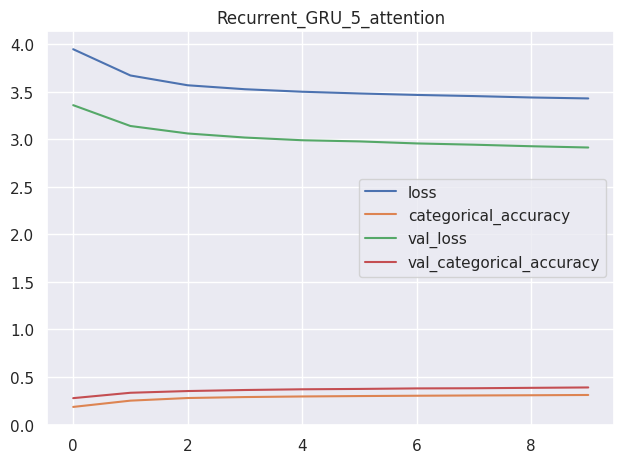

In [19]:
# List of batch sizes for experiments
batch_sizes = [128]
epochs = 10
typeOfAnn = "RNN_GRU_MULTI_HEAD_ATTENTION_COMBINED"

# Specify output file for this set of experiments
for l in [7]:
    # On how many decimal ciphers to round
    PRECISION = 4

    # Parameter K - count of K previous bytes used to predict k + 1 byte
    k = l
    output_file = fr"./logs/{typeOfAnn}_log_k{k}_{megabytes}MB.txt"

    # Number of workers for parallel training in fit methode. Only for train_model_v2()
    #num_of_workers = 1 # This number must divide number of batches with remainder = 0 !!!
    #use_parallel_training = False
    
    # Dictionaries to map bytes to integer values
    alphabet_maps = {
                    "english": {int.to_bytes(i, length=1, byteorder="big"):i for i in range(0, 256)},
                    "dna": 
                        {
                        int.to_bytes(65, length=1, byteorder="big"): 0, 
                        int.to_bytes(67, length=1, byteorder="big"): 1,
                        int.to_bytes(71, length=1, byteorder="big"): 2,
                        int.to_bytes(84, length=1, byteorder="big"): 3,
                        int.to_bytes(78, length=1, byteorder="big"): 4,
                        int.to_bytes(10, length=1, byteorder="big"): 5,
                        int.to_bytes(13, length=1, byteorder="big"): 6,
                        },
                    }
    # Inverse dictionaries to map integer values to bytes
    alphabet_inverse_maps = {
                            "english": {v: k for k, v in alphabet_maps["english"].items()},
                            "dna": {v: k for k, v in alphabet_maps["dna"].items()}
                            }
    # Alphabet sizes
    alphabet_sizes = {"english": len(alphabet_maps["english"].keys()), "dna": len(alphabet_maps["dna"].keys())}
    # Input shapes for ANN
    input_shapes = {"english": (k, alphabet_sizes["english"]), "dna": (k, alphabet_sizes["dna"])}
    # Output shapes for ANN
    output_shapes = {"english": (1, alphabet_sizes["english"]), "dna": (1, alphabet_sizes["dna"])}
    # Set actual alphabet
    actual_alphabet_name = "english"
    actual_alphabet_map = alphabet_maps[actual_alphabet_name]
    actual_inverse_alphabet_map = alphabet_inverse_maps[actual_alphabet_name]
    actual_alphabet_size = alphabet_sizes[actual_alphabet_name]
    actual_input_shape = input_shapes[actual_alphabet_name]
    actual_output_shape = output_shapes[actual_alphabet_name]
    
    # List of all functions to create each reccurent model, V3
    models_creation_function = [create_recurrent_gru_model_5_attention]


    for model_func in models_creation_function:
        #with strategy.scope():
        model = model_func(actual_input_shape, actual_output_shape, actual_alphabet_size)
        for b_s in batch_sizes:
            weight_filepath = f'models/raw_weights/{typeOfAnn}_{model.name}.k{k}.{megabytes}MB.best.hdf5'
            model_filepath = f'models/raw_models/{typeOfAnn}_{model.name}.k{k}.{megabytes}MB'

            # Create file data generators for each dataset
            test_data_generator = DataGeneratorFromFile(test_filename, batch_size=128, k=k, x_alphabet=actual_alphabet_map, y_alphabet=actual_alphabet_map)
            train_data_generator = DataGeneratorFromFile(train_filename, batch_size=b_s, k=k, x_alphabet=actual_alphabet_map, y_alphabet=actual_alphabet_map)
            val_data_generator = DataGeneratorFromFile(validation_filename, batch_size=b_s, k=k, x_alphabet=actual_alphabet_map, y_alphabet=actual_alphabet_map)
            
            experiment_v2(train_data_generator, val_data_generator, test_data_generator, model, weight_filepath, model_filepath, 
                          original_size_in_bits, batch_size=b_s, epochs=epochs, shuffle=True, k=k, output_filename=output_file)

            # Delete all generators, so files will be closed
            test_data_generator.delete()
            train_data_generator.delete()
            val_data_generator.delete()
        del model

## Dataset English texts - Heterogenous learning

In [20]:
train_filepaths_to_merge = [fr"./data/gutenberg/35-0.txt", fr"./data/gutenberg/36-0.txt", fr"./data/gutenberg/41-0.txt", fr"./data/gutenberg/43-0.txt", fr"./data/gutenberg/44-0.txt", fr"./data/gutenberg/45-0.txt"]
#train_filepaths_to_merge = [fr"./data/gutenberg/35-0.txt"]

validation_filepaths_to_merge = [fr"./data/gutenberg/46-0.txt", fr"./data/gutenberg/47-0.txt"]
#validation_filepaths_to_merge = [fr"./data/gutenberg/46-0.txt"]

train_filename = fr"./data/gutenberg/train/train.txt"
validation_filename = fr"./data/gutenberg/val/validation.txt"
test_filename = fr"./data/gutenberg/55-0.txt"

merge_files_binary(train_filepaths_to_merge, train_filename)
merge_files_binary(validation_filepaths_to_merge, validation_filename)

In [21]:
bytes_train = os.stat(train_filename).st_size / 1000
bytes_validation = os.stat(validation_filename).st_size / 1000
bytes_test = os.stat(test_filename).st_size / 1000

print(f"Train: {bytes_train} KB, Test: {bytes_test} KB, Validation: {bytes_validation} KB")
total = bytes_train + bytes_test + bytes_validation
print(f"Train: {np.round(bytes_train / total * 100, 2)} %, Test: {np.round(bytes_test / total * 100, 2)} %, Validation: {np.round(bytes_validation / total * 100, 2)} %")


Train: 2307.388 KB, Test: 237.209 KB, Validation: 713.771 KB
Train: 70.81 %, Test: 7.28 %, Validation: 21.91 %


In [22]:
# Get original size of file in bits
original_size_in_bits = os.stat(test_filename).st_size * 8
original_size_in_bits

1897672

In [23]:
# Get compressed size of file using gzip
# run linux gzip and wc commands to get size of compressed file in bytes
gzip_process = subprocess.Popen(['gzip', '-c', test_filename], stdout=subprocess.PIPE,)
wc_process = subprocess.Popen(['wc', '-c'], stdout=subprocess.PIPE, stdin=gzip_process.stdout,)
output, error = wc_process.communicate()

# Check if commands ran succesfuly
compressed_file_size_in_bits = 0
if error is None:
    compressed_file_size_in_bits = int(output) * 8
    print(f"Size of compressed file using gzip in bits: {compressed_file_size_in_bits} b")
else:
    print(f"Command \"gzip -c {test_filename} | wc -c\" failed with error: {error}")
    
# Print compression rate achieved with using gzip
compressed_bits_per_byte = calculate_bits_per_byte(original_size_in_bits, compressed_file_size_in_bits)
print("Compression ratio: ",calculate_compression_ratio(original_size_in_bits, compressed_file_size_in_bits))
print("Space saving: ", calculate_space_saving(original_size_in_bits, compressed_file_size_in_bits))
print("Bits per Byte: ", compressed_bits_per_byte)

Size of compressed file using gzip in bits: 650152 b
Compression ratio:  2.9188
Space saving:  0.6574
Bits per Byte:  2.7408


Epoch 1/10
18027/18027 [==============================] - 835s 46ms/step - loss: 1.9875 - categorical_accuracy: 0.4346 - val_loss: 1.7268 - val_categorical_accuracy: 0.5126
Epoch 2/10
18027/18027 [==============================] - 854s 47ms/step - loss: 1.4942 - categorical_accuracy: 0.5591 - val_loss: 1.5294 - val_categorical_accuracy: 0.5629
Epoch 3/10
18027/18027 [==============================] - 882s 49ms/step - loss: 1.3672 - categorical_accuracy: 0.5902 - val_loss: 1.4710 - val_categorical_accuracy: 0.5764
Epoch 4/10
18027/18027 [==============================] - 1005s 56ms/step - loss: 1.3121 - categorical_accuracy: 0.6038 - val_loss: 1.4415 - val_categorical_accuracy: 0.5850
Epoch 5/10
18027/18027 [==============================] - 844s 47ms/step - loss: 1.2766 - categorical_accuracy: 0.6124 - val_loss: 1.4378 - val_categorical_accuracy: 0.5874
Epoch 6/10
18027/18027 [==============================] - 848s 47ms/step - loss: 1.2508 - categorical_accuracy: 0.6190 - val_loss: 1.4

INFO:tensorflow:Assets written to: models/raw_models/RNN_LSTM_MULTI_HEAD_ATTENTION_Recurrent_LSTM_5_attention.k7.heterogenous/assets


Making prediction on test data. Batch [99.78 %]
Accuracy: 0.6065


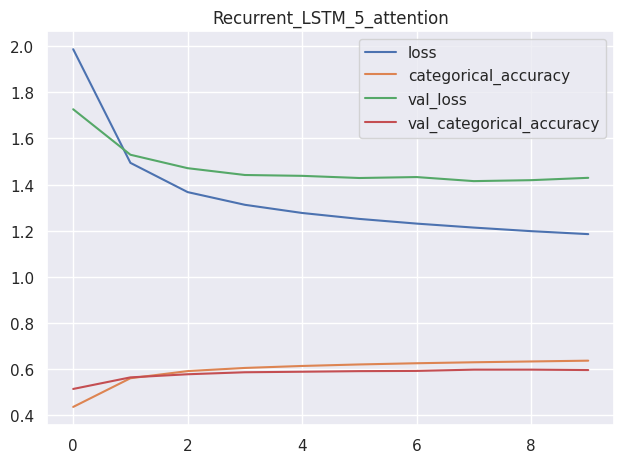

In [25]:
# List of batch sizes for experiments
batch_sizes = [128]
epochs = 10
typeOfAnn = "RNN_LSTM_MULTI_HEAD_ATTENTION"

# Specify output file for this set of experiments
for l in [7]:
    # On how many decimal ciphers to round
    PRECISION = 4

    # Parameter K - count of K previous bytes used to predict k + 1 byte
    k = l
    output_file = fr"./logs/heterogenous/{typeOfAnn}_k{k}.txt"
    
    # Dictionaries to map bytes to integer values
    alphabet_maps = {
                    "english": {int.to_bytes(i, length=1, byteorder="big"):i for i in range(0, 256)},
                    "dna": 
                        {
                        int.to_bytes(65, length=1, byteorder="big"): 0, 
                        int.to_bytes(67, length=1, byteorder="big"): 1,
                        int.to_bytes(71, length=1, byteorder="big"): 2,
                        int.to_bytes(84, length=1, byteorder="big"): 3,
                        int.to_bytes(78, length=1, byteorder="big"): 4,
                        int.to_bytes(10, length=1, byteorder="big"): 5,
                        int.to_bytes(13, length=1, byteorder="big"): 6,
                        },
                    }
    # Inverse dictionaries to map integer values to bytes
    alphabet_inverse_maps = {
                            "english": {v: k for k, v in alphabet_maps["english"].items()},
                            "dna": {v: k for k, v in alphabet_maps["dna"].items()}
                            }
    # Alphabet sizes
    alphabet_sizes = {"english": len(alphabet_maps["english"].keys()), "dna": len(alphabet_maps["dna"].keys())}
    # Input shapes for ANN
    input_shapes = {"english": (k, alphabet_sizes["english"]), "dna": (k, alphabet_sizes["dna"])}
    # Output shapes for ANN
    output_shapes = {"english": (1, alphabet_sizes["english"]), "dna": (1, alphabet_sizes["dna"])}
    # Set actual alphabet
    actual_alphabet_name = "english"
    actual_alphabet_map = alphabet_maps[actual_alphabet_name]
    actual_inverse_alphabet_map = alphabet_inverse_maps[actual_alphabet_name]
    actual_alphabet_size = alphabet_sizes[actual_alphabet_name]
    actual_input_shape = input_shapes[actual_alphabet_name]
    actual_output_shape = output_shapes[actual_alphabet_name]
    
    # List of all functions to create each reccurent model, V3
    models_creation_function = [create_recurrent_lstm_model_5_attention]


    for model_func in models_creation_function:
        #with strategy.scope():
        model = model_func(actual_input_shape, actual_output_shape, actual_alphabet_size)
        #model.load_weights(f"models/raw_weights/RNN_GRU_Attention_Recurrent_GRU_5.k7.heterogenous.best.hdf5")

        for b_s in batch_sizes:
            weight_filepath = f'models/raw_weights/{typeOfAnn}_{model.name}.k{k}.heterogenous.best.hdf5'
            model_filepath = f'models/raw_models/{typeOfAnn}_{model.name}.k{k}.heterogenous'

            # Create file data generators for each dataset
            test_data_generator = DataGeneratorFromFile(test_filename, batch_size=512, k=k, x_alphabet=actual_alphabet_map, y_alphabet=actual_alphabet_map)
            train_data_generator = DataGeneratorFromFile(train_filename, batch_size=b_s, k=k, x_alphabet=actual_alphabet_map, y_alphabet=actual_alphabet_map)
            val_data_generator = DataGeneratorFromFile(validation_filename, batch_size=b_s, k=k, x_alphabet=actual_alphabet_map, y_alphabet=actual_alphabet_map)
            
            experiment_v2(train_data_generator, val_data_generator, test_data_generator, model, weight_filepath, model_filepath, 
                          original_size_in_bits, batch_size=b_s, epochs=epochs, shuffle=True, k=k, output_filename=output_file)

            # Delete all generators, so files will be closed
            test_data_generator.delete()
            train_data_generator.delete()
            val_data_generator.delete()
        del model

In [113]:
model = create_recurrent_lstm_model_5_attention(actual_input_shape, actual_output_shape, actual_alphabet_size)
weight_filepath = f'models/raw_weights/RNN_ATTENTION_Recurrent_LSTM_5_attention.k7.10MB.best.hdf5'

# Load best setup
model.load_weights(weight_filepath)

# Load generator for predictions
test_data_generator = DataGeneratorFromFile(test_filename, batch_size=512, k=k, x_alphabet=actual_alphabet_map, y_alphabet=actual_alphabet_map)

In [115]:
pred = model.predict(test_data_generator)

W0000 00:00:1706889953.787996   14323 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "NVIDIA GeForce GTX 1650" frequency: 1560 num_cores: 16 environment { key: "architecture" value: "7.5" } environment { key: "cuda" value: "12020" } environment { key: "cudnn" value: "8904" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 1048576 shared_memory_size_per_multiprocessor: 65536 memory_size: 2367737038 bandwidth: 128032000 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


464/464 [==============================] - 23s 47ms/step


In [117]:
predicted_entropy = 0
for i, (_, test_batch_y) in enumerate(test_data_generator):
    for b_i, index in enumerate(np.argmax(test_batch_y, axis=-1)): 
        predicted_value = pred[i*512+b_i][0][index]
        #print(f"{index}: {predicted_value}")
        predicted_entropy -= np.log2(np.clip(predicted_value, 1e-10, 1.0))
predicted_entropy

array([364560.88], dtype=float32)

In [114]:
predicted_size_in_bits = 0
# Make predictions on batches
for i_batch, (test_batch_x, test_batch_y) in enumerate(test_data_generator):
    #print(f"Making prediction on test data. Batch [{round(i_batch / len(test_data_generator) * 100, 2)} %]\r", end="")
    
    # Make predictions
    pred_batch_y  = model.predict_on_batch(test_batch_x)

    #batch_entropy = 0
    #for b_i, index in enumerate(np.argmax(test_batch_y, axis=-1)):
        #predicted_value = pred_batch_y[b_i][0][index]
        #print(f"{index}: {predicted_value}")
    #print(pred_batch_y)

    #print(batch_entropy)

    # Calculate accuracy for the batch
    #batch_size = len(test_batch_y)
    #total_samples += batch_size
    #correct_predictions += np.sum(np.argmax(test_batch_y, axis=-1) == np.argmax(pred_batch_y, axis=-1))

    # Calculate entropy for the batch
    batch_entropy = -np.sum(test_batch_y * np.log2(np.clip(pred_batch_y, 1e-10, 1.0)))
    predicted_size_in_bits += batch_entropy
predicted_size_in_bits

W0000 00:00:1706889878.704073   14323 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "NVIDIA GeForce GTX 1650" frequency: 1560 num_cores: 16 environment { key: "architecture" value: "7.5" } environment { key: "cuda" value: "12020" } environment { key: "cudnn" value: "8904" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 1048576 shared_memory_size_per_multiprocessor: 65536 memory_size: 2367737038 bandwidth: 128032000 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }
W0000 00:00:1706889918.081420   14323 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "NVIDIA GeForce GTX 1650" frequency: 1560 num_cores: 16 environment {

364661.8953399658

## Dataset English texts - Homogenous learning
- The data consists of 89 text files that together form a set of books.
- I divided these 89 files in a ratio of 80 : 20 into training and test sets.
- In my experiments i train ANNs on test data. Because I want to use ANNS to calculate **conditional probabilities** of each byte based on *k* previous bytes in input file. And later use these probabilies as an  input to Arithmetical coding algorithm used for data compression
- In these experiments i train and test ANNs on 0.5 MB of english text on gpus.

In [282]:
# define file that we want to compress
megabytes = 1
input_filename = r"./data/English texts/english.1024MB"

test_filename = fr"./data/English texts/english.{megabytes}MB.test"
validation_filename = fr"./data/English texts/english.{megabytes}MB.validation"
train_filename = fr"./data/English texts/english.{megabytes}MB.train"

# specify portion of val data
val_data_portion = 0.2

In [24]:
# Preprocess data and save it to separate files
# Save only part of the data we use
# TEST DATASET
test_size_in_bytes, file_pos = load_and_save(input_filename, test_filename, max_size_in_bytes=megabytes * (10**6), position_in_file=0)
# TRAIN DATASET
train_size_in_bytes, file_pos = load_and_save(input_filename, train_filename, max_size_in_bytes=(megabytes * (10**6)) * (1 - val_data_portion), position_in_file=0)
# VALIDATION DATASET
val_size_in_bytes, file_pos = load_and_save(input_filename, validation_filename, max_size_in_bytes=(megabytes * (10**6)) * val_data_portion, position_in_file=file_pos)

(test_size_in_bytes, train_size_in_bytes, val_size_in_bytes)

Reading from position: 0 1000000 at max bytes.
Loaded bytes [100.0 %]
Reading from position: 0 800000.0 at max bytes.
Loaded bytes [100.0 %]
Reading from position: 0 200000.0 at max bytes.
Loaded bytes [100.0 %]


(1000000, 800000, 200000)

In [107]:
# Get original size of file in bits
original_size_in_bits = os.stat(test_filename).st_size * 8
original_size_in_bits

8000000

In [108]:
# Get compressed size of file using gzip
# run linux gzip and wc commands to get size of compressed file in bytes
gzip_process = subprocess.Popen(['gzip', '-c', test_filename], stdout=subprocess.PIPE,)
wc_process = subprocess.Popen(['wc', '-c'], stdout=subprocess.PIPE, stdin=gzip_process.stdout,)
output, error = wc_process.communicate()

# Check if commands ran succesfuly
compressed_file_size_in_bits = 0
if error is None:
    compressed_file_size_in_bits = int(output) * 8
    print(f"Size of compressed file using gzip in bits: {compressed_file_size_in_bits} b")
else:
    print(f"Command \"gzip -c {test_filename} | wc -c\" failed with error: {error}")
    
# Print compression rate achieved with using gzip
compressed_bits_per_byte = calculate_bits_per_byte(original_size_in_bits, compressed_file_size_in_bits)
print("Compression ratio: ",calculate_compression_ratio(original_size_in_bits, compressed_file_size_in_bits))
print("Space saving: ", calculate_space_saving(original_size_in_bits, compressed_file_size_in_bits))
print("Bits per Byte: ", compressed_bits_per_byte)

Size of compressed file using gzip in bits: 2922360 b
Compression ratio:  2.7375
Space saving:  0.6347
Bits per Byte:  2.9224


### Continuously load data using data generator

In [35]:
# TEST DATASET
test_x, test_y = load_file_binary(test_filename, k)
print(f"Size of test dataset: {(test_x.shape[0] * test_x.shape[1]) / 1000 / 1000 + (test_y.shape[0] * test_y.shape[1]) / 1000 / 1000} MB.")

# TRAIN DATASET
train_x, train_y = load_file_binary(train_filename, k)
print(f"Size of train dataset: {(train_x.shape[0] * train_x.shape[1]) / 1000 / 1000 + (train_y.shape[0] * train_y.shape[1]) / 1000 / 1000} MB.")

# VALIDATION DATASET
val_x, val_y = load_file_binary(validation_filename, k)
print(f"Size of validation dataset: {(val_x.shape[0] * val_x.shape[1]) / 1000 / 1000 + (val_y.shape[0] * val_y.shape[1]) / 1000 / 1000} MB.")

Size of test dataset: 5.0 MB.
Size of train dataset: 4.0 MB.
Size of validation dataset: 1.0 MB.


In [ ]:
# Preprocess all datasets:
datasets = [[test_x, test_y], [train_x, train_y], [val_x, val_y]]
for i in range(0, len(datasets)):
    print(np.round((i+1) / 3 * 100, PRECISION), " %")
    # From bytes to Int in range <0, 255>
    datasets[i][0] = np.array([[actual_alphabet_map[x] for x in sample] for sample in datasets[i][0]])
    datasets[i][1] = np.array([[actual_alphabet_map[y] for y in sample] for sample in datasets[i][1]])

    # From integers to vectors of size 256, one hot encoding
    datasets[i][0] = tf.keras.utils.to_categorical(datasets[i][0], num_classes=256)
    datasets[i][1] = tf.keras.utils.to_categorical(datasets[i][1], num_classes=256)

    # Correct shapes
    datasets[i][0] = datasets[i][0].reshape(-1, k, 256)
    datasets[i][1] = datasets[i][1].reshape(-1, 1, 256)

test_x, test_y = datasets[0]
train_x, train_y = datasets[1]
val_x, val_y = datasets[2]

33.3333  %


In [17]:
# Create a MirroredStrategy.
strategy = tf.distribute.MirroredStrategy()
print('Number of devices: {}'.format(strategy.num_replicas_in_sync))

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')
Number of devices: 2


In [18]:
# List of batch sizes for experiments
batch_sizes = [2048]
epochs = 10
typeOfAnn = "RNN_LSTM"
shuffle = True
output_file = fr"./logs/{typeOfAnn}_log_k{k}_{megabytes}MB.txt"
models_creation_function = [create_recurrent_lstm_model_3, create_recurrent_lstm_model_5, create_recurrent_lstm_model_6]

for model_func in models_creation_function:
    with strategy.scope():
        model = model_func(actual_input_shape, actual_output_shape, actual_alphabet_size)
        
    for b_s in batch_sizes:
        weight_filepath = f'models/raw_weights/{typeOfAnn}_{model.name}.k{k}.{megabytes}MB.best.hdf5'
        model_filepath = f'models/raw_models/{typeOfAnn}_{model.name}.k{k}.{megabytes}MB'

        # Create file data generators for each dataset
        test_data_generator = DataGeneratorForGPU(test_x, test_y, batch_size=16384, )
        train_data_generator = DataGeneratorForGPU(train_x, train_y, batch_size=b_s, )
        val_data_generator = DataGeneratorForGPU(val_x, val_y, batch_size=b_s, )

        experiment_v2(train_data_generator, val_data_generator, test_data_generator, model, weight_filepath, model_filepath, 
                      original_size_in_bits, batch_size=b_s, epochs=epochs, shuffle=shuffle, k=k, output_filename=output_file)


        # Delete all generators, so files will be closed
        del test_data_generator
        del train_data_generator
        del val_data_generator
    del model

INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Redu

CancelledError:  [_Derived_]RecvAsync is cancelled.
	 [[{{node div_no_nan_1/AddN/_50}}]]
	 [[div_no_nan_1/ReadVariableOp_1/_36]] [Op:__inference_train_function_6326]

Function call stack:
train_function


### Load all dataset to memory, CPU

In [28]:
# TEST DATASET
test_x, test_y = load_file_binary(test_filename, k)
print(f"Size of test dataset: {(test_x.shape[0] * test_x.shape[1]) / 1000 / 1000 + (test_y.shape[0] * test_y.shape[1]) / 1000 / 1000} MB.")

# TRAIN DATASET
train_x, train_y = load_file_binary(train_filename, k)
print(f"Size of train dataset: {(train_x.shape[0] * train_x.shape[1]) / 1000 / 1000 + (train_y.shape[0] * train_y.shape[1]) / 1000 / 1000} MB.")

# VALIDATION DATASET
val_x, val_y = load_file_binary(validation_filename, k)
print(f"Size of validation dataset: {(val_x.shape[0] * val_x.shape[1]) / 1000 / 1000 + (val_y.shape[0] * val_y.shape[1]) / 1000 / 1000} MB.")

Size of test dataset: 1.0 MB.
Size of train dataset: 0.7999999999999999 MB.
Size of validation dataset: 0.19999999999999998 MB.


In [29]:
# Preprocess all datasets:
datasets = [[test_x, test_y], [train_x, train_y], [val_x, val_y]]
for i in range(0, len(datasets)):
    print(np.round((i+1) / 3 * 100, PRECISION), " %")
    # From bytes to Int in range <0, 255>
    datasets[i][0] = np.array([[actual_alphabet_map[x] for x in sample] for sample in datasets[i][0]])
    datasets[i][1] = np.array([[actual_alphabet_map[y] for y in sample] for sample in datasets[i][1]])

    # From integers to vectors of size 256, one hot encoding
    datasets[i][0] = tf.keras.utils.to_categorical(datasets[i][0], num_classes=256)
    datasets[i][1] = tf.keras.utils.to_categorical(datasets[i][1], num_classes=256)

    # Correct shapes
    datasets[i][0] = datasets[i][0].reshape(-1, k, 256)
    datasets[i][1] = datasets[i][1].reshape(-1, 1, 256)

test_x, test_y = datasets[0]
train_x, train_y = datasets[1]
val_x, val_y = datasets[2]

33.3333  %
66.6667  %
100.0  %


In [30]:
print(f"Train data: {round(len(train_y) / (len(test_y) + len(train_y) + len(val_y)) * 100, 2) } %")
print(f"Validation data: {round(len(val_y) / (len(test_y) + len(train_y) + len(val_y)) * 100, 2) } %")
print(f"Test data: {round(len(test_y) / (len(test_y) + len(train_y) + len(val_y)) * 100, 2) } %")

Train data: 40.0 %
Validation data: 10.0 %
Test data: 50.0 %


In [33]:
# Size of train, validation and test datasets
print(f"Train set size (X, y): {train_x.shape}, {train_y.shape}")
print(f"Validation set size (X, y): {val_x.shape}, {val_y.shape}")
print(f"Test set size (X, y): {test_x.shape}, {test_y.shape}")

Train set size (X, y): (100000, 7, 256), (100000, 1, 256)
Validation set size (X, y): (25000, 7, 256), (25000, 1, 256)
Test set size (X, y): (125000, 7, 256), (125000, 1, 256)


In [ ]:
model = create_recurrent_lstm_model_3(actual_input_shape, actual_output_shape, actual_alphabet_size)
model.fit(x=train_x, y=train_y, validation_data=(val_x, val_y), epochs=10, shuffle=True, verbose=1, batch_size=512)


Epoch 1/10
100/977 [==>...........................] - ETA: 20:21 - loss: 3.3091 - categorical_accuracy: 0.1667

In [ ]:
model = create_dense_model_v3_3()
model.fit(x=train_x, y=train_y, validation_data=(val_x, val_y), epochs=10, shuffle=True, verbose=1, batch_size=256)


Epoch 1/10
 10/391 [..............................] - ETA: 50:48 - loss: 5.2930 - categorical_accuracy: 0.1262

In [24]:
model = create_dense_model_v3_3()
model.fit(x=train_x, y=train_y, validation_data=(val_x, val_y), epochs=10, shuffle=True, verbose=1, batch_size=256)


Epoch 1/10
171/391 [============>.................] - ETA: 33s - loss: 2.9678 - categorical_accuracy: 0.2497

KeyboardInterrupt: 

In [32]:
# List of batch sizes for experiments
batch_sizes = [2048]
epochs = 10
typeOfAnn = "RNN_LSTM"
shuffle = True
output_file = fr"./logs/{typeOfAnn}_log_k{k}_{megabytes}MB.txt"
models_creation_function = [create_recurrent_lstm_model_3, create_recurrent_lstm_model_5, create_recurrent_lstm_model_6]

for model_func in models_creation_function:
    #with strategy.scope():
    model = model_func(actual_input_shape, actual_output_shape, actual_alphabet_size)
        
    for b_s in batch_sizes:
        weight_filepath = f'models/raw_weights/{typeOfAnn}_{model.name}.k{k}.{megabytes}MB.best.hdf5'
        model_filepath = f'models/raw_models/{typeOfAnn}_{model.name}.k{k}.{megabytes}MB'

        # Create file data generators for each dataset
        #test_data_generator = DataGeneratorFromFile(test_filename, batch_size=16384, k=k, x_alphabet=actual_alphabet_map, y_alphabet=actual_alphabet_map)
        #train_data_generator = DataGeneratorFromFile(train_filename, batch_size=b_s, k=k, x_alphabet=actual_alphabet_map, y_alphabet=actual_alphabet_map)
        #val_data_generator = DataGeneratorFromFile(validation_filename, batch_size=b_s, k=k, x_alphabet=actual_alphabet_map, y_alphabet=actual_alphabet_map)

        #experiment_v2(train_data_generator, val_data_generator, test_data_generator, model, weight_filepath, model_filepath, 
        #              original_size_in_bits, batch_size=b_s, epochs=epochs, shuffle=shuffle, k=k, output_filename=output_file)
        experiment(train_x, train_y, val_x, val_y, test_x, test_y, model, weight_filepath, model_filepath, original_size_in_bits, batch_size=b_s,
                  epochs=epochs, shuffle=shuffle, k=k, output_filename=output_file)

        # Delete all generators, so files will be closed
        #test_data_generator.delete()
        #train_data_generator.delete()
        #val_data_generator.delete()
    del model

Epoch 1/10
49/49 [==============================] - 5s 72ms/step - loss: 3.7056 - categorical_accuracy: 0.1516 - val_loss: 3.1693 - val_categorical_accuracy: 0.1511
Epoch 2/10
49/49 [==============================] - 2s 50ms/step - loss: 3.1695 - categorical_accuracy: 0.1598 - val_loss: 3.1402 - val_categorical_accuracy: 0.1511
Epoch 3/10
21/49 [===========>..................] - ETA: 1s - loss: 3.1369 - categorical_accuracy: 0.1646

KeyboardInterrupt: 

### Small Input Data (<=1MB)

In [132]:
# Load test_x and test_y as bytes from one file
# ANN will train on this test data
test_x, test_y, test_loaded_size = load_data_binary(input_filename, seed=42, lengthOfSubstring=k, portion=1, max_size_in_bytes=megabytes * (10**6))
print(f"\nSize of test dataset: {(test_x.shape[0] * test_x.shape[1]) / 1000 / 1000 + (test_y.shape[0] * test_y.shape[1]) / 1000 / 1000} MB.  [{test_loaded_size / 1000 / 1000} MB]")

Loaded bytes [100.0 %]
Size of test dataset: 80.0 MB.  [1073.741824 MB]


In [19]:
# Load test_x and test_y as bytes from one file
# ANN will train on this test data
test_x, test_y = load_file_binary(test_filename, k)
print(f"Size of test dataset: {(test_x.shape[0] * test_x.shape[1]) / 1000 / 1000 + (test_y.shape[0] * test_y.shape[1]) / 1000 / 1000} MB.")

Size of test dataset: 1.0 MB.


In [133]:
test_x.shape, test_y.shape

((10000000, 7), (10000000, 1))

In [ ]:
# Save only part of the data we use
save_data_binary(test_filename, test_y)

In [134]:
# Get original size of file in bits
original_size_in_bits = os.stat(test_filename).st_size * 8
original_size_in_bits

80000000

In [135]:
# Get alphabet of test file
characters = list(set([y[0] for y in test_y]))
print("Size of alphabet: ", len(characters))

# Calculate frequencies for each symbol of alphabet
frequency_table = { c:0 for c in characters }
for c in test_y:
    frequency_table[c[0]]+= 1
    
# Calculate probabilities for each symbol of alphabet
probability_table = { c:0 for c in characters}
for c, f in frequency_table.items():
    probability_table[c] = f / len(test_y)
# Calculate avg entropy of whole test file for one character    
H = 0
for c, p in probability_table.items():
    if p > 0:
        H -= (p) * np.log2(p)
print("Entropy for a single byte: ", H)

# Calculate entropy of whole file
H = H * len(test_y)
print("Entropy of a whole file: ", H)

# Calculate entropy of whole file
#H = 0
#for c in test_y:
#    H -= 1 * np.log2(probability_table[c[0]])
#H

# Print predicted entropy of file (file size in bits) and original file size [bits]
#print(H, original_size_in_bits)

# Print potential compression rate, i.e. entropy of file
print("Compression ratio: ",calculate_compression_ratio(original_size_in_bits, H))
print("Space saving: ", calculate_space_saving(original_size_in_bits, H))
print("Bits per Byte: ", calculate_bits_per_byte(original_size_in_bits, H))

Size of alphabet:  130
Entropy for a single byte:  4.555134731829269
Entropy of a whole file:  45551347.31829269
Compression ratio:  1.7563
Space saving:  0.4306
Bits per Byte:  4.5552


In [15]:
# Get compressed size of file using gzip
# run linux gzip and wc commands to get size of compressed file in bytes
gzip_process = subprocess.Popen(['gzip', '-c', test_filename], stdout=subprocess.PIPE,)
wc_process = subprocess.Popen(['wc', '-c'], stdout=subprocess.PIPE, stdin=gzip_process.stdout,)
output, error = wc_process.communicate()

# Check if commands ran succesfuly
compressed_file_size_in_bits = 0
if error is None:
    compressed_file_size_in_bits = int(output) * 8
    print(f"Size of compressed file using gzip in bits: {compressed_file_size_in_bits} b")
else:
    print(f"Command \"gzip -c {test_filename} | wc -c\" failed with error: {error}")
    
# Print compression rate achieved with using gzip
compressed_bits_per_byte = calculate_bits_per_byte(original_size_in_bits, compressed_file_size_in_bits)
print("Compression ratio: ",calculate_compression_ratio(original_size_in_bits, compressed_file_size_in_bits))
print("Space saving: ", calculate_space_saving(original_size_in_bits, compressed_file_size_in_bits))
print("Bits per Byte: ", compressed_bits_per_byte)

Size of compressed file using gzip in bits: 2922360 b
Compression ratio:  2.7375
Space saving:  0.6347
Bits per Byte:  2.9224


In [ ]:
# Experiment for k=0
for i in range(0, len(test_x)):
    for j in range(0, k):
        # Generate a random index within the range of valid indices
        random_index = random.randint(1, len(actual_alphabet_map.keys()) - 1)  # Assuming you have 256 options
        value = list(actual_alphabet_map.keys())[random_index]
        
        test_x[i][j] = value
        if test_x[i][j] == b'':
            print(value, random_index)

In [16]:
# Train dataset is same as test dataset
train_x, train_y = copy.deepcopy(test_x), copy.deepcopy(test_y)

In [17]:
# Split train set into - train and validation set
# WITH shuffle
#train_x, val_x, train_y, val_y = train_test_split(train_x, train_y, test_size=0.2, random_state=42, shuffle=True)
# WITHOUT shuffle
train_x, val_x, train_y, val_y = train_test_split(train_x, train_y, test_size=0.2, random_state=42, shuffle=False)

In [18]:
print(f"Train data: {round(len(train_y) / (len(test_y) + len(train_y) + len(val_y)) * 100, 2) } %")
print(f"Validation data: {round(len(val_y) / (len(test_y) + len(train_y) + len(val_y)) * 100, 2) } %")
print(f"Test data: {round(len(test_y) / (len(test_y) + len(train_y) + len(val_y)) * 100, 2) } %")

Train data: 40.0 %
Validation data: 10.0 %
Test data: 50.0 %


In [19]:
# Size of train, validation and test datasets
print(f"Train set size (X, y): {train_x.shape}, {train_y.shape}")
print(f"Validation set size (X, y): {val_x.shape}, {val_y.shape}")
print(f"Test set size (X, y): {test_x.shape}, {test_y.shape}")

Train set size (X, y): (800000, 6), (800000, 1)
Validation set size (X, y): (200000, 6), (200000, 1)
Test set size (X, y): (1000000, 6), (1000000, 1)


In [23]:
# look at data
for i, (x, y) in enumerate(zip(, train_y)):
    if i == 20:
        break
    print(f"{x} -> {y}")

NameError: name 'train_x' is not defined

In [ ]:
models/ of all fucntions to create each model
models_creation_function = [create_dense_model_v2_0, create_dense_model_v2_1, create_dense_model_v2_2, create_dense_model_v2_3, create_dense_model_v2_4,
                            create_dense_model_v2_4_0, create_dense_model_v2_4_1, create_dense_model_v2_4_2, create_dense_model_v2_5, create_dense_model_v2_6,
                            create_dense_model_v2_7, create_dense_model_v2_8, create_dense_model_v2_9, create_dense_model_v2_10, create_dense_model_v2_11]


In [24]:
models_creation_function = [create_recurrent_gru_model_0, create_recurrent_gru_model_1, create_recurrent_gru_model_2, create_recurrent_gru_model_3,
                           ]

In [ ]:
# List of batch sizes for experiments
batch_sizes = [512]
epochs = 10
output_file = fr"./logs/log_k{k}_{megabytes}MB.txt"
typeOfAnn = "RNN"

for model_func in models_creation_function:
    model = model_func()
    for b_s in batch_sizes:
        weight_filepath = f'models/raw_weights/{typeOfAnn}_{model.name}.k{k}.{megabytes}MB.best.hdf5'
        model_filepath = f'models/raw_models/{typeOfAnn}_{model.name}.k{k}.{megabytes}MB'

        experiment(train_x, train_y, val_x, val_y, test_x, test_y, model, weight_filepath, model_filepath, original_size_in_bits, batch_size=b_s,
                  epochs=epochs, shuffle=True, k=k, output_filename=output_file)
    del model

Epoch 1/10
1563/1563 [==============================] - ETA: 0s - loss: 3.2923 - categorical_accuracy: 0.1515

### Big Input Data (>1MB)

In [77]:
# Save only part of the data we use
# Test data
test_size_in_bytes, file_pos = load_and_save(input_filename, test_filename, max_size_in_bytes=megabytes * (10**6), position_in_file=0)
# Train data
train_size_in_bytes, file_pos = load_and_save(input_filename, train_filename, max_size_in_bytes=(megabytes * (10**6)) * (1 - val_data_portion), position_in_file=0)
# Validation data
val_size_in_bytes, file_pos = load_and_save(input_filename, validation_filename, max_size_in_bytes=(megabytes * (10**6)) * val_data_portion, position_in_file=file_pos)

Reading from position: 0 1000000 at max bytes.
Loaded bytes [100.0 %]
Reading from position: 0 800000.0 at max bytes.
Loaded bytes [100.0 %]
Reading from position: 0 200000.0 at max bytes.
Loaded bytes [100.0 %]


In [283]:
# Get original size of file in bits
original_size_in_bits = os.stat(test_filename).st_size * 8
original_size_in_bits

8000000

In [284]:
# run linux gzip and wc commands to get size of compressed file in bytes
gzip_process = subprocess.Popen(['gzip', '-c', test_filename], stdout=subprocess.PIPE,)
wc_process = subprocess.Popen(['wc', '-c'], stdout=subprocess.PIPE, stdin=gzip_process.stdout,)
output, error = wc_process.communicate()

# Check if commands ran succesfuly
compressed_file_size_in_bits = 0
if error is None:
    compressed_file_size_in_bits = int(output) * 8
    print(f"Size of compressed file using gzip in bits: {compressed_file_size_in_bits} b")
else:
    print(f"Command \"gzip -c {test_filename_part} | wc -c\" failed with error: {error}")
    
# Print compression rate achieved with using gzip
compressed_bits_per_byte = calculate_bits_per_byte(original_size_in_bits, compressed_file_size_in_bits)
print("Compression ratio: ",calculate_compression_ratio(original_size_in_bits, compressed_file_size_in_bits))
print("Space saving: ", calculate_space_saving(original_size_in_bits, compressed_file_size_in_bits))
print("Bits per Byte: ", compressed_bits_per_byte)

Size of compressed file using gzip in bits: 2922360 b
Compression ratio:  2.7375
Space saving:  0.6347
Bits per Byte:  2.9224


In [19]:
# Create a MirroredStrategy.
strategy = tf.distribute.MirroredStrategy()
print('Number of devices: {}'.format(strategy.num_replicas_in_sync))

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')
Number of devices: 2


Epoch 1/10
3907/3907 [==============================] - 351s 89ms/step - loss: 2.7712 - categorical_accuracy: 0.2589 - val_loss: 2.3904 - val_categorical_accuracy: 0.3362
Epoch 2/10
3907/3907 [==============================] - 389s 100ms/step - loss: 2.2257 - categorical_accuracy: 0.3766 - val_loss: 2.1990 - val_categorical_accuracy: 0.3893
Epoch 3/10
3907/3907 [==============================] - 421s 108ms/step - loss: 2.0986 - categorical_accuracy: 0.4106 - val_loss: 2.1006 - val_categorical_accuracy: 0.4139
Epoch 4/10
3907/3907 [==============================] - 555s 142ms/step - loss: 2.0268 - categorical_accuracy: 0.4274 - val_loss: 2.0378 - val_categorical_accuracy: 0.4266
Epoch 5/10
3907/3907 [==============================] - 670s 171ms/step - loss: 1.9785 - categorical_accuracy: 0.4385 - val_loss: 1.9919 - val_categorical_accuracy: 0.4405
Epoch 6/10
3907/3907 [==============================] - 637s 163ms/step - loss: 1.9409 - categorical_accuracy: 0.4488 - val_loss: 1.9393 - va

INFO:tensorflow:Assets written to: models/raw_models/RNN_LSTM_Recurrent_LSTM_1.k4.5MB/assets


Making prediction on test data. Batch [99.67 %]
Accuracy: 0.4734
Epoch 1/10
3907/3907 [==============================] - 1054s 267ms/step - loss: 2.5637 - categorical_accuracy: 0.3035 - val_loss: 2.1957 - val_categorical_accuracy: 0.3856
Epoch 2/10
3907/3907 [==============================] - 986s 252ms/step - loss: 2.0227 - categorical_accuracy: 0.4263 - val_loss: 1.9602 - val_categorical_accuracy: 0.4419
Epoch 3/10
3907/3907 [==============================] - 1252s 320ms/step - loss: 1.8900 - categorical_accuracy: 0.4610 - val_loss: 1.8536 - val_categorical_accuracy: 0.4780
Epoch 4/10
3907/3907 [==============================] - 592s 151ms/step - loss: 1.8200 - categorical_accuracy: 0.4785 - val_loss: 1.7925 - val_categorical_accuracy: 0.4913
Epoch 5/10
3907/3907 [==============================] - 795s 204ms/step - loss: 1.7736 - categorical_accuracy: 0.4898 - val_loss: 1.7442 - val_categorical_accuracy: 0.5056
Epoch 6/10
3907/3907 [==============================] - 1014s 259ms/step 

INFO:tensorflow:Assets written to: models/raw_models/RNN_LSTM_Recurrent_LSTM_2.k4.5MB/assets


Making prediction on test data. Batch [99.67 %]
Accuracy: 0.5172
Epoch 1/10
3907/3907 [==============================] - 393s 100ms/step - loss: 2.3105 - categorical_accuracy: 0.3616 - val_loss: 2.0190 - val_categorical_accuracy: 0.4297
Epoch 2/10
3907/3907 [==============================] - 371s 95ms/step - loss: 1.8745 - categorical_accuracy: 0.4637 - val_loss: 1.7767 - val_categorical_accuracy: 0.4935
Epoch 3/10
3907/3907 [==============================] - 387s 99ms/step - loss: 1.7426 - categorical_accuracy: 0.4967 - val_loss: 1.6590 - val_categorical_accuracy: 0.5249
Epoch 4/10
3907/3907 [==============================] - 390s 100ms/step - loss: 1.6746 - categorical_accuracy: 0.5130 - val_loss: 1.6120 - val_categorical_accuracy: 0.5359
Epoch 5/10
3907/3907 [==============================] - 374s 96ms/step - loss: 1.6329 - categorical_accuracy: 0.5223 - val_loss: 1.5665 - val_categorical_accuracy: 0.5454
Epoch 6/10
3907/3907 [==============================] - 383s 98ms/step - loss:

INFO:tensorflow:Assets written to: models/raw_models/RNN_LSTM_Recurrent_LSTM_3.k4.5MB/assets


Making prediction on test data. Batch [99.67 %]
Accuracy: 0.5401
Epoch 1/10
3907/3907 [==============================] - 332s 84ms/step - loss: 2.2982 - categorical_accuracy: 0.3641 - val_loss: 1.8887 - val_categorical_accuracy: 0.4640
Epoch 2/10
3907/3907 [==============================] - 330s 84ms/step - loss: 1.7642 - categorical_accuracy: 0.4905 - val_loss: 1.6490 - val_categorical_accuracy: 0.5280
Epoch 3/10
3907/3907 [==============================] - 330s 84ms/step - loss: 1.6453 - categorical_accuracy: 0.5184 - val_loss: 1.5459 - val_categorical_accuracy: 0.5501
Epoch 4/10
3907/3907 [==============================] - 330s 84ms/step - loss: 1.5917 - categorical_accuracy: 0.5298 - val_loss: 1.5137 - val_categorical_accuracy: 0.5549
Epoch 5/10
3907/3907 [==============================] - 338s 86ms/step - loss: 1.5597 - categorical_accuracy: 0.5362 - val_loss: 1.4962 - val_categorical_accuracy: 0.5588
Epoch 6/10
3907/3907 [==============================] - 330s 85ms/step - loss: 1

INFO:tensorflow:Assets written to: models/raw_models/RNN_LSTM_Recurrent_LSTM_5.k4.5MB/assets


Making prediction on test data. Batch [99.67 %]
Accuracy: 0.5482
Epoch 1/10
3907/3907 [==============================] - 349s 88ms/step - loss: 2.4630 - categorical_accuracy: 0.3247 - val_loss: 1.9806 - val_categorical_accuracy: 0.4425
Epoch 2/10
3907/3907 [==============================] - 356s 91ms/step - loss: 1.8081 - categorical_accuracy: 0.4796 - val_loss: 1.6640 - val_categorical_accuracy: 0.5256
Epoch 3/10
3907/3907 [==============================] - 352s 90ms/step - loss: 1.6508 - categorical_accuracy: 0.5173 - val_loss: 1.5692 - val_categorical_accuracy: 0.5457
Epoch 4/10
3907/3907 [==============================] - 343s 88ms/step - loss: 1.5878 - categorical_accuracy: 0.5307 - val_loss: 1.5218 - val_categorical_accuracy: 0.5527
Epoch 5/10
3907/3907 [==============================] - 338s 87ms/step - loss: 1.5538 - categorical_accuracy: 0.5372 - val_loss: 1.4813 - val_categorical_accuracy: 0.5628
Epoch 6/10
3907/3907 [==============================] - 336s 86ms/step - loss: 1

INFO:tensorflow:Assets written to: models/raw_models/RNN_LSTM_Recurrent_LSTM_6.k4.5MB/assets


Making prediction on test data. Batch [99.67 %]
Accuracy: 0.5496


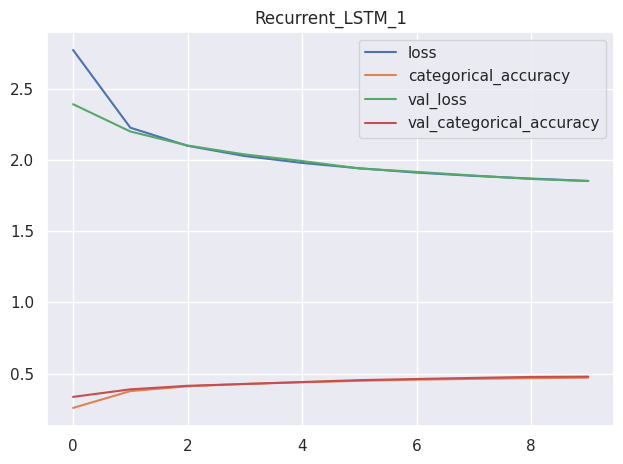

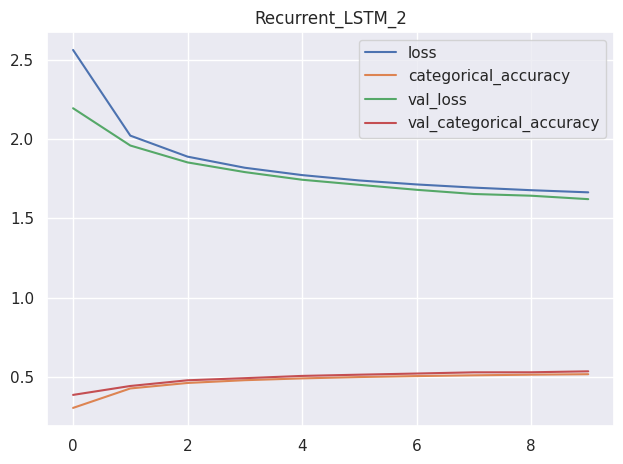

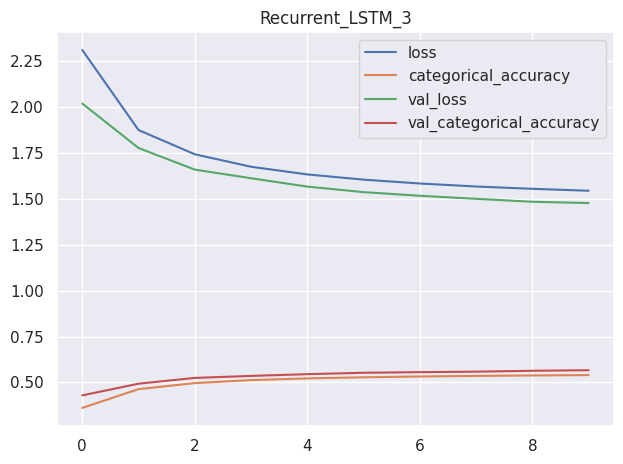

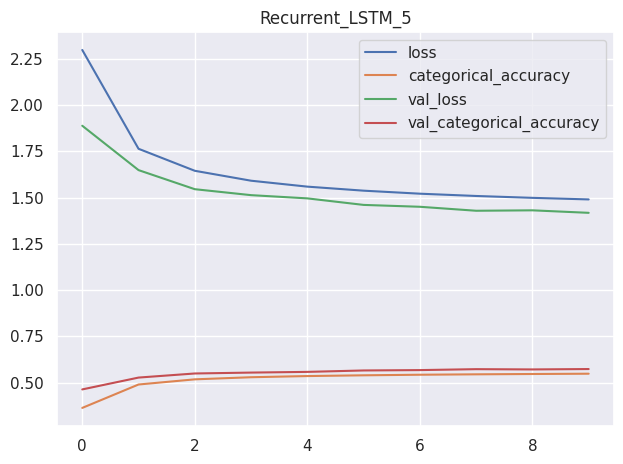

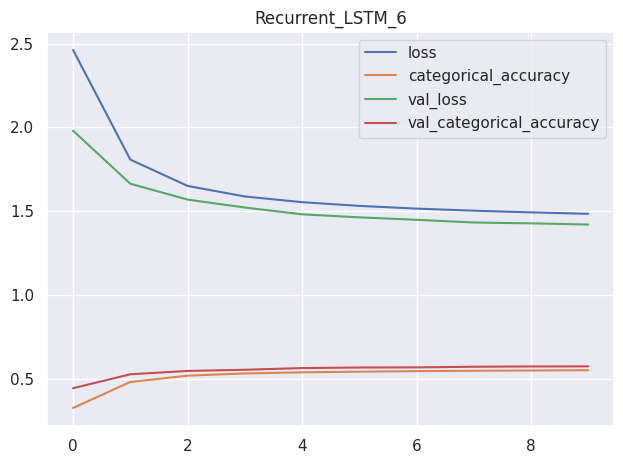

In [46]:
# List of batch sizes for experiments
batch_sizes = [128]
epochs = 10
typeOfAnn = "RNN_LSTM_MULTI_HEAD_ATTENTION"
shuffle = True
output_file = fr"./logs/{typeOfAnn}_log_k{k}_{megabytes}MB.txt"

for model_func in models_creation_function:
    #with strategy.scope():
    model = model_func(actual_input_shape, actual_output_shape, actual_alphabet_size)
        
    for b_s in batch_sizes:
        weight_filepath = f'models/raw_weights/{typeOfAnn}_{model.name}.k{k}.{megabytes}MB.best.hdf5'
        model_filepath = f'models/raw_models/{typeOfAnn}_{model.name}.k{k}.{megabytes}MB'

        # Create file data generators for each dataset
        test_data_generator = DataGeneratorFromFile(test_filename, batch_size=16384, k=k, x_alphabet=actual_alphabet_map, y_alphabet=actual_alphabet_map)
        train_data_generator = DataGeneratorFromFile(train_filename, batch_size=b_s, k=k, x_alphabet=actual_alphabet_map, y_alphabet=actual_alphabet_map)
        val_data_generator = DataGeneratorFromFile(validation_filename, batch_size=b_s, k=k, x_alphabet=actual_alphabet_map, y_alphabet=actual_alphabet_map)

        experiment_v2(train_data_generator, val_data_generator, test_data_generator, model, weight_filepath, model_filepath, 
                      original_size_in_bits, batch_size=b_s, epochs=epochs, shuffle=shuffle, k=k, output_filename=output_file)

        # Delete all generators, so files will be closed
        test_data_generator.delete()
        train_data_generator.delete()
        val_data_generator.delete()
    del model

Epoch 1/10
6250/6250 [==============================] - 236s 37ms/step - loss: 2.2074 - categorical_accuracy: 0.3920 - val_loss: 1.8217 - val_categorical_accuracy: 0.4888
Epoch 2/10
6250/6250 [==============================] - 292s 47ms/step - loss: 1.4028 - categorical_accuracy: 0.6007 - val_loss: 1.3193 - val_categorical_accuracy: 0.6188
Epoch 4/10
6250/6250 [==============================] - 284s 45ms/step - loss: 1.2318 - categorical_accuracy: 0.6425 - val_loss: 1.1875 - val_categorical_accuracy: 0.6511
Epoch 7/10
6250/6250 [==============================] - 288s 46ms/step - loss: 1.2047 - categorical_accuracy: 0.6483 - val_loss: 1.1600 - val_categorical_accuracy: 0.6597
Epoch 8/10
6250/6250 [==============================] - 272s 43ms/step - loss: 1.1641 - categorical_accuracy: 0.6585 - val_loss: 1.1273 - val_categorical_accuracy: 0.6652
Epoch 10/10
6250/6250 [==============================] - 272s 44ms/step - loss: 1.1471 - categorical_accuracy: 0.6625 - val_loss: 1.1085 - val_ca

INFO:tensorflow:Assets written to: models/raw_models/RNN_GRU_MULTI_HEAD_ATTENTION_Recurrent_GRU_5_attention.k7.1MB/assets


Making prediction on test data. Batch [99.99 %]
Accuracy: 0.6395


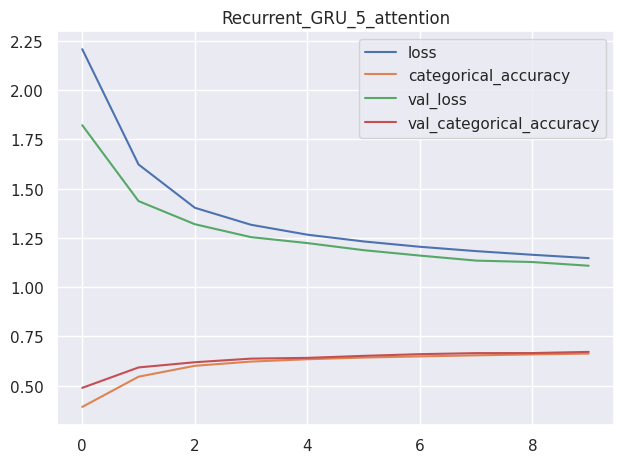

In [286]:
# List of batch sizes for experiments
batch_sizes = [128]
epochs = 10
typeOfAnn = "RNN_GRU_MULTI_HEAD_ATTENTION"

# Specify output file for this set of experiments
for l in [7]:
    # On how many decimal ciphers to round
    PRECISION = 4

    # Parameter K - count of K previous bytes used to predict k + 1 byte
    k = l
    output_file = fr"./logs/{typeOfAnn}_log_k{k}_{megabytes}MB.txt"

    # Number of workers for parallel training in fit methode. Only for train_model_v2()
    #num_of_workers = 1 # This number must divide number of batches with remainder = 0 !!!
    #use_parallel_training = False
    
    # Dictionaries to map bytes to integer values
    alphabet_maps = {
                    "english": {int.to_bytes(i, length=1, byteorder="big"):i for i in range(0, 256)},
                    "dna": 
                        {
                        int.to_bytes(65, length=1, byteorder="big"): 0, 
                        int.to_bytes(67, length=1, byteorder="big"): 1,
                        int.to_bytes(71, length=1, byteorder="big"): 2,
                        int.to_bytes(84, length=1, byteorder="big"): 3,
                        int.to_bytes(78, length=1, byteorder="big"): 4,
                        int.to_bytes(10, length=1, byteorder="big"): 5,
                        int.to_bytes(13, length=1, byteorder="big"): 6,
                        },
                    }
    # Inverse dictionaries to map integer values to bytes
    alphabet_inverse_maps = {
                            "english": {v: k for k, v in alphabet_maps["english"].items()},
                            "dna": {v: k for k, v in alphabet_maps["dna"].items()}
                            }
    # Alphabet sizes
    alphabet_sizes = {"english": len(alphabet_maps["english"].keys()), "dna": len(alphabet_maps["dna"].keys())}
    # Input shapes for ANN
    input_shapes = {"english": (k, alphabet_sizes["english"]), "dna": (k, alphabet_sizes["dna"])}
    # Output shapes for ANN
    output_shapes = {"english": (1, alphabet_sizes["english"]), "dna": (1, alphabet_sizes["dna"])}
    # Set actual alphabet
    actual_alphabet_name = "english"
    actual_alphabet_map = alphabet_maps[actual_alphabet_name]
    actual_inverse_alphabet_map = alphabet_inverse_maps[actual_alphabet_name]
    actual_alphabet_size = alphabet_sizes[actual_alphabet_name]
    actual_input_shape = input_shapes[actual_alphabet_name]
    actual_output_shape = output_shapes[actual_alphabet_name]
    
    # List of all functions to create each reccurent model, V3
    models_creation_function = [create_recurrent_gru_model_5_attention]


    for model_func in models_creation_function:
        #with strategy.scope():
        model = model_func(actual_input_shape, actual_output_shape, actual_alphabet_size)
        for b_s in batch_sizes:
            weight_filepath = f'models/raw_weights/{typeOfAnn}_{model.name}.k{k}.{megabytes}MB.best.hdf5'
            model_filepath = f'models/raw_models/{typeOfAnn}_{model.name}.k{k}.{megabytes}MB'

            # Create file data generators for each dataset
            test_data_generator = DataGeneratorFromFile(test_filename, batch_size=128, k=k, x_alphabet=actual_alphabet_map, y_alphabet=actual_alphabet_map)
            train_data_generator = DataGeneratorFromFile(train_filename, batch_size=b_s, k=k, x_alphabet=actual_alphabet_map, y_alphabet=actual_alphabet_map)
            val_data_generator = DataGeneratorFromFile(validation_filename, batch_size=b_s, k=k, x_alphabet=actual_alphabet_map, y_alphabet=actual_alphabet_map)
            
            experiment_v2(train_data_generator, val_data_generator, test_data_generator, model, weight_filepath, model_filepath, 
                          original_size_in_bits, batch_size=b_s, epochs=epochs, shuffle=True, k=k, output_filename=output_file)

            # Delete all generators, so files will be closed
            test_data_generator.delete()
            train_data_generator.delete()
            val_data_generator.delete()
        del model

In [252]:
128 * 2 * 2 * 2 * 2 *2 * 2

8192

### Visualisation of theoretical capacit of ANN

#### Visualisation functions

In [14]:
def repair(filename: str):
    # open log
    columns = ["Timestamp", "ModelName", "k", "Epochs", "BatchSize", "OptimizerName", "Shuffle", "MaxTrainValidationTestAccuracy", "MinLoss",
               "CompressionRatio", "SpaceSaving", "BitsPerByte[b]", "InputFileSize[b]", "OutputFileSize[b]", "ModelSize[B]"]
    
    df = pd.read_csv(filepath_or_buffer=filename, sep=";", header=None, names=columns)
    df["BitsPerByte[b]"] = df["BitsPerByte[b]"] * 8
    df.to_csv(filename, sep=";", header=None, index=False)

In [15]:
def load_results(filename_list: [str]):
    # open log
    columns = ["Timestamp", "ModelName", "k", "Epochs", "BatchSize", "OptimizerName", "Shuffle", "MaxTrainValidationTestAccuracy", "MinLoss",
               "CompressionRatio", "SpaceSaving", "BitsPerByte[b]", "InputFileSize[b]", "OutputFileSize[b]", "ModelSize[B]"]
    
    df = pd.concat((pd.read_csv(filepath_or_buffer=f, sep=";", header=None, names=columns) for f in filename_list), ignore_index=True)
    df["BitsPerByteAll[b]"] = df.apply(axis=1, func=lambda x: calculate_bits_per_byte(float(x["InputFileSize[b]"]), float(x["OutputFileSize[b]"]) + float((x["ModelSize[B]"] * 8)))) 
    return df

In [281]:
def plot_capacity_of_ann_only_model_size(df: pd.DataFrame, input_file_size_in_bits: int, gzip_bits_per_byte: float, sevenzip_bits_per_byte: float, entropy_of_file: float = None, loc: string = "best"):    
    # Define colors for each value of parameter K
    hue_colors = sns.color_palette("Set1", n_colors=len(df.k.unique()))
    # Create figure
    fig, ax1 = plt.subplots(1, 1, figsize=(16,6),)
    # Set labels and title of figure
    ax1.set_xlabel('Size of ANN [B]')
    ax1.set_ylabel('Predicted bits per byte [b] [compressed file]')
    ax1.set_title('Capacity of ANN (Dense models)')
    # Create scatter plot for each "K"
    for i, k in enumerate(df["k"].unique()):
        df_k = df.loc[df["k"] == k]
        line1 = plt.scatter(x=df_k["ModelSize[B]"], y=df_k["BitsPerByte[b]"], color=hue_colors[i], label=f"K={k}")
    # Create vertical line which bounds the graph from right as size of input file
    line2 = ax1.axvline(x=input_file_size_in_bits / 8, color="red", linestyle="--", label="Size of input file[B]")

    # If set. Then create horizontal line which shows the entropy of the input file
    if entropy_of_file is not None:
        line3 = ax1.axhline(y=entropy_of_file, color="green", linestyle="--", label="Entropy of input file[b]")
    # Create horizontal line which shows bits-per-byte of gzip
    line4 = ax1.axhline(y=gzip_bits_per_byte, color="orange", linestyle="-", label="Bits-per-byte of gzip tool[b]")
    # Create horizontal line which shows bits-per-byte of 7z PPM
    line5 = ax1.axhline(y=sevenzip_bits_per_byte, color="orange", linestyle="--", label="Bits-per-byte of 7z PPM algorithm[b]")

    # Make visible area of optimal solution
    # Width and height of the rectangle
    width, height = input_file_size_in_bits / 8, gzip_bits_per_byte     
    # Define the x and y coordinates for the green region
    x_region = [0, width, width, 0]
    y_region = [0, 0,     height, height] 
    
    # Fill the region with green color
    ax1.fill(x_region, y_region, 'green', alpha=0.1)

    #ax1.set_ylim(0.2, None)
    ax1.set_xlim(0, None)
    
    # Set X axis formater to show the value in KB
    ax1.xaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, y: f"{int(x) / 1000} KB"))
    ax1.grid(True)

    # Loop through the data and add text labels with corresponding colors
    for i, point in df.iterrows():
        color = hue_colors[df['k'].unique().tolist().index(point["k"])]
        ax1.text((point['ModelSize[B]'])+.02, point['BitsPerByte[b]'], str("_".join((point['ModelName']).split("_")[2:])), color=color)
        
    plt.legend(title="Legend", loc=loc)

In [251]:
def plot_capacity_of_ann(df: pd.DataFrame, input_file_size_in_bits: int, gzip_bits_per_byte: float, sevenzip_bits_per_byte: float,
                        entropy_of_file: float = None):
    fig, ax1 = plt.subplots(1, 1, figsize=(16,6),)
    
    # For each parameter k create color
    hue_colors = sns.color_palette("Set1", n_colors=len(df.k.unique()))
    ax1 = sns.scatterplot(x=df["ModelSize[B]"] + (df["OutputFileSize[b]"] / 8), y=df["BitsPerByte[b]"], hue=df["k"], palette=hue_colors, ax=ax1,)

    ax1.set_xlabel('Size of ANN [B] + Predicted size of compressed input file [B]')
    ax1.set_ylabel('Predicted bits per byte [b] [compressed file]')
    ax1.set_title('Capacity of ANN (Dense models)')
    ax1.axvline(x=input_file_size_in_bits / 8, color="red", linestyle="--", label="Size of input file[B]")
    if entropy_of_file is not None:
        ax1.axhline(y=entropy_of_file, color="green", linestyle="--", label="Entropy of input file [b]")
    ax1.axhline(y=gzip_bits_per_byte, color="orange", linestyle="-", label="Bits per Byte of gzip tool [b]")
    ax1.axhline(y=sevenzip_bits_per_byte, color="orange", linestyle="--", label="Bits per Byte of 7z ppmd tool [b]")

    
    # Make visible area of optimal solution
    # Width and height of the rectangle
    width, height = input_file_size_in_bits / 8, gzip_bits_per_byte     
    # Define the x and y coordinates for the green region
    x_region = [0, width, width, 0]
    y_region = [0, 0,     height, height] 
    
    # Fill the region with green color
    ax1.fill(x_region, y_region, 'green', alpha=0.1)

    #ax1.set_ylim(0.2, None)
    ax1.set_xlim(0, None)
    
    # Set X axis formater to show the value in KB
    ax1.xaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, y: f"{int(x) / 1000} KB"))
    ax1.grid(True)

    # Loop through the data and add text labels with corresponding colors
    for i, point in df.iterrows():
        color = hue_colors[df['k'].unique().tolist().index(point["k"])]
        ax1.text((point['ModelSize[B]'] + (point["OutputFileSize[b]"] / 8))+.02, point['BitsPerByte[b]'], str("_".join((point['ModelName']).split("_")[2:])), color=color)

    plt.legend(title="Legend", loc="upper right")

In [252]:
def plot_capacity_of_ann_y_all(df: pd.DataFrame, input_file_size_in_bits: int, gzip_bits_per_byte: float, sevenzip_bits_per_byte: float,
                        entropy_of_file: float = None):
    fig, ax1 = plt.subplots(1, 1, figsize=(16,6),)
    
    # For each parameter k create color
    hue_colors = sns.color_palette("Set1", n_colors=len(df.k.unique()))
    ax1 = sns.scatterplot(x=df["ModelSize[B]"], y=df["BitsPerByteAll[b]"], hue=df["k"], palette=hue_colors, ax=ax1,)

    ax1.set_xlabel('Size of ANN [B]')
    ax1.set_ylabel('Predicted bits per byte [b] [compressed file + ann]')
    ax1.set_title('Capacity of ANN (Dense models)')
    ax1.axvline(x=input_file_size_in_bits / 8, color="red", linestyle="--", label="Size of input file[B]")
    if entropy_of_file is not None:
        ax1.axhline(y=entropy_of_file, color="green", linestyle="--", label="Entropy of input file [b]")
    ax1.axhline(y=gzip_bits_per_byte, color="orange", linestyle="-", label="Bits per Byte of gzip tool [b]")
    ax1.axhline(y=sevenzip_bits_per_byte, color="orange", linestyle="--", label="Bits per Byte of 7z ppmd tool [b]")

    # Make visible area of optimal solution
    # Width and height of the rectangle
    width, height = input_file_size_in_bits / 8, gzip_bits_per_byte     
    # Define the x and y coordinates for the green region
    x_region = [0, width, width, 0]
    y_region = [0, 0,     height, height] 
    
    # Fill the region with green color
    ax1.fill(x_region, y_region, 'green', alpha=0.1)

    #ax1.set_ylim(0.2, None)
    ax1.set_xlim(0, None)
    
    # Set X axis formater to show the value in KB
    ax1.xaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, y: f"{int(x) / 1000} KB"))
    ax1.grid(True)

    # Loop through the data and add text labels with corresponding colors
    for i, point in df.iterrows():
        color = hue_colors[df['k'].unique().tolist().index(point["k"])]
        ax1.text((point['ModelSize[B]'])+.02, point['BitsPerByteAll[b]'], str("_".join((point['ModelName']).split("_")[2:])), color=color)

    plt.legend(title="Legend", loc="upper right")

#### Statistics

In [16]:
def load_all_results(k_values, size_values, type_values, additional_filenames = [], path_to_folder = "logs") -> pd.DataFrame:
    filenames = [] + additional_filenames
    # for each value of parameter K
    for k in k_values:
        # for each size in MB
        if len(size_values) > 0:
            for size in size_values:
                # for each type of ANN
                for type in type_values:
                    # Construct filename
                    filename = rf"{path_to_folder}/{type}_log_k{k}_{size}MB.txt"
                    filenames.append(filename)
        else:
            # for each type of ANN
            for type in type_values:
                # Construct filename
                filename = rf"{path_to_folder}/{type}_k{k}.txt"
                filenames.append(filename)
    # Load results
    df_all = load_results(filenames)
    # Parse out model type
    def parse_model_type(item):
        split = item.split("_")
        if split[0] == "Recurrent":
            if split[-1] == "attention":
                return f"{split[1]}_attention"
            else:
                return split[1]
        else:
            return "_".join(split[0:2])
    df_all["ModelType"] = df_all["ModelName"].apply(parse_model_type)
    
    return df_all

In [17]:
# Set color palette for each type of models.
hue_colors = {"LSTM": sns.color_palette(palette="Reds")[4],
              "LSTM_attention": sns.color_palette(palette="Reds")[2], 
              "GRU": sns.color_palette(palette="Blues")[5],
              "GRU_attention": sns.color_palette(palette="Blues")[2],
              "Dense_v2": sns.color_palette(palette="Greens")[2],
              "Dense_v3": sns.color_palette(palette="Greens")[5]}


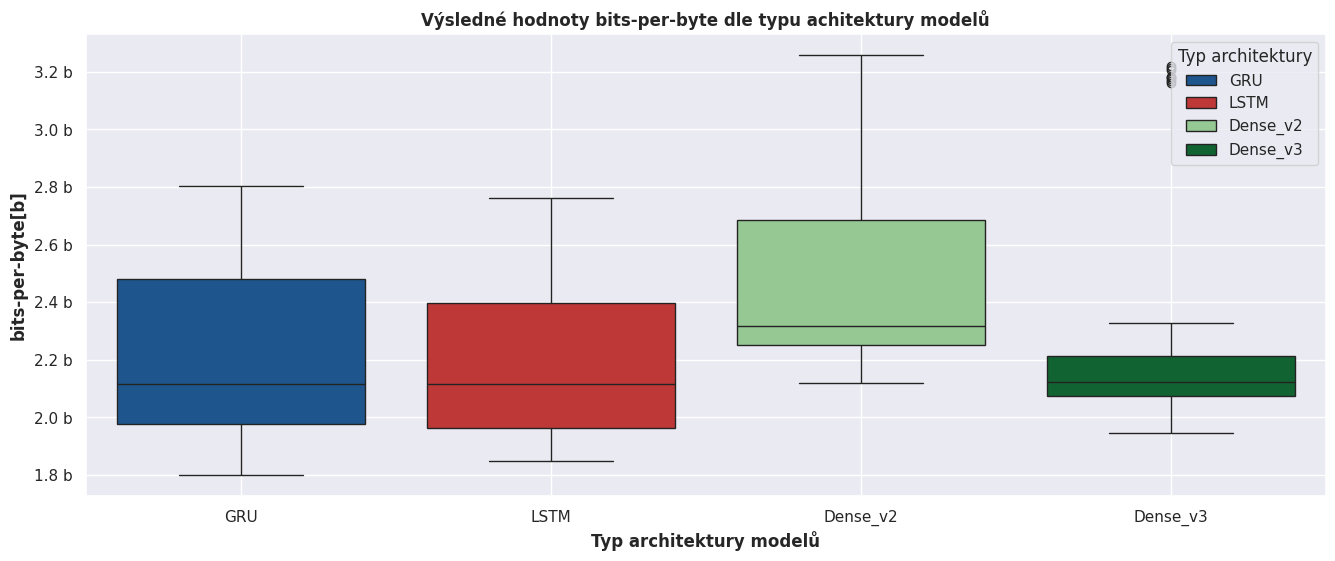

In [149]:
k_values = [4, 5, 6, 7]
size_values = [1, 5, 10]
type_values = ["RNN_GRU", "RNN_LSTM", "DNN"]
# Load results of experiments
df = load_all_results(k_values, size_values, type_values)
# Create figure
fig, ax1 = plt.subplots(1, 1, figsize=(16,6),)
# Set labels and title of figure
ax1.set_xlabel('Typ architektury modelů', fontweight='bold')
ax1.set_ylabel('bits-per-byte[b]', fontweight='bold')
ax1.set_title('Výsledné hodnoty bits-per-byte dle typu achitektury modelů', fontweight='bold')
# Create boxplots with hue parameter using Seaborn
sns.boxplot(x='ModelType', y='BitsPerByte[b]', hue='ModelType', data=df, ax=ax1, legend=True, palette=hue_colors)
# Set X axis formater to show the value in KB
ax1.yaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, _: f"{np.round(x, 1)} b"))
ax1.grid(True)
# Draw legend
ax1.legend(title="Typ architektury")
# Save the plot as a PDF file
plt.savefig('images/avgBpBForDifferentArchitectures.pdf', format='pdf', bbox_inches='tight')
# Show the plot
plt.show()

(245, 17)


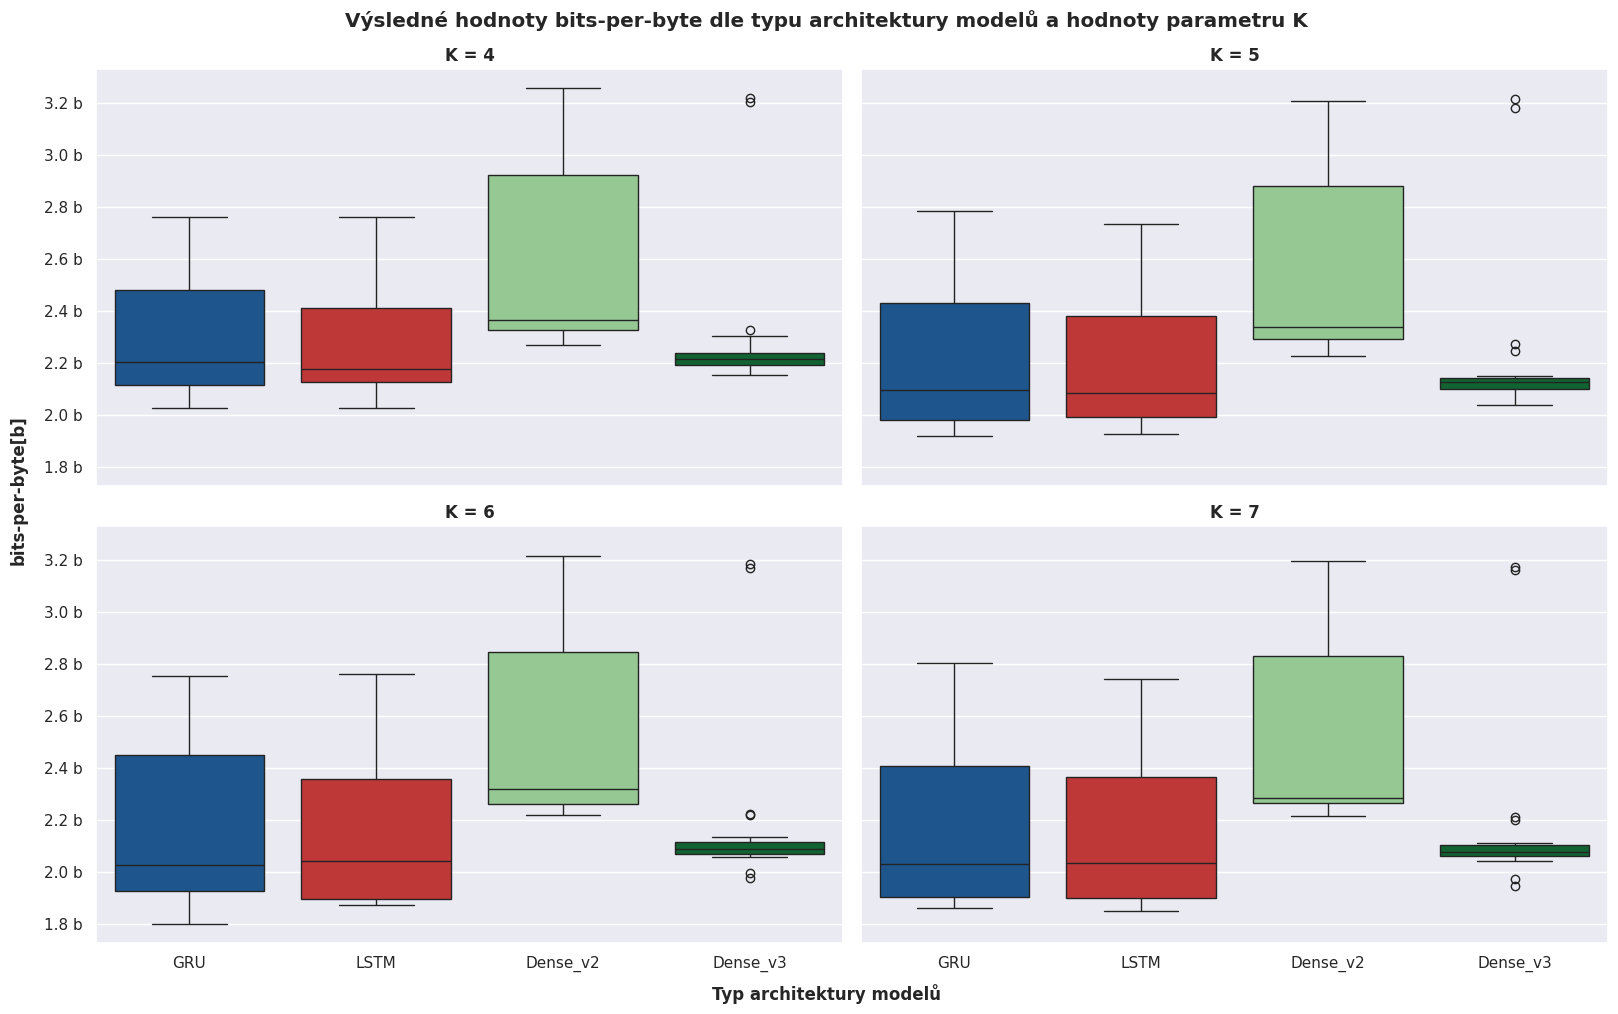

In [58]:
k_values = [4, 5, 6, 7]
size_values = [1, 5, 10]
type_values = ["RNN_GRU", "RNN_LSTM", "DNN"]
# Load results of experiments
df = load_all_results(k_values, size_values, type_values)
print(df.shape)
# Create figure and subplots
fig, axs = plt.subplots(2, 2, figsize=(16, 10), sharey=True, sharex=True)
# Iterate over unique values of 'k'
for i, k in enumerate(k_values):
    # Filter data for the current value of 'k'
    df_k = df[df['k'] == k]
    # Create boxplots with hue parameter using Seaborn
    sns.boxplot(x='ModelType', y='BitsPerByte[b]', hue='ModelType', data=df_k, ax=axs[i//2][i%2], legend=False, palette=hue_colors)

    # Set labels and title of figure
    #axs[i//2][i%2].set_xlabel('Typ architektury modelů', fontweight='bold')
    #axs[i//2][i%2].set_ylabel('bits-per-byte[b]', fontweight='bold')
    axs[i//2][i%2].set_title(f'K = {k}', fontweight='bold')

    # Remove x and y axis labels
    axs[i//2][i%2].set_xlabel('')
    axs[i//2][i%2].set_ylabel('')
    # Set X axis formater to show the value in KB
    #axs[i//2][i%2].yaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, _: f"{np.round(x, 1)} b"))
    #axs[i//2][i%2].grid(True)

# Set the title for the entire figure
fig.suptitle('Výsledné hodnoty bits-per-byte dle typu architektury modelů a hodnoty parametru K', fontweight='bold')

# Draw the legend for the entire figure
#fig.legend(title="Typ architektury", loc='upper right')

# Set X axis formatter to show the value in KB
for ax_row in axs:
    for ax in ax_row:
        ax.yaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, _: f"{np.round(x, 1)} b"))

# Optionally, set common labels
fig.text(0.5, -0.01, 'Typ architektury modelů', ha='center', fontweight='bold')
fig.text(-0.01, 0.5, 'bits-per-byte[b]', va='center', rotation='vertical', fontweight='bold')

# Adjust layout
plt.tight_layout()

# Save the plot as a PDF file
plt.savefig('images/05-02-02.pdf', format='pdf', bbox_inches='tight')

# Show the plot
plt.show()
# Draw legend
#ax1.legend(title="Typ architektury")

(12, 17)


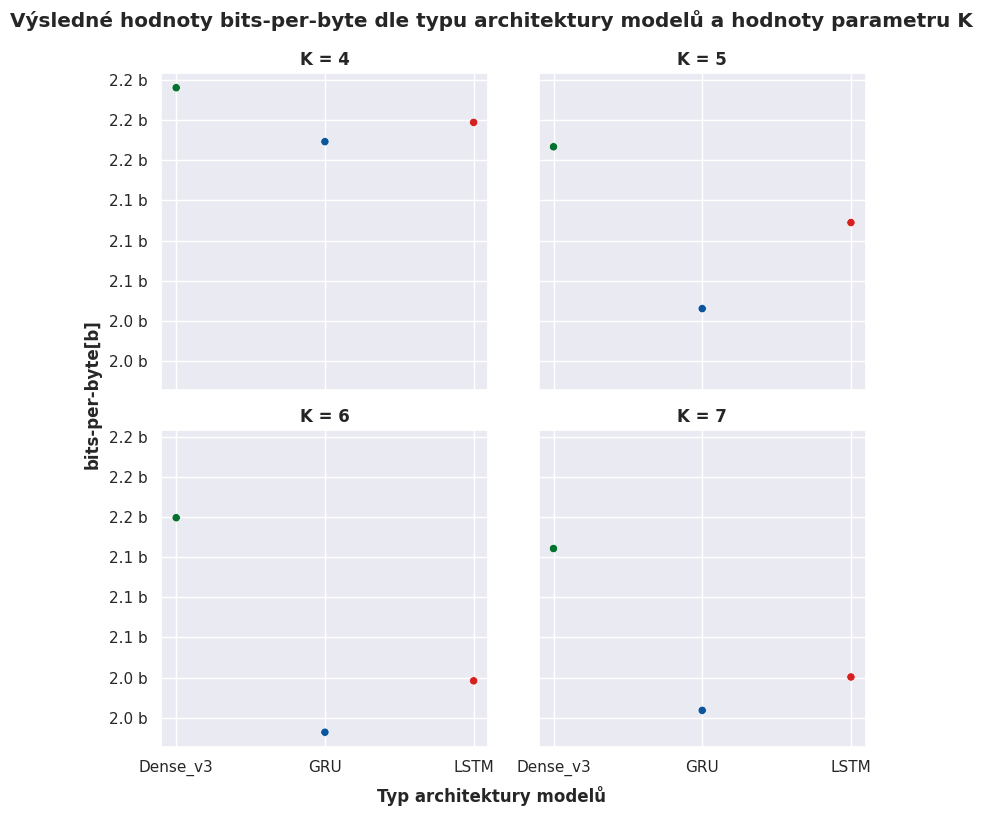

In [57]:
k_values = []
size_values = []
type_values = []

additional_filenames = ["logs/heterogenous/DNN_k4.txt", "logs/heterogenous/DNN_k5.txt", "logs/heterogenous/DNN_k6.txt", "logs/heterogenous/DNN_k7.txt",
                        "logs/heterogenous/RNN_GRU_k4.txt", "logs/heterogenous/RNN_GRU_k5.txt", "logs/heterogenous/RNN_GRU_k6.txt", "logs/heterogenous/RNN_GRU_k7.txt",
                        "logs/heterogenous/RNN_LSTM_k4.txt", "logs/heterogenous/RNN_LSTM_k5.txt", "logs/heterogenous/RNN_LSTM_k6.txt", "logs/heterogenous/RNN_LSTM_k7.txt"]

# Load results of experiments
df = load_all_results(k_values, size_values, type_values, additional_filenames=additional_filenames)
print(df.shape)
# Create figure and subplots
fig, axs = plt.subplots(2, 2, figsize=(8, 8), sharey=True, sharex=True) # figsize=(16, 10)
k_values = df["k"].unique()
# Iterate over unique values of 'k'
for i, k in enumerate(k_values):
    # Filter data for the current value of 'k'
    df_k = df[df['k'] == k]
    # Create boxplots with hue parameter using Seaborn
    sns.scatterplot(x='ModelType', y='BitsPerByte[b]', hue='ModelType', data=df_k, ax=axs[i//2][i%2], legend=False, palette=hue_colors)

    # Set labels and title of figure
    #axs[i//2][i%2].set_xlabel('Typ architektury modelů', fontweight='bold')
    #axs[i//2][i%2].set_ylabel('bits-per-byte[b]', fontweight='bold')
    axs[i//2][i%2].set_title(f'K = {k}', fontweight='bold')

    # Remove x and y axis labels
    axs[i//2][i%2].set_xlabel('')
    axs[i//2][i%2].set_ylabel('')
    # Set X axis formater to show the value in KB
    #axs[i//2][i%2].yaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, _: f"{np.round(x, 1)} b"))
    #axs[i//2][i%2].grid(True)

# Set the title for the entire figure
fig.suptitle('Výsledné hodnoty bits-per-byte dle typu architektury modelů a hodnoty parametru K', fontweight='bold')

# Draw the legend for the entire figure
#fig.legend(title="Typ architektury", loc='upper right')

# Set X axis formatter to show the value in KB
for ax_row in axs:
    for ax in ax_row:
        ax.yaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, _: f"{np.round(x, 1)} b"))

# Optionally, set common labels
fig.text(0.5, -0.01, 'Typ architektury modelů', ha='center', fontweight='bold')
fig.text(-0.01, 0.5, 'bits-per-byte[b]', va='center', rotation='vertical', fontweight='bold')

# Adjust layout
plt.tight_layout()

# Save the plot as a PDF file
plt.savefig('images/05-09.pdf', format='pdf', bbox_inches='tight')

# Show the plot
plt.show()
# Draw legend
#ax1.legend(title="Typ architektury")

In [62]:
df_size_1 = df[df['InputFileSize[b]'] == 1 * 1000 * 1000 * 8.0]
df_size_5 = df[df['InputFileSize[b]'] == 5 * 1000 * 1000 * 8.0]
df_size_10 = df[df['InputFileSize[b]'] == 10 * 1000 * 1000 * 8.0]

print(df_size_1.groupby("ModelType")["BitsPerByte[b]"].mean())
print(df_size_5.groupby("ModelType")["BitsPerByte[b]"].mean())
print(df_size_10.groupby("ModelType")["BitsPerByte[b]"].mean())

ModelType
Dense_v2    2.584571
GRU         2.248914
LSTM        2.220240
Name: BitsPerByte[b], dtype: float64
ModelType
Dense_v3    2.224945
GRU         2.248029
LSTM        2.216200
Name: BitsPerByte[b], dtype: float64
ModelType
Dense_v3    2.222091
GRU         2.149040
LSTM        2.138200
Name: BitsPerByte[b], dtype: float64


In [59]:
df.ModelType.unique()

array(['GRU', 'LSTM', 'Dense_v2', 'Dense_v3'], dtype=object)

In [61]:
df.loc[df["ModelType"] == "Dense_v2"]["BitsPerByte[b]"].mean()

2.5845714285714285

In [64]:
df_k_4 = df[df['k'] == 4]
df_k_5 = df[df['k'] == 5]
df_k_6 = df[df['k'] == 6]
df_k_7 = df[df['k'] == 7]

print(df_k_4.groupby("ModelType")["BitsPerByte[b]"].median())
print(df_k_5.groupby("ModelType")["BitsPerByte[b]"].median())
print(df_k_6.groupby("ModelType")["BitsPerByte[b]"].median())
print(df_k_7.groupby("ModelType")["BitsPerByte[b]"].median())

ModelType
Dense_v2    2.3648
Dense_v3    2.2152
GRU         2.2056
LSTM        2.1752
Name: BitsPerByte[b], dtype: float64
ModelType
Dense_v2    2.3392
Dense_v3    2.1264
GRU         2.0960
LSTM        2.0832
Name: BitsPerByte[b], dtype: float64
ModelType
Dense_v2    2.3184
Dense_v3    2.0880
GRU         2.0260
LSTM        2.0432
Name: BitsPerByte[b], dtype: float64
ModelType
Dense_v2    2.2848
Dense_v3    2.0752
GRU         2.0280
LSTM        2.0328
Name: BitsPerByte[b], dtype: float64


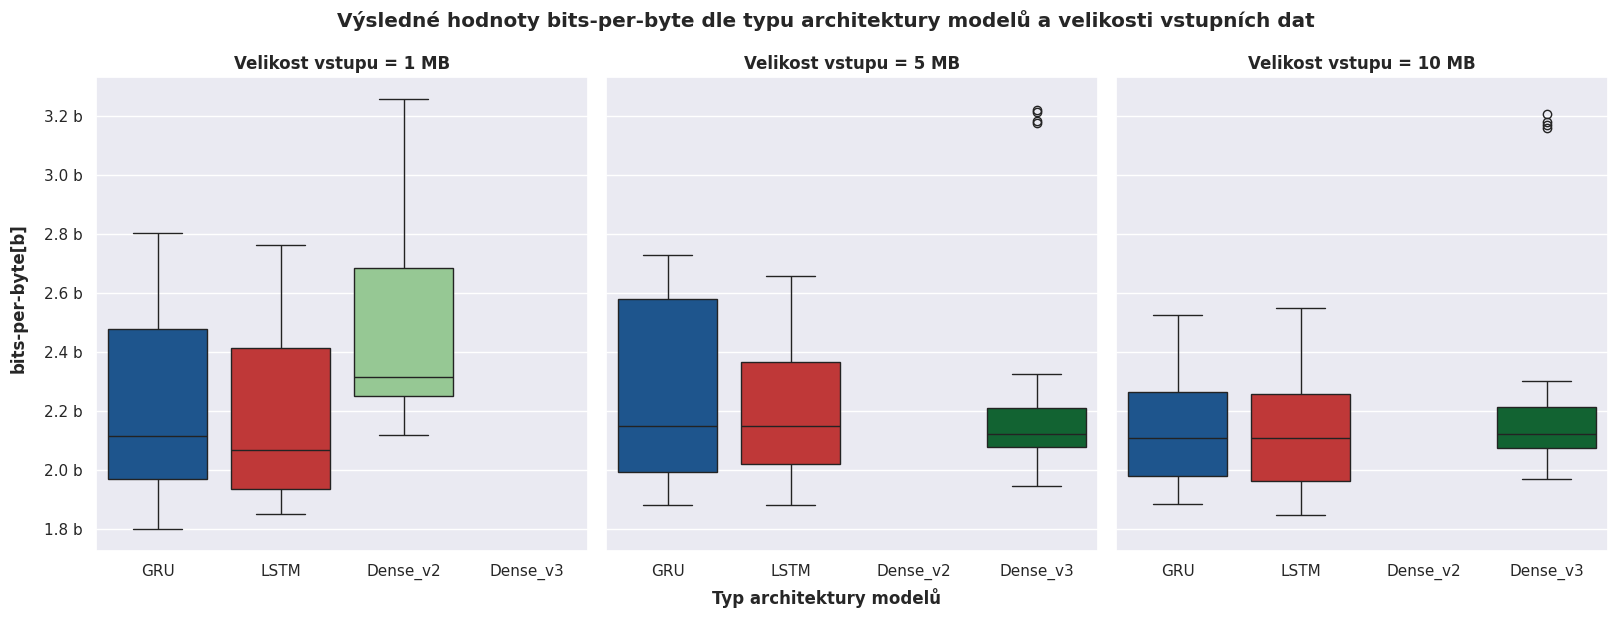

In [151]:
k_values = [4, 5, 6, 7]
size_values = [1, 5, 10]
type_values = ["RNN_GRU", "RNN_LSTM", "DNN"]
# Load results of experiments
df = load_all_results(k_values, size_values, type_values)
# Create figure and subplots
number_of_rows = 1
number_of_cols = 3
fig, axs = plt.subplots(number_of_rows, number_of_cols, figsize=(16, 6), sharey=True, sharex=True)

# Iterate over unique values of 'size'
for i, size in enumerate(size_values):
    # Filter data for the current value of 'size'
    df_size = df[df['InputFileSize[b]'] == size * 1000 * 1000 * 8.0]
    # Create boxplots with hue parameter using Seaborn
    sns.boxplot(x='ModelType', y='BitsPerByte[b]', hue='ModelType', data=df_size, ax=axs[i], legend=False, palette=hue_colors)
    # Set title of figure
    axs[i].set_title(f'Velikost vstupu = {size} MB', fontweight='bold')
    # Remove x and y axis labels
    axs[i].set_xlabel('')
    axs[i].set_ylabel('')

# Set the title for the entire figure
fig.suptitle('Výsledné hodnoty bits-per-byte dle typu architektury modelů a velikosti vstupních dat', fontweight='bold')

# Set X axis formatter to show the value in KB
for ax in axs:
    ax.yaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, _: f"{np.round(x, 1)} b"))

# Optionally, set common labels
fig.text(0.5, -0.01, 'Typ architektury modelů', ha='center', fontweight='bold')
fig.text(-0.01, 0.5, 'bits-per-byte[b]', va='center', rotation='vertical', fontweight='bold')
# Adjust layout
plt.tight_layout()

# Save the plot as a PDF file
plt.savefig('images/avgBpBForDifferentArchitecturesWithDifferentSize.pdf', format='pdf', bbox_inches='tight')

# Show the plot
plt.show()

(12, 17)


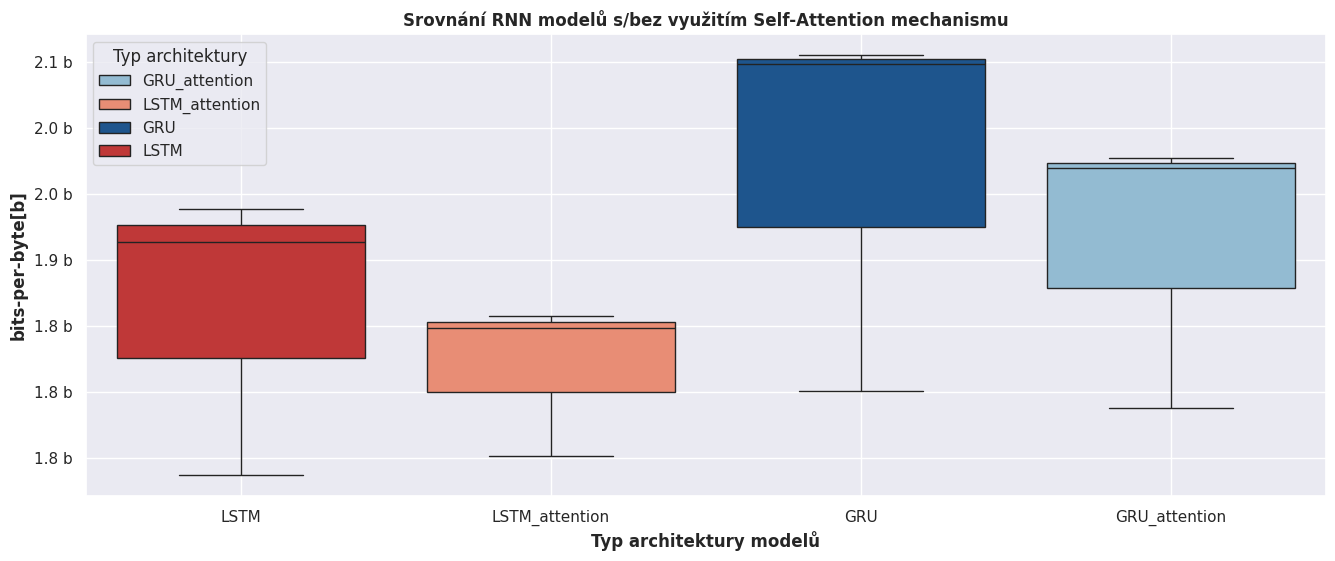

In [23]:
k_values = [7]
size_values = [1, 5, 10]
type_values = ["RNN_GRU_MULTI_HEAD_ATTENTION", "RNN_LSTM_MULTI_HEAD_ATTENTION", "RNN_WITHOUT_ATTENTION"]
# Load results of experiments
df = load_all_results(k_values, size_values, type_values)
print(df.shape)
# Create figure
fig, ax1 = plt.subplots(1, 1, figsize=(16,6),)
# Set labels and title of figure
ax1.set_xlabel('Typ architektury modelů', fontweight='bold')
ax1.set_ylabel('bits-per-byte[b]', fontweight='bold')
ax1.set_title('Srovnání RNN modelů s/bez využitím Self-Attention mechanismu', fontweight='bold')
# Create boxplots with hue parameter using Seaborn
sns.boxplot(x='ModelType', y='BitsPerByte[b]', hue='ModelType', data=df, ax=ax1, legend=True, order=["LSTM", "LSTM_attention", "GRU", "GRU_attention"], palette=hue_colors)
# Set X axis formater to show the value in KB
ax1.yaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, _: f"{np.round(x, 1)} b"))
ax1.grid(True)
# Draw legend
ax1.legend(title="Typ architektury")
# Save the plot as a PDF file
plt.savefig('images/05-01-02.pdf', format='pdf', bbox_inches='tight')
# Show the plot
plt.show()

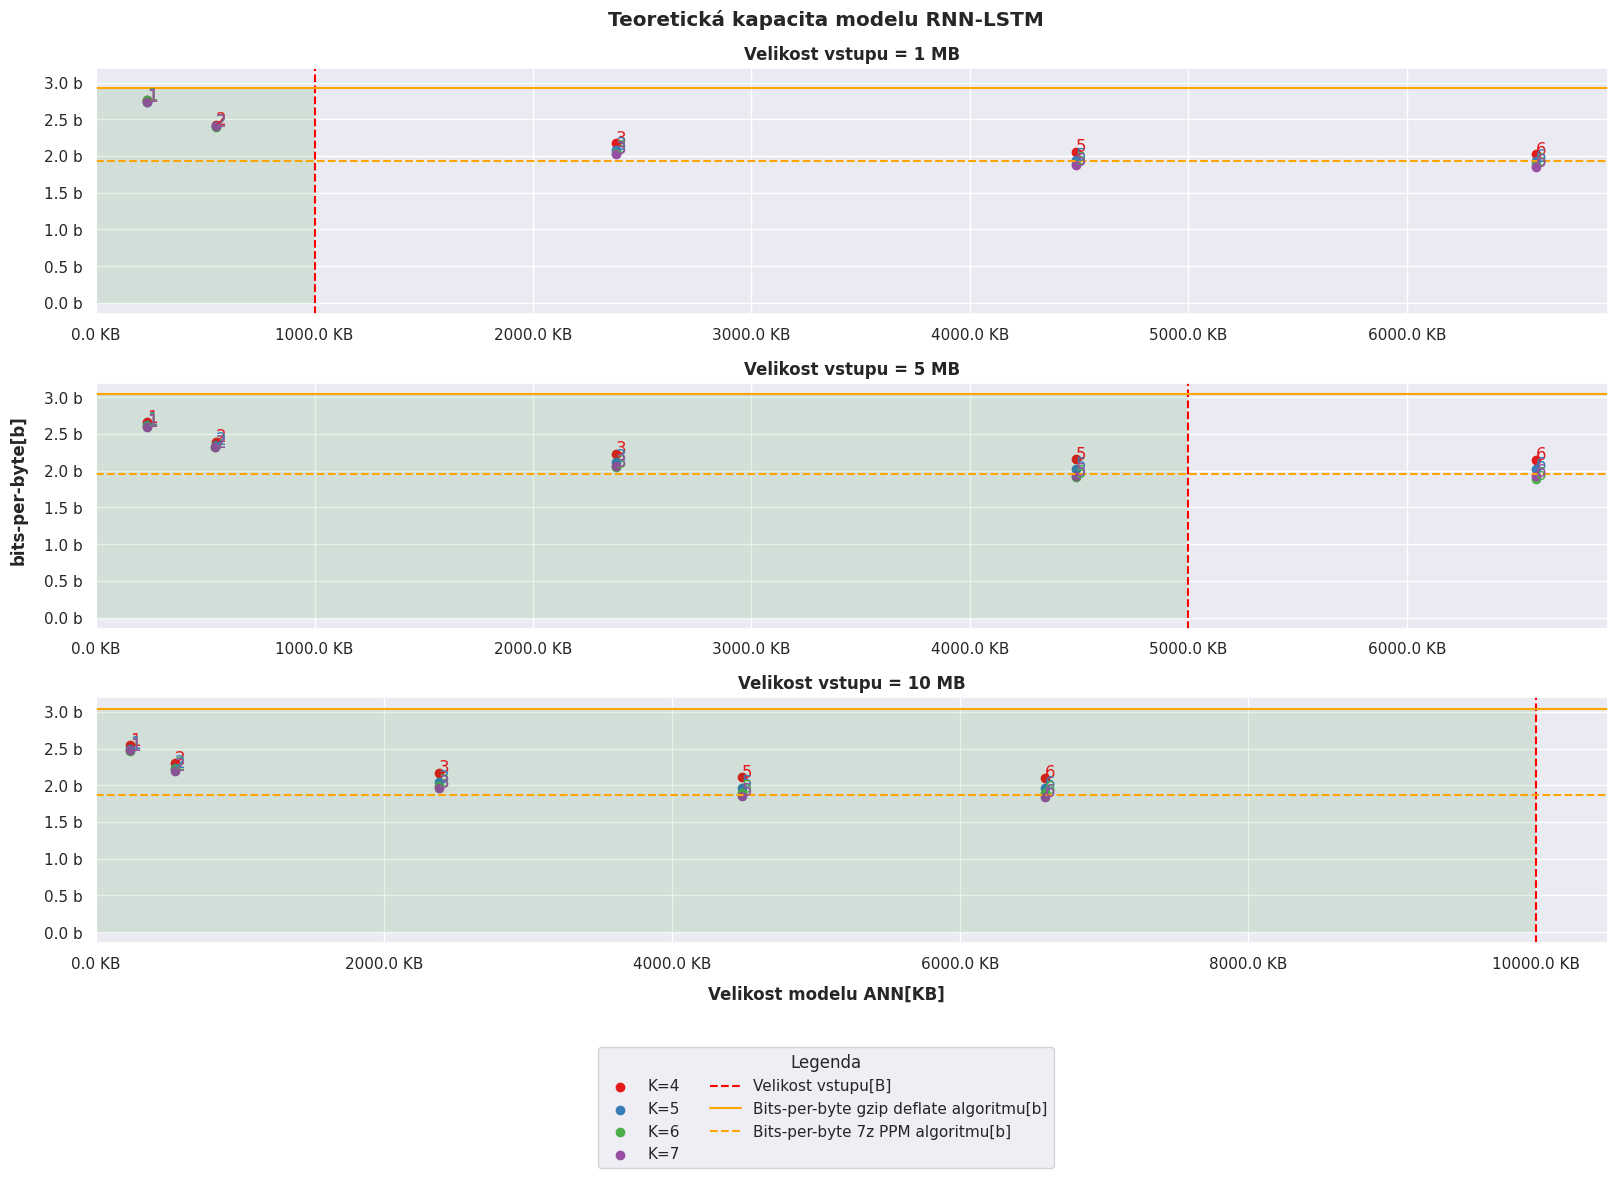

In [87]:
k_values = [4, 5, 6, 7]
size_values = [1, 5, 10]
size_values_bits = [8_000_000, 40_000_000, 80_000_000]
bpb_gzip = [2.9224, 3.048, 3.0376]
bpb_7z = [1.9384, 1.96, 1.8696]
type_values = ["RNN_LSTM"]
additional_filenames = []

# Load results of experiments
df = load_all_results(k_values, size_values, type_values, additional_filenames=additional_filenames)

# Define colors for each value of parameter K
hue_colors = sns.color_palette("Set1", n_colors=len(df.k.unique()))
# Create figure
fig, axs = plt.subplots(3, 1, figsize=(16,10), sharex=False, sharey=True)

# Iterate over unique values of 'size'
for i, size in enumerate(size_values):
    # Filter data for the current value of 'size'
    df_size = df[df['InputFileSize[b]'] == size * 1000 * 1000 * 8.0]

    # Create scatter plot for each "K"
    for j, k in enumerate(df["k"].unique()):
        df_k = df_size.loc[df_size["k"] == k]
        axs[i].scatter(x=df_k["ModelSize[B]"], y=df_k["BitsPerByte[b]"], color=hue_colors[j], label=f"K={k}")

    # Create vertical line which bounds the graph from right as size of input file
    axs[i].axvline(x=size_values_bits[i] / 8, color="red", linestyle="--", label="Velikost vstupu[B]")
    # Create horizontal line which shows bits-per-byte of gzip
    axs[i].axhline(y=bpb_gzip[i], color="orange", linestyle="-", label="Bits-per-byte gzip deflate algoritmu[b]")
    # Create horizontal line which shows bits-per-byte of 7z PPM
    axs[i].axhline(y=bpb_7z[i], color="orange", linestyle="--", label="Bits-per-byte 7z PPM algoritmu[b]")

    # Set title of figure
    axs[i].set_title(f'Velikost vstupu = {size} MB', fontweight='bold')
    # Remove x and y axis labels
    axs[i].set_xlabel('')
    axs[i].set_ylabel('')

    # Make visible area of optimal solution
    width, height = size_values_bits[i] / 8, bpb_gzip[i]     
    # Define the x and y coordinates for the green region
    x_region = [0, width, width,  0]
    y_region = [0, 0,     height, height] 
    
    # Fill the region with green color
    axs[i].fill(x_region, y_region, 'green', alpha=0.1)
    
    axs[i].set_xlim(0, None)
    
    # Set X axis formater to show the value in KB
    axs[i].grid(True)
    
    # Loop through the data and add text labels with corresponding colors
    for _, point in df_size.iterrows():
        color = hue_colors[df_size['k'].unique().tolist().index(point["k"])]
        axs[i].text((point['ModelSize[B]'])+.02, point['BitsPerByte[b]'], str("_".join((point['ModelName']).split("_")[2:])), color=color)
        
    
# Set the title for the entire figure
fig.suptitle('Teoretická kapacita modelu RNN-LSTM', fontweight='bold')

# Set X axis formatter to show the value in KB
for ax in axs:
    ax.yaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, _: f"{np.round(x, 1)} b"))
    ax.xaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, y: f"{int(x) / 1000} KB"))

# Optionally, set common labels
fig.text(0.5, -0.01, 'Velikost modelu ANN[KB]', ha='center', fontweight='bold')
fig.text(-0.01, 0.5, 'bits-per-byte[b]', va='center', rotation='vertical', fontweight='bold')

# Adjust layout
plt.tight_layout()

# Create a shared legend
handles, labels = axs[0].get_legend_handles_labels()
fig.legend(title="Legenda", handles=handles, labels=labels, loc='upper center', bbox_to_anchor=(0.5, -0.05), ncol=2)

# Save the plot as a PDF file
plt.savefig('images/05-05.pdf', format='pdf', bbox_inches='tight')

# Show the plot
plt.show()



(4, 17)
2.0056 2.0296
1.9904 2.0504


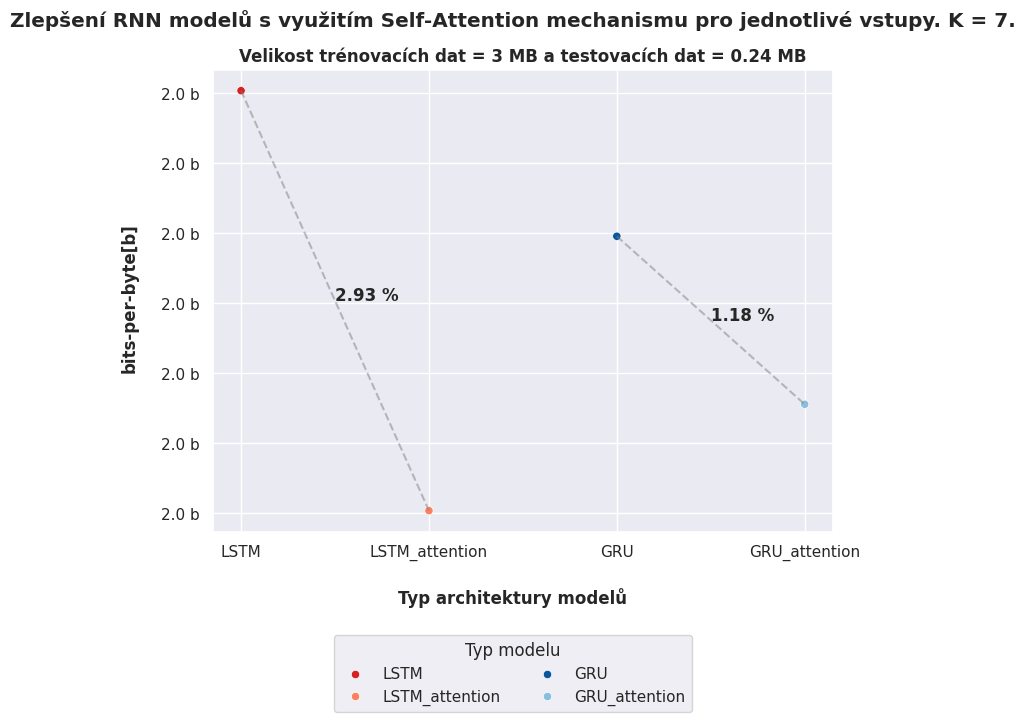

In [44]:
k_values = []
size_values = []
type_values = []
additional_filenames = ["logs/heterogenous/RNN_GRU_MULTI_HEAD_ATTENTION_k7.txt",
                        "logs/heterogenous/RNN_LSTM_MULTI_HEAD_ATTENTION_k7.txt",
                        "logs/heterogenous/RNN_GRU_k7.txt",
                        "logs/heterogenous/RNN_LSTM_k7.txt"]
# Load results of experiments
df = load_all_results(k_values, size_values, type_values, additional_filenames=additional_filenames)
print(df.shape)
# Create figure
fig, axs = plt.subplots(1, 1, figsize=(8,6),)

order = {'LSTM': 0, 'LSTM_attention': 1, 'GRU': 2, 'GRU_attention': 3}
# Iterate over unique values of 'size'
size_values = df['InputFileSize[b]'].unique()
for i, size in enumerate(size_values):
    # Filter data for the current value of 'size'
    df_size = df[df['InputFileSize[b]'] == size]

    # Convert 'Category' column to categorical with specified order
    df_size['ModelType'] = pd.Categorical(df_size['ModelType'], categories=['LSTM', 'LSTM_attention', 'GRU', 'GRU_attention'], ordered=True)
    # Create boxplots with hue parameter using Seaborn
    sns.scatterplot(x='ModelType', y='BitsPerByte[b]', hue='ModelType', data=df_size, ax=axs, legend=True, palette=hue_colors)

    # Visualize the difference
    for model_name in df_size["ModelName"].unique():
        if not model_name.endswith("attention"):
            p1 = df_size.loc[df_size["ModelName"] == model_name, :].iloc[0]
            p2 = df_size.loc[df_size["ModelName"] == f"{model_name}_attention"].iloc[0]
            x1, y1 = p1["ModelType"], p1["BitsPerByte[b]"]
            x2, y2 = p2["ModelType"], p2["BitsPerByte[b]"]

            improvement = -((p2["BitsPerByte[b]"] - p1["BitsPerByte[b]"]) / p1["BitsPerByte[b]"]) * 100
            improvement = np.round(improvement, 2)
            #axs[i].text((point['ModelSize[B]'])+.02, point['BitsPerByte[b]'], str("_".join((point['ModelName']).split("_")[2:])), color=color)
            print(y2, y1)
            axs.text((order[x2] + order[x1]) / 2, (y2 + y1) / 2, f"{improvement} %", fontweight='bold')
            axs.plot([x1, x2], [y1, y2], linestyle="dashed", color='gray', alpha=0.5)
    #axs[i].plot([])
    
    # Set X axis formater to show the value in KB
    axs.yaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, _: f"{np.round(x, 1)} b"))
    axs.grid(True)
    
    axs.legend().set_visible(False)

    # Remove x and y axis labels
    axs.set_xlabel('')
    axs.set_ylabel('')
    
    # Set title of figure
    axs.set_title(f'Velikost trénovacích dat = 3 MB a testovacích dat = {np.round(size / 1000 / 1000 / 8, 2)} MB', fontweight='bold')

# Set the title for the entire figure
fig.suptitle('Zlepšení RNN modelů s využitím Self-Attention mechanismu pro jednotlivé vstupy. K = 7.', fontweight='bold')
# Optionally, set common labels
fig.text(0.5, -0.01, 'Typ architektury modelů', ha='center', fontweight='bold')
fig.text(0.01, 0.5, 'bits-per-byte[b]', va='center', rotation='vertical', fontweight='bold')

# Create a shared legend
handles, labels = axs.get_legend_handles_labels()
fig.legend(title="Typ modelu", handles=handles, labels=labels, loc='upper center', bbox_to_anchor=(0.5, -0.05), ncol=2)

# Save the plot as a PDF file
plt.savefig('images/05-08.pdf', format='pdf', bbox_inches='tight')
# Show the plot
plt.show()

(12, 17)
1.788 1.8008
1.7512 1.7368
1.9768 2.0488
1.848 1.9136


/tmp/ipykernel_77/1367835475.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_size['ModelType'] = pd.Categorical(df_size['ModelType'], categories=['LSTM', 'LSTM_attention', 'GRU', 'GRU_attention'], ordered=True)
/tmp/ipykernel_77/1367835475.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_size['ModelType'] = pd.Categorical(df_size['ModelType'], categories=['LSTM', 'LSTM_attention', 'GRU', 'GRU_attention'], ordered=True)
/tmp/ipykernel_77/1367835475.py:17: SettingWithCopyWarning: 
A value is tr

1.9696 2.0552
1.8576 1.9384


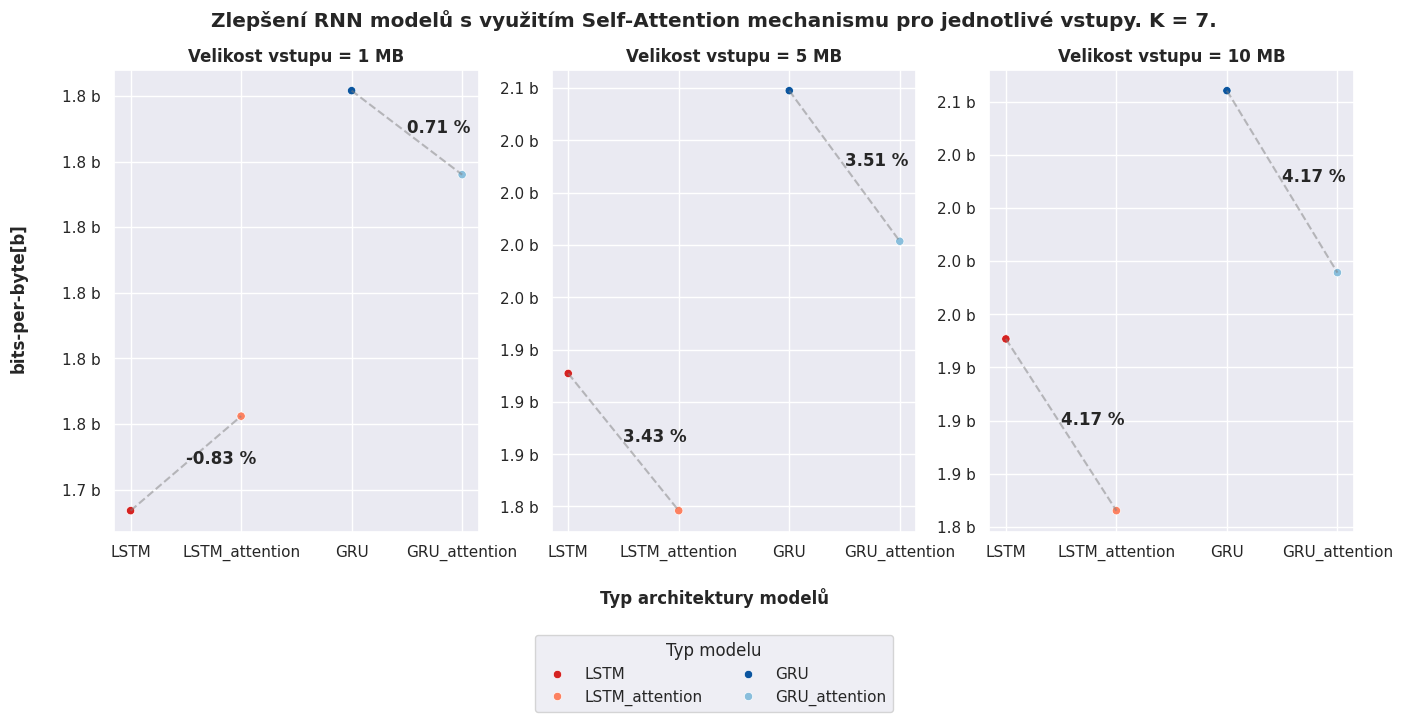

In [25]:
k_values = [7]
size_values = [1, 5, 10]
type_values = ["RNN_GRU_MULTI_HEAD_ATTENTION", "RNN_LSTM_MULTI_HEAD_ATTENTION", "RNN_WITHOUT_ATTENTION"]
# Load results of experiments
df = load_all_results(k_values, size_values, type_values)
print(df.shape)
# Create figure
fig, axs = plt.subplots(1, 3, figsize=(16,6),)

order = {'LSTM': 0, 'LSTM_attention': 1, 'GRU': 2, 'GRU_attention': 3}
# Iterate over unique values of 'size'
for i, size in enumerate(size_values):
    # Filter data for the current value of 'size'
    df_size = df[df['InputFileSize[b]'] == size * 1000 * 1000 * 8.0]

    # Convert 'Category' column to categorical with specified order
    df_size['ModelType'] = pd.Categorical(df_size['ModelType'], categories=['LSTM', 'LSTM_attention', 'GRU', 'GRU_attention'], ordered=True)
    # Create boxplots with hue parameter using Seaborn
    sns.scatterplot(x='ModelType', y='BitsPerByte[b]', hue='ModelType', data=df_size, ax=axs[i], legend=True, palette=hue_colors)

    # Visualize the difference
    for model_name in df_size["ModelName"].unique():
        if not model_name.endswith("attention"):
            p1 = df_size.loc[df_size["ModelName"] == model_name, :].iloc[0]
            p2 = df_size.loc[df_size["ModelName"] == f"{model_name}_attention"].iloc[0]
            x1, y1 = p1["ModelType"], p1["BitsPerByte[b]"]
            x2, y2 = p2["ModelType"], p2["BitsPerByte[b]"]

            improvement = -((p2["BitsPerByte[b]"] - p1["BitsPerByte[b]"]) / p1["BitsPerByte[b]"]) * 100
            improvement = np.round(improvement, 2)
            #axs[i].text((point['ModelSize[B]'])+.02, point['BitsPerByte[b]'], str("_".join((point['ModelName']).split("_")[2:])), color=color)
            print(y2, y1)
            axs[i].text((order[x2] + order[x1]) / 2, (y2 + y1) / 2, f"{improvement} %", fontweight='bold')
            axs[i].plot([x1, x2], [y1, y2], linestyle="dashed", color='gray', alpha=0.5)
    #axs[i].plot([])
    
    # Set X axis formater to show the value in KB
    axs[i].yaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, _: f"{np.round(x, 1)} b"))
    axs[i].grid(True)
    
    axs[i].legend().set_visible(False)

    # Remove x and y axis labels
    axs[i].set_xlabel('')
    axs[i].set_ylabel('')
    
    # Set title of figure
    axs[i].set_title(f'Velikost vstupu = {size} MB', fontweight='bold')

# Set the title for the entire figure
fig.suptitle('Zlepšení RNN modelů s využitím Self-Attention mechanismu pro jednotlivé vstupy. K = 7.', fontweight='bold')
# Optionally, set common labels
fig.text(0.5, -0.01, 'Typ architektury modelů', ha='center', fontweight='bold')
fig.text(0.06, 0.5, 'bits-per-byte[b]', va='center', rotation='vertical', fontweight='bold')

# Create a shared legend
handles, labels = axs[0].get_legend_handles_labels()
fig.legend(title="Typ modelu", handles=handles, labels=labels, loc='upper center', bbox_to_anchor=(0.5, -0.05), ncol=2)

# Save the plot as a PDF file
plt.savefig('images/05-06.pdf', format='pdf', bbox_inches='tight')
# Show the plot
plt.show()

In [31]:
# create latex row item
k_values = [4, 5, 6, 7]
size_values = [1]
type_values = []
additional_filenames = ["logs/heterogenous/DNN_k4.txt", "logs/heterogenous/DNN_k5.txt", "logs/heterogenous/DNN_k6.txt", "logs/heterogenous/DNN_k7.txt",
                        "logs/heterogenous/RNN_GRU_k4.txt", "logs/heterogenous/RNN_GRU_k5.txt", "logs/heterogenous/RNN_GRU_k6.txt", "logs/heterogenous/RNN_GRU_k7.txt",
                        "logs/heterogenous/RNN_LSTM_k4.txt", "logs/heterogenous/RNN_LSTM_k5.txt", "logs/heterogenous/RNN_LSTM_k6.txt", "logs/heterogenous/RNN_LSTM_k7.txt",
                        "logs/heterogenous/RNN_GRU_MULTI_HEAD_ATTENTION_k7.txt",
                        "logs/heterogenous/RNN_LSTM_MULTI_HEAD_ATTENTION_k7.txt"]
# Load results of experiments
df = load_all_results(k_values, size_values, type_values, additional_filenames=additional_filenames)

lines = []
for _, row in df.iterrows():
    line = " & ".join([row["ModelName"], str(row["k"]), str(row["Epochs"]), str(row["BatchSize"]),
                       row["OptimizerName"], row["MaxTrainValidationTestAccuracy"],
                       str(row["BitsPerByte[b]"]), str(row["OutputFileSize[b]"] / 8), str(row["ModelSize[B]"])])
    line = line + r" \\"
    line = line.replace("_", "\_")
    lines.append(line)
    
print("\n".join(lines))

Dense\_v3\_3 & 4 & 10 & 64 & Adam & 0.5626/0.5473/0.5606 & 2.1952 & 65094.7423125 & 1858952.0 \\
Dense\_v3\_3 & 5 & 10 & 64 & Adam & 0.5863/0.5651/0.5742 & 2.1584 & 63991.6665 & 2121232.0 \\
Dense\_v3\_3 & 6 & 10 & 64 & Adam & 0.5949/0.5710/0.5832 & 2.1496 & 63730.2149625 & 2383336.0 \\
Dense\_v3\_3 & 7 & 10 & 64 & Adam & 0.5971/0.5720/0.5801 & 2.1304 & 63170.7899125 & 2645480.0 \\
Recurrent\_GRU\_5 & 4 & 10 & 128 & RMSprop & 0.5667/0.5504/0.5594 & 2.1616 & 64087.4108875 & 3441360.0 \\
Recurrent\_GRU\_5 & 5 & 10 & 128 & RMSprop & 0.5951/0.5731/0.5843 & 2.0576 & 61002.7047125 & 3441360.0 \\
Recurrent\_GRU\_5 & 6 & 10 & 128 & RMSprop & 0.6062/0.5807/0.5973 & 2.016 & 59765.662725 & 3441360.0 \\
Recurrent\_GRU\_5 & 7 & 10 & 128 & RMSprop & 0.6101/0.5814/0.5926 & 2.0296 & 60175.9246875 & 3441360.0 \\
Recurrent\_LSTM\_5 & 4 & 10 & 128 & RMSprop & 0.5666/0.5488/0.5601 & 2.1736 & 64456.721075 & 4485640.0 \\
Recurrent\_LSTM\_5 & 5 & 10 & 128 & RMSprop & 0.6000/0.5749/0.5839 & 2.1112 & 62587.895

/tmp/ipykernel_12879/3569254664.py:44: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(df["ModelName"], rotation=90)


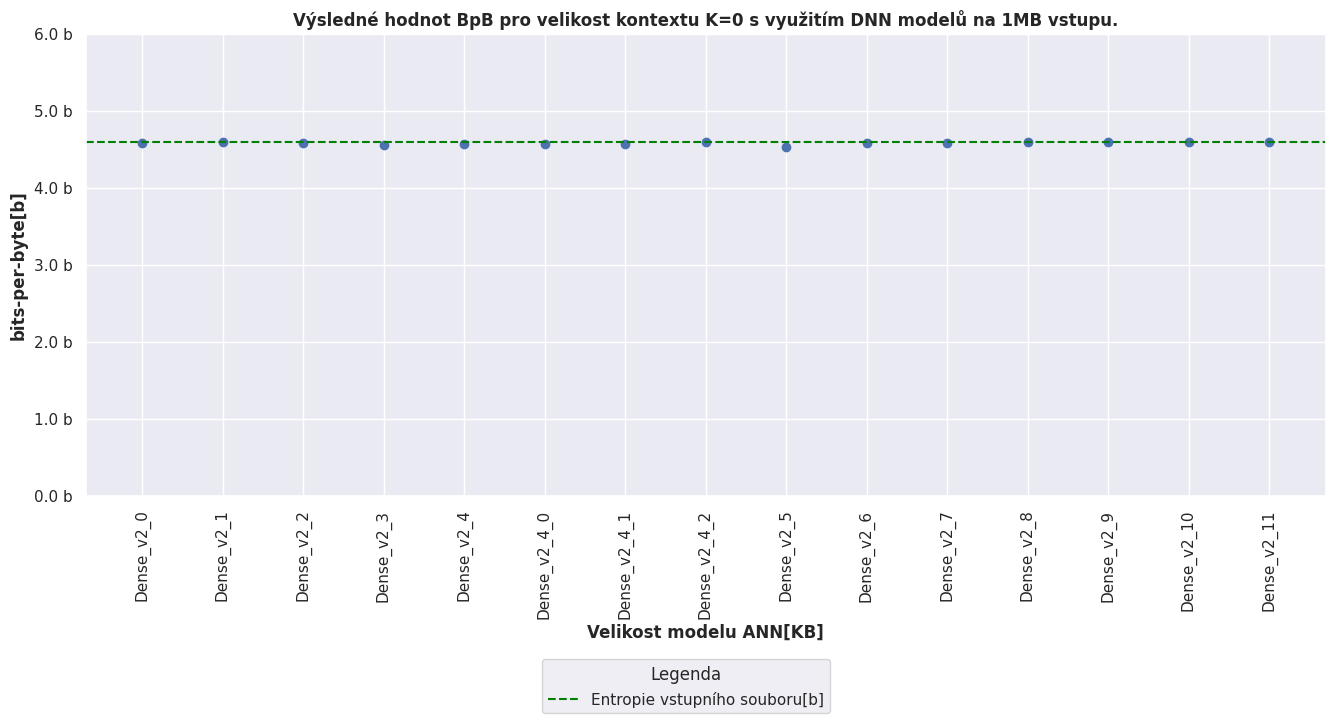

In [192]:
k_values = []
size_values = []
type_values = []
entropy_of_file = 4.590017983378693
additional_filenames = ["logs/DNN_log_k0_1MB.txt"]

# Load results of experiments
df = load_all_results(k_values, size_values, type_values, additional_filenames=additional_filenames)

# Define colors for each value of parameter K
hue_colors = sns.color_palette("Set1", n_colors=len(df.k.unique()))

# Create figure
fig, ax = plt.subplots(1, 1, figsize=(16,6), sharex=False, sharey=False)

# Create scatter plot for each "K"
ax.scatter(x=df["ModelName"], y=df["BitsPerByte[b]"])

# Create horizontal line which shows the entropy of the input file
ax.axhline(y=entropy_of_file, color="green", linestyle="--", label="Entropie vstupního souboru[b]")

# Set title of figure
ax.set_title(f'Výsledné hodnot BpB pro velikost kontextu K=0 s využitím DNN modelů na 1MB vstupu.', fontweight='bold')
# Remove x and y axis labels
ax.set_xlabel('Velikost modelu ANN[KB]', fontweight='bold')
ax.set_ylabel('bits-per-byte[b]', fontweight='bold')

# Show grid
ax.grid(True)

ax.set_ylim(0, 6)
#ax.set_xlim(0, None)

# Loop through the data and add text labels with corresponding colors
for _, point in df.iterrows():
    color = hue_colors[df['k'].unique().tolist().index(point["k"])]
    #ax.text((point['ModelSize[B]'])+.02, point['BitsPerByte[b]'], str("_".join((point['ModelName']).split("_")[2:])), color=color)
    
# Set X axis formatter to show the value in KB
ax.yaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, _: f"{np.round(x, 1)} b"))
#ax.xaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, y: f"{int(x) / 1000} KB"))

# Rotate the x-axis tick labels
ax.set_xticklabels(df["ModelName"], rotation=90)

# Create a shared legend
handles, labels = ax.get_legend_handles_labels()
fig.legend(title="Legenda", handles=handles, labels=labels, loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=2)

# Save the plot as a PDF file
plt.savefig('images/05-07.pdf', format='pdf', bbox_inches='tight')

# Show the plot
plt.show()



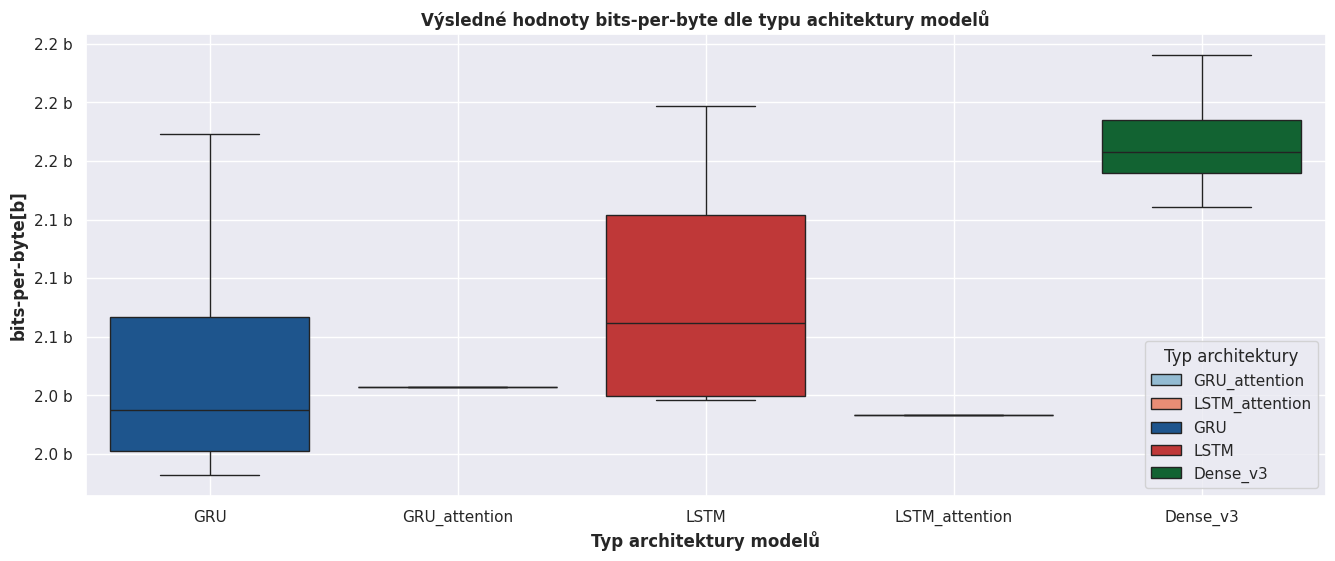

In [212]:
# Set color palette for each type of models.
hue_colors = {"LSTM": sns.color_palette(palette="Reds")[4],
              "LSTM_attention": sns.color_palette(palette="Reds")[2], 
              "GRU": sns.color_palette(palette="Blues")[5],
              "GRU_attention": sns.color_palette(palette="Blues")[2],
              "Dense_v2": sns.color_palette(palette="Greens")[2],
              "Dense_v3": sns.color_palette(palette="Greens")[5]}
k_values = [4, 5, 6, 7]
size_values = []
type_values = ["RNN_GRU", "RNN_LSTM", "DNN",]
# Load results of experiments
df = load_all_results(k_values, size_values, type_values, path_to_folder=r"logs/heterogenous", additional_filenames=[r"logs/heterogenous/RNN_GRU_Attention_k7.txt", r"logs/heterogenous/RNN_LSTM_Attention_k7.txt"])
# Create figure
fig, ax1 = plt.subplots(1, 1, figsize=(16,6),)
# Set labels and title of figure
ax1.set_xlabel('Typ architektury modelů', fontweight='bold')
ax1.set_ylabel('bits-per-byte[b]', fontweight='bold')
ax1.set_title('Výsledné hodnoty bits-per-byte dle typu achitektury modelů', fontweight='bold')
# Create boxplots with hue parameter using Seaborn
sns.boxplot(x='ModelType', y='BitsPerByte[b]', hue='ModelType', data=df, ax=ax1, legend=True, palette=hue_colors, order=["GRU", "GRU_attention", "LSTM", "LSTM_attention", "Dense_v3"])
# Set X axis formater to show the value in KB
ax1.yaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, _: f"{np.round(x, 1)} b"))
ax1.grid(True)
# Draw legend
ax1.legend(title="Typ architektury")
# Save the plot as a PDF file
plt.savefig('images/05-08.pdf', format='pdf', bbox_inches='tight')
# Show the plot
plt.show()

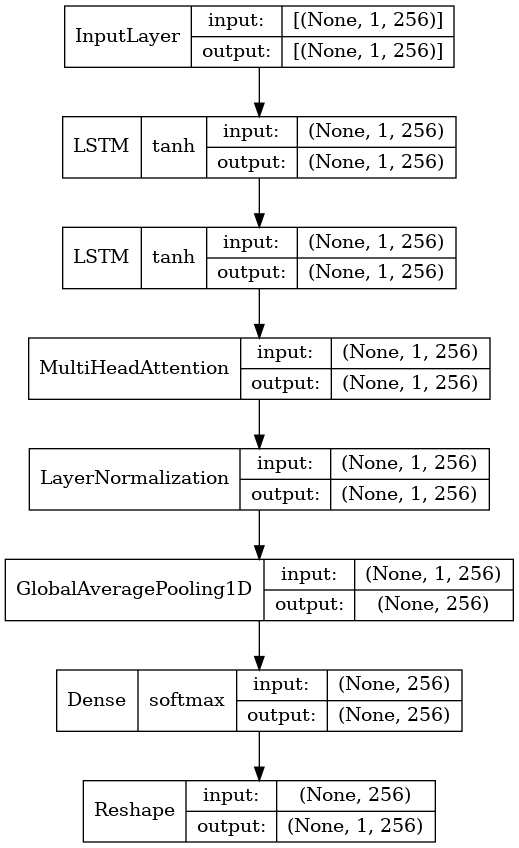

In [139]:
# Vizualize model
m = create_recurrent_lstm_model_5_attention(actual_input_shape, actual_output_shape, actual_alphabet_size)
plot_model(m)

##### Combined learning

(2, 17)


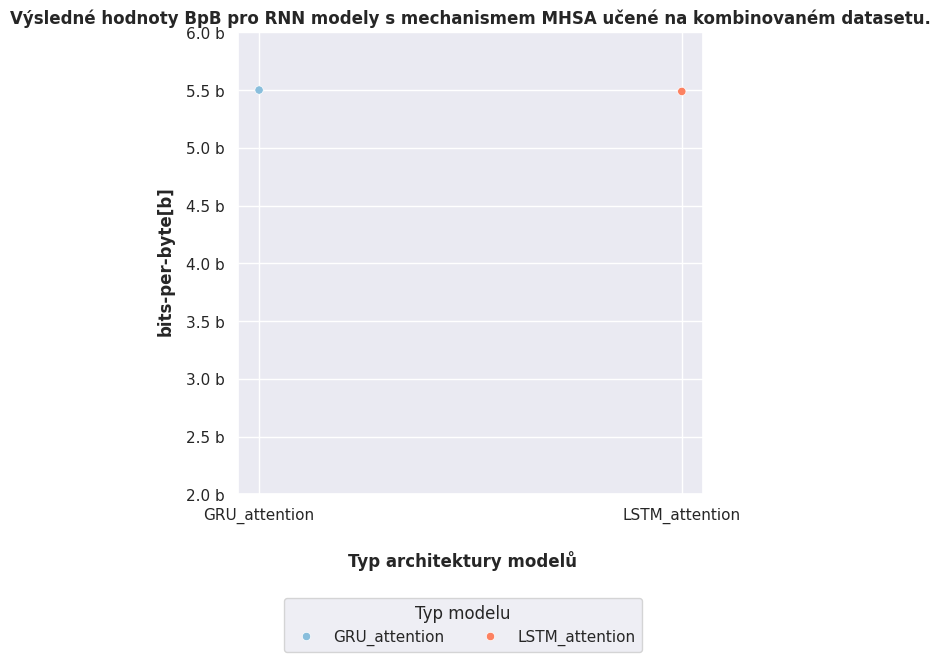

In [27]:
k_values = []
size_values = []
type_values = []
# Load results of experiments
df = load_all_results(k_values, size_values, type_values, additional_filenames=["logs/RNN_GRU_MULTI_HEAD_ATTENTION_COMBINED_log_k7_1.7MB.txt", "logs/RNN_LSTM_MULTI_HEAD_ATTENTION_COMBINED_log_k7_1.7MB.txt"])
print(df.shape)
# Create figure
fig, ax = plt.subplots(1, 1, figsize=(6,6),)

order = {'LSTM': 0, 'LSTM_attention': 1, 'GRU': 2, 'GRU_attention': 3}


# Create boxplots with hue parameter using Seaborn
sns.scatterplot(x='ModelType', y='BitsPerByte[b]', hue='ModelType', data=df, ax=ax, legend=True, palette=hue_colors)

# Set X axis formater to show the value in KB
ax.yaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, _: f"{np.round(x, 1)} b"))
ax.grid(True)

ax.legend().set_visible(False)

# Remove x and y axis labels
ax.set_xlabel('')
ax.set_ylabel('')

ax.set_ylim((2, 6))
# Set title of figure
ax.set_title(f'Výsledné hodnoty BpB pro RNN modely s mechanismem MHSA učené na kombinovaném datasetu.', fontweight='bold')

# Optionally, set common labels
fig.text(0.5, -0.01, 'Typ architektury modelů', ha='center', fontweight='bold')
fig.text(-0.01, 0.5, 'bits-per-byte[b]', va='center', rotation='vertical', fontweight='bold')

# Create a shared legend
handles, labels = ax.get_legend_handles_labels()
fig.legend(title="Typ modelu", handles=handles, labels=labels, loc='upper center', bbox_to_anchor=(0.5, -0.05), ncol=2)

# Save the plot as a PDF file
plt.savefig('images/05-xx.pdf', format='pdf', bbox_inches='tight')
# Show the plot
plt.show()

#### RNN-GRU, Homogenous

##### RNN-GRU, 1MB, Batch Size = 1024, Epochs = 10

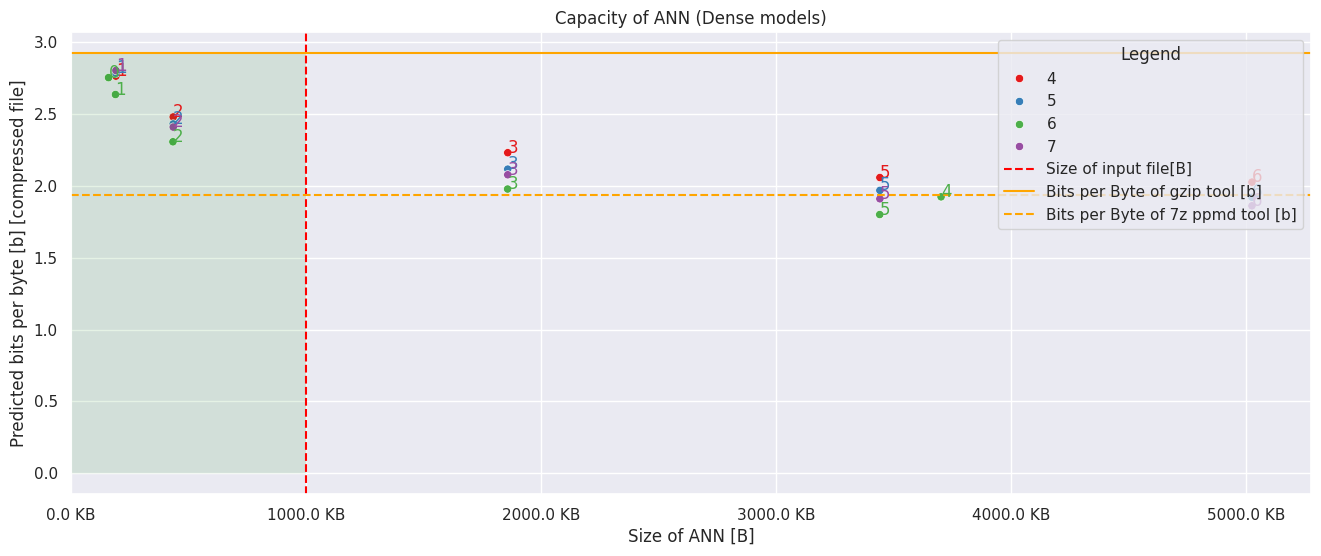

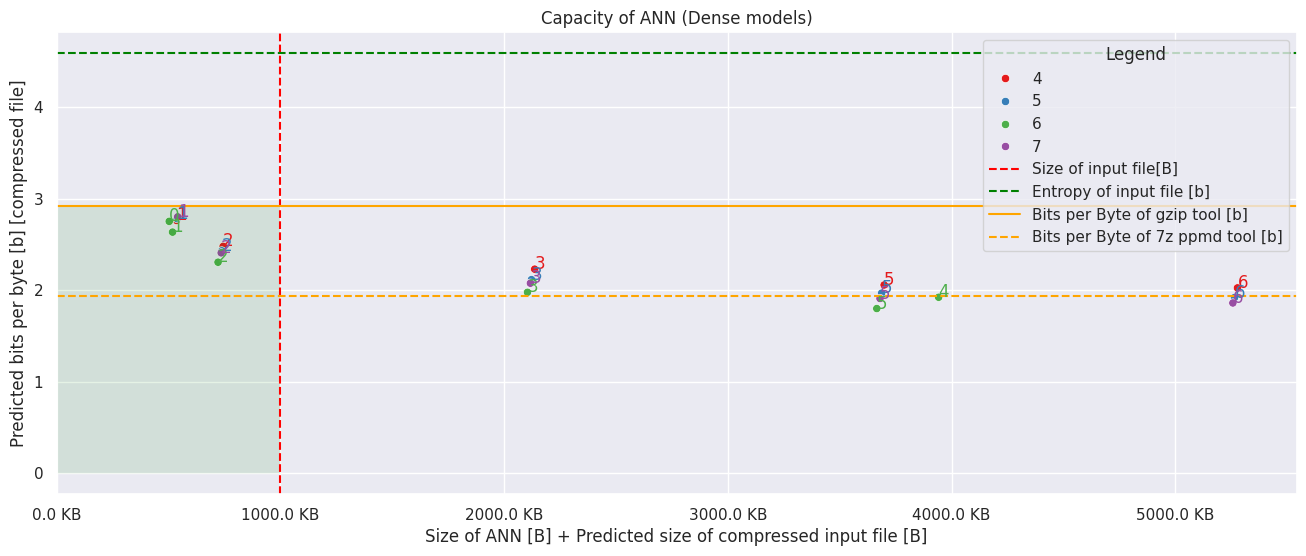

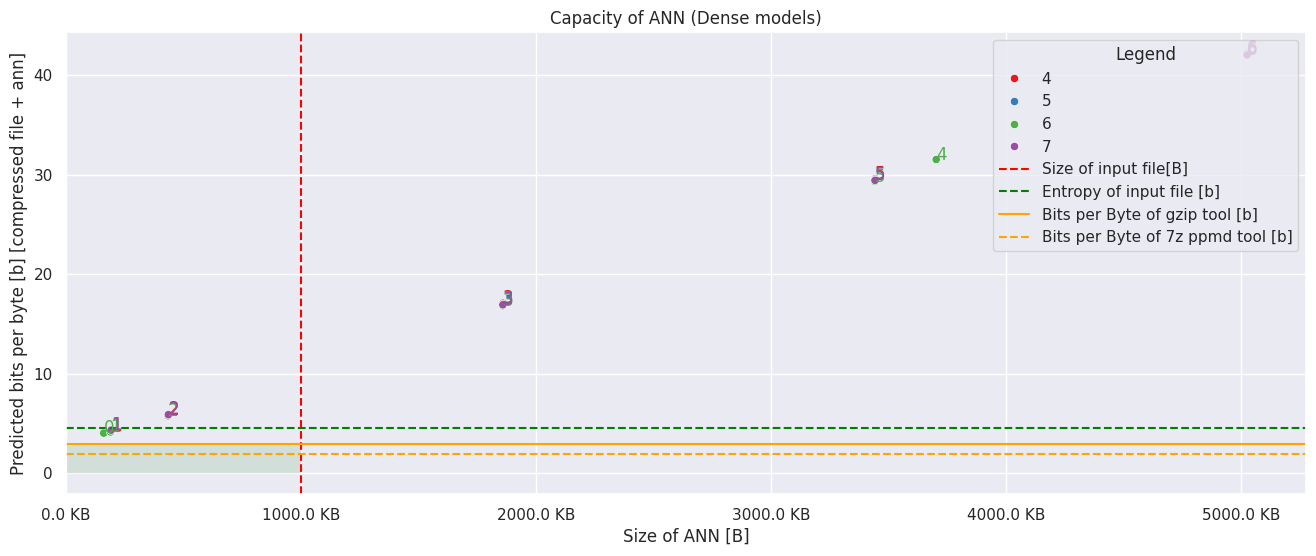

In [253]:
df = load_results([ r"./logs/RNN_GRU_log_k4_1MB.txt", r"./logs/RNN_GRU_log_k5_1MB.txt", r"./logs/RNN_GRU_log_k6_1MB.txt", r"./logs/RNN_GRU_log_k7_1MB.txt"])
input_file_size_in_bits = 8_000_000
gzip_bits_per_byte = 2.9224
sevenzip_bits_per_byte = 1.9384
entropy_of_file = 4.590017983378693

plot_capacity_of_ann_only_model_size(df, input_file_size_in_bits, gzip_bits_per_byte, sevenzip_bits_per_byte)
plot_capacity_of_ann(df, input_file_size_in_bits, gzip_bits_per_byte, sevenzip_bits_per_byte, entropy_of_file)
plot_capacity_of_ann_y_all(df, input_file_size_in_bits, gzip_bits_per_byte, sevenzip_bits_per_byte, entropy_of_file)

##### RNN-GRU, 5MB, Batch Size = 2048, Epochs = 10

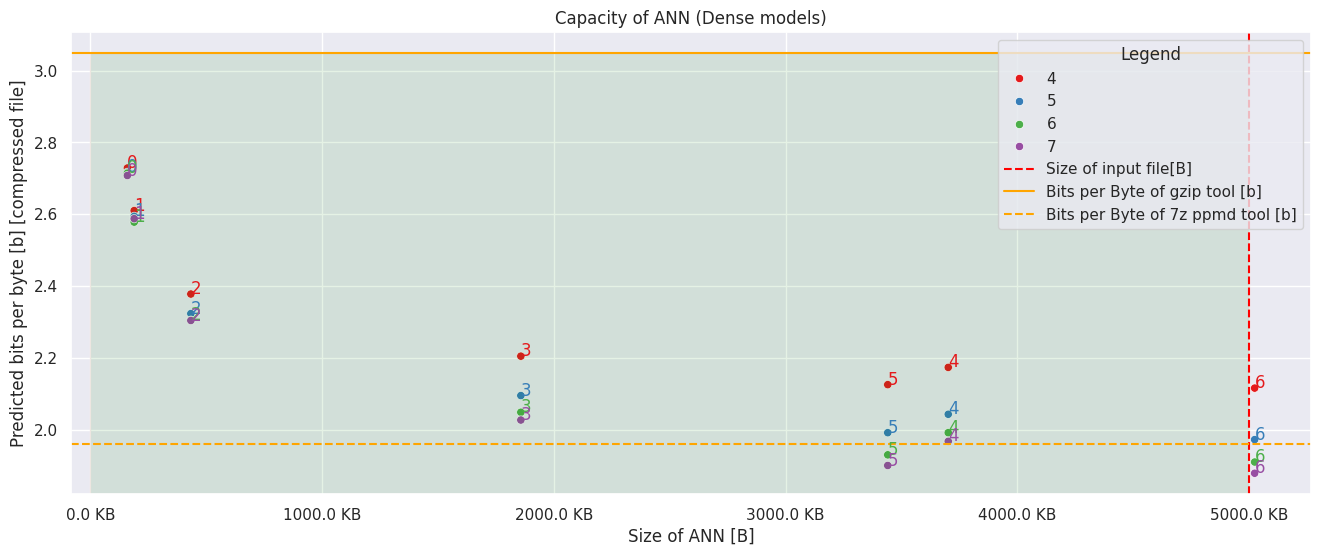

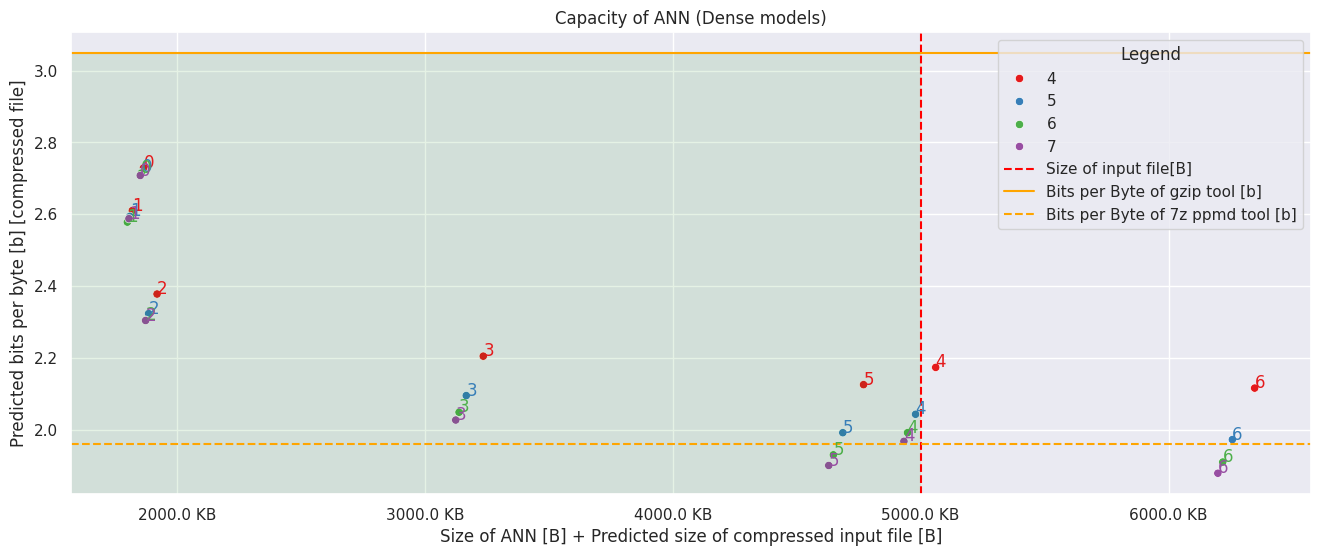

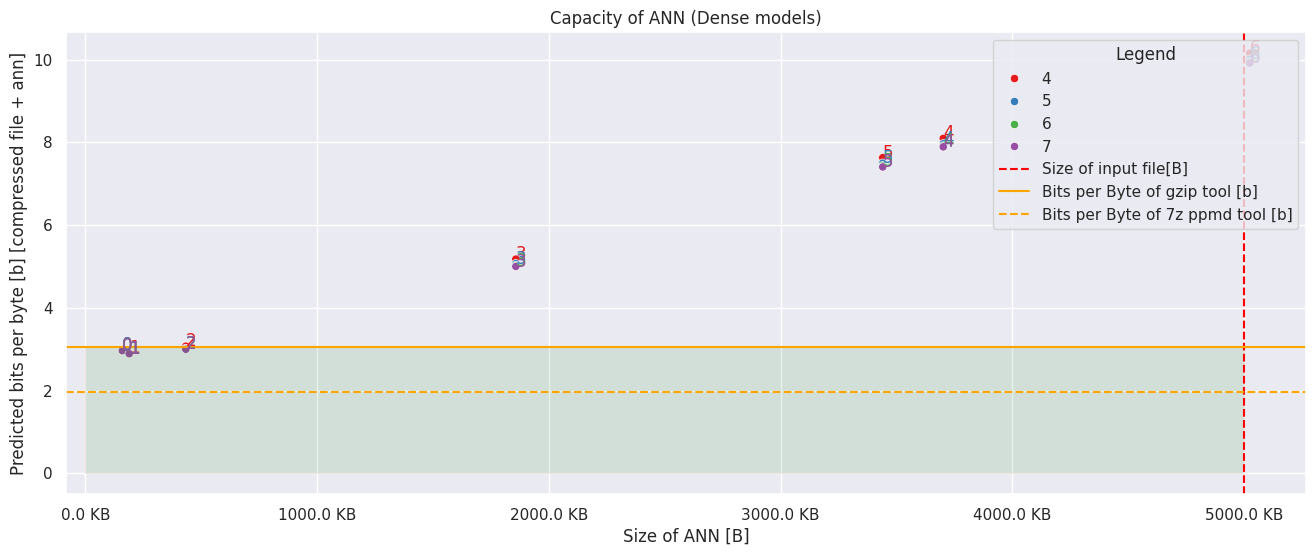

In [41]:
df = load_results([ r"./logs/RNN_GRU_log_k4_5MB.txt", r"./logs/RNN_GRU_log_k5_5MB.txt", r"./logs/RNN_GRU_log_k6_5MB.txt", r"./logs/RNN_GRU_log_k7_5MB.txt"])
input_file_size_in_bits = 40_000_000
gzip_bits_per_byte = 3.048
sevenzip_bits_per_byte = 1.96 

plot_capacity_of_ann_only_model_size(df, input_file_size_in_bits, gzip_bits_per_byte, sevenzip_bits_per_byte)
plot_capacity_of_ann(df, input_file_size_in_bits, gzip_bits_per_byte, sevenzip_bits_per_byte, )
plot_capacity_of_ann_y_all(df, input_file_size_in_bits, gzip_bits_per_byte, sevenzip_bits_per_byte, )

##### RNN-GRU, 10MB, Batch Size = 1024, Epochs = 10

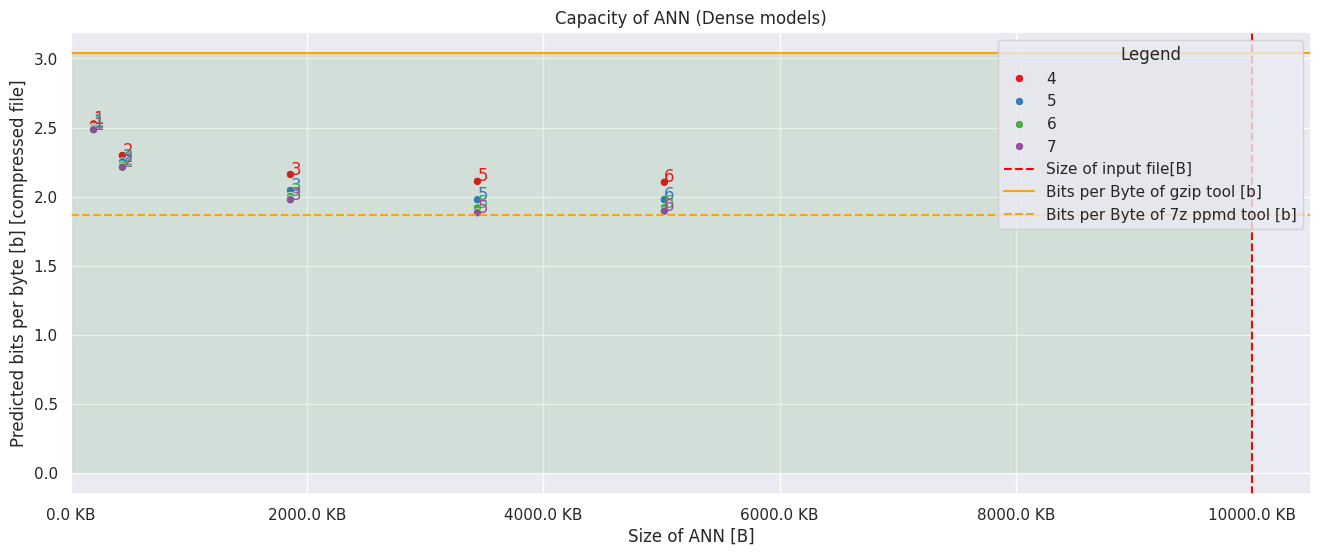

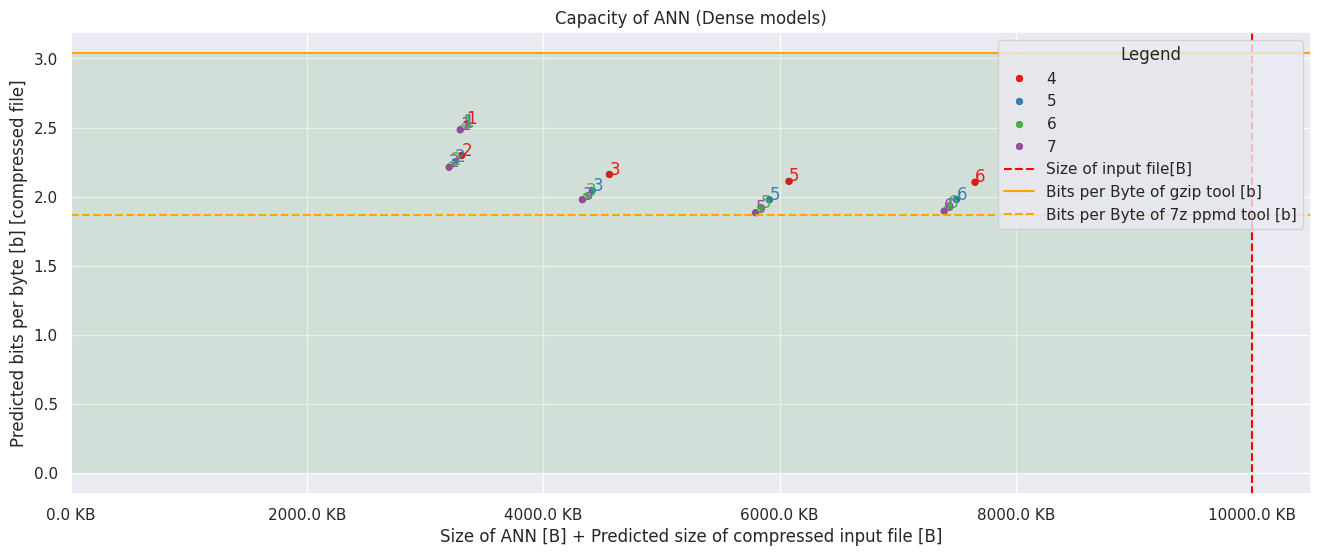

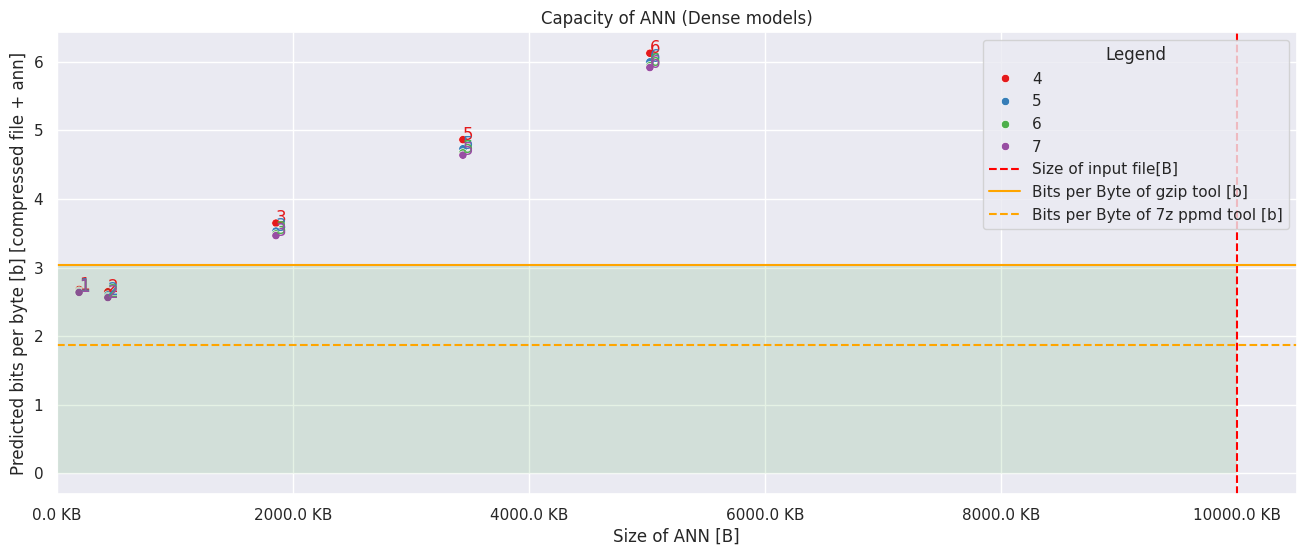

In [254]:
df = load_results([ r"./logs/RNN_GRU_log_k4_10MB.txt", r"./logs/RNN_GRU_log_k5_10MB.txt", r"./logs/RNN_GRU_log_k6_10MB.txt", r"./logs/RNN_GRU_log_k7_10MB.txt"])
input_file_size_in_bits = 80_000_000
gzip_bits_per_byte = 3.0376
sevenzip_bits_per_byte = 1.8696

plot_capacity_of_ann_only_model_size(df, input_file_size_in_bits, gzip_bits_per_byte, sevenzip_bits_per_byte)
plot_capacity_of_ann(df, input_file_size_in_bits, gzip_bits_per_byte, sevenzip_bits_per_byte,)
plot_capacity_of_ann_y_all(df, input_file_size_in_bits, gzip_bits_per_byte, sevenzip_bits_per_byte,)

#### RNN-LSTM, Homogenous

##### RNN-LSTM, 1MB, Batch Size = 1024, Epochs = 10

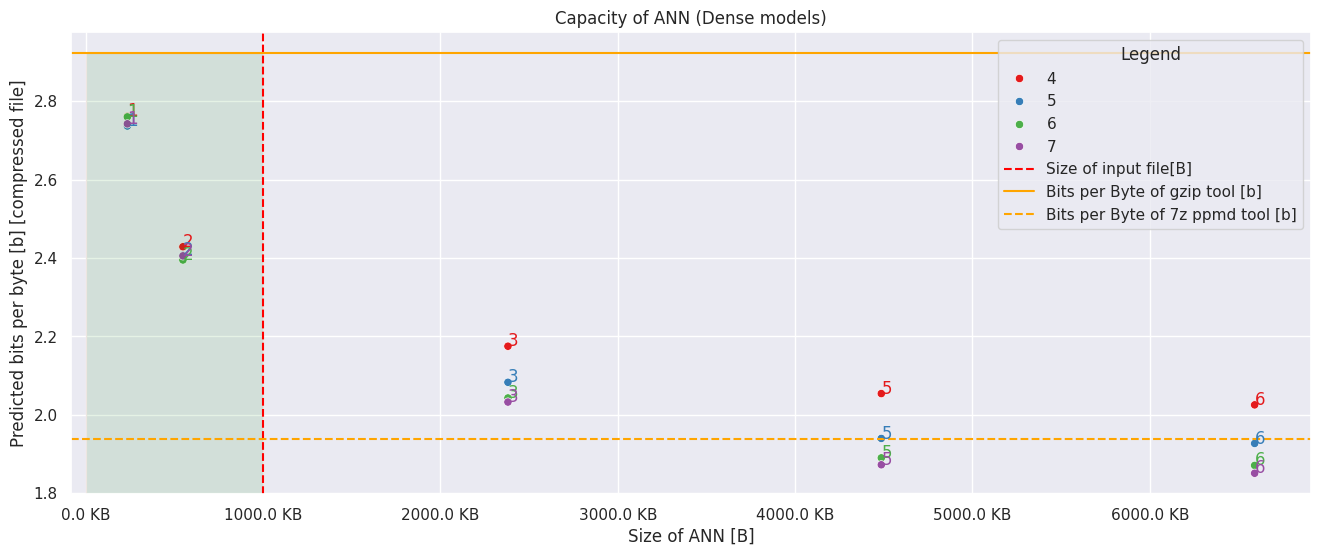

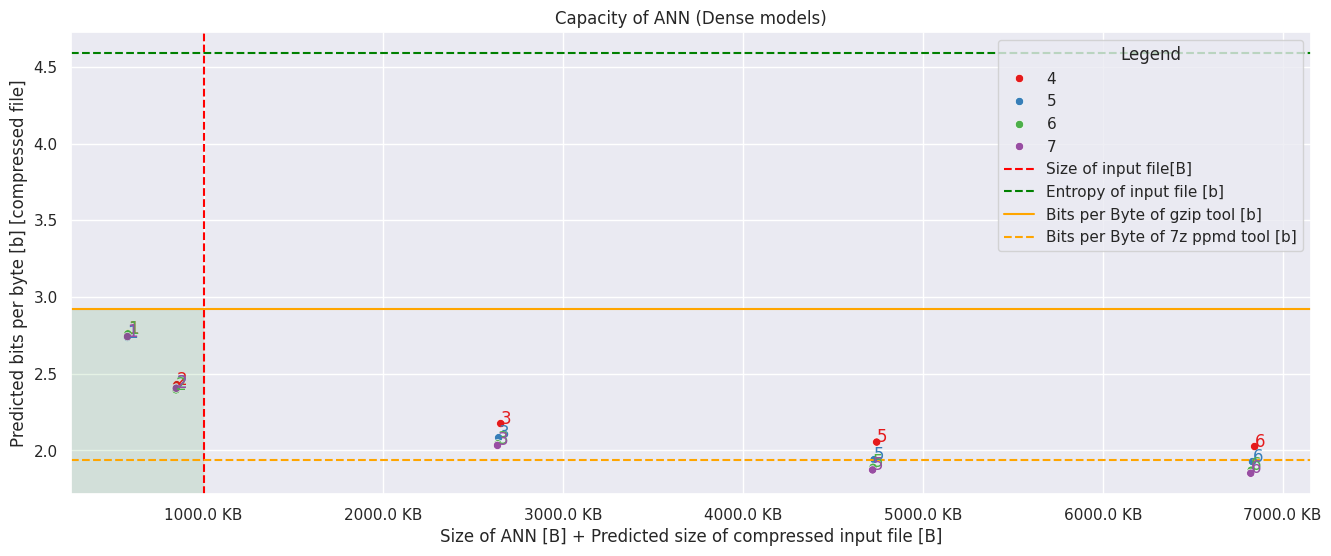

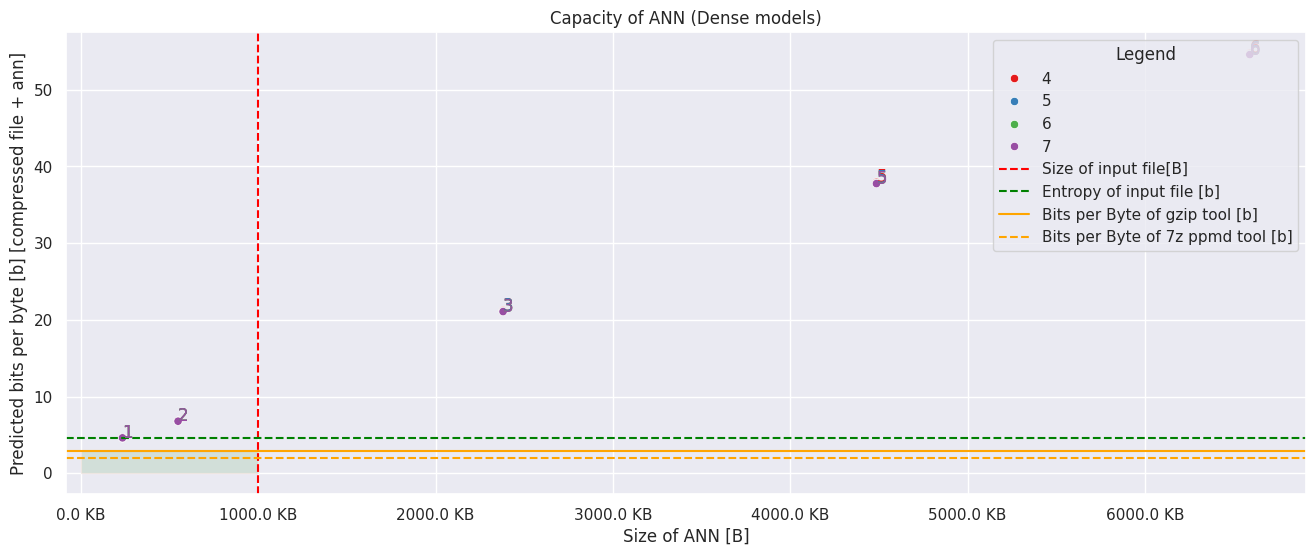

In [28]:
df = load_results([ r"./logs/RNN_LSTM_log_k4_1MB.txt", r"./logs/RNN_LSTM_log_k5_1MB.txt", r"./logs/RNN_LSTM_log_k6_1MB.txt", r"./logs/RNN_LSTM_log_k7_1MB.txt"])
input_file_size_in_bits = 8_000_000
gzip_bits_per_byte = 2.9224
sevenzip_bits_per_byte = 1.9384
entropy_of_file = 4.590017983378693

plot_capacity_of_ann_only_model_size(df, input_file_size_in_bits, gzip_bits_per_byte, sevenzip_bits_per_byte)
plot_capacity_of_ann(df, input_file_size_in_bits, gzip_bits_per_byte, sevenzip_bits_per_byte, entropy_of_file)
plot_capacity_of_ann_y_all(df, input_file_size_in_bits, gzip_bits_per_byte, sevenzip_bits_per_byte, entropy_of_file)

##### RNN-LSTM, 5MB, Batch Size = 1024, Epochs = 10

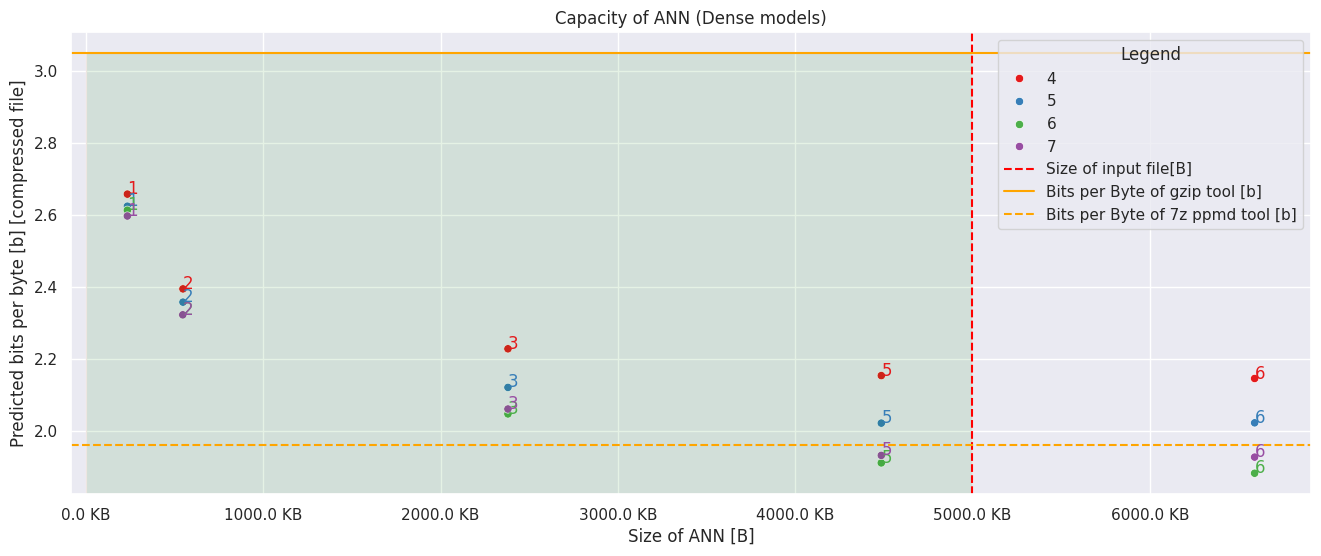

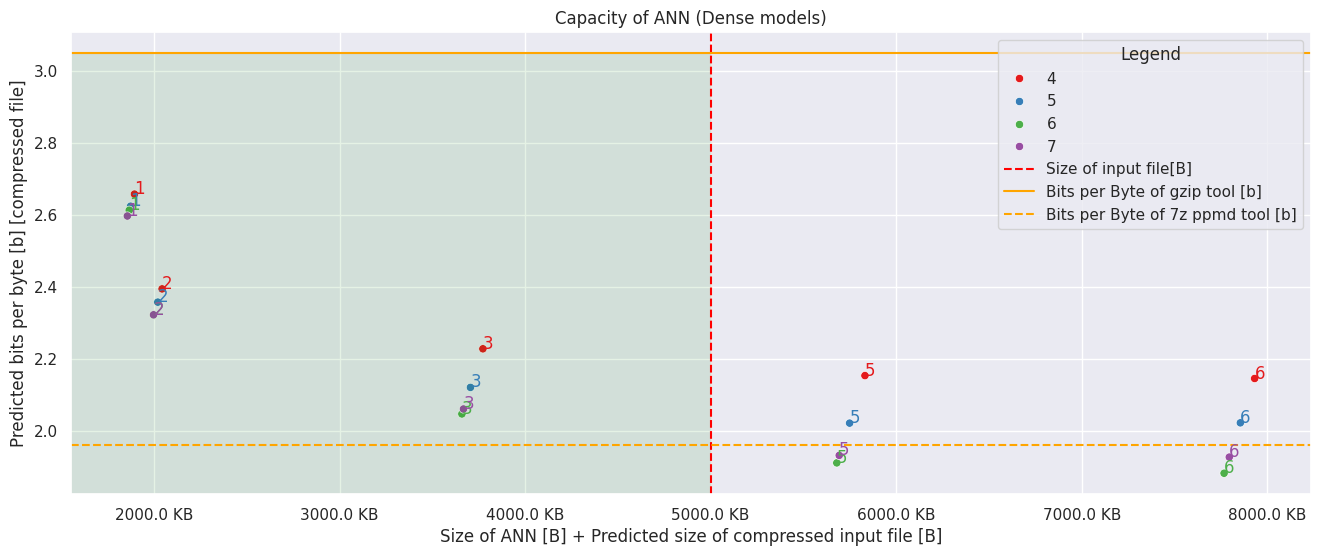

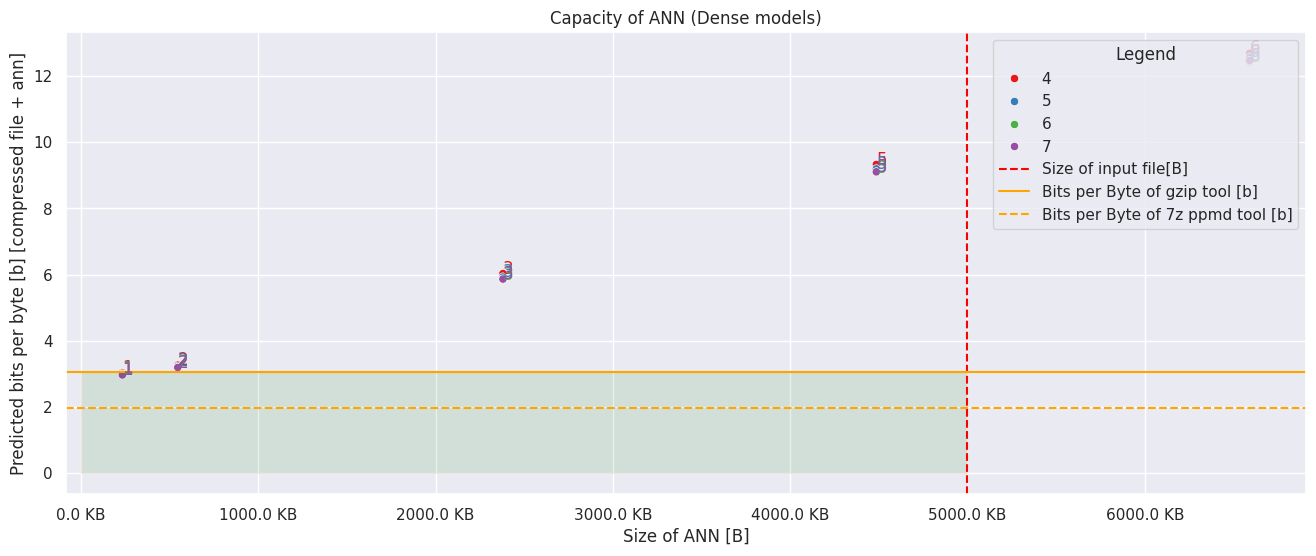

In [39]:
df = load_results([ r"./logs/RNN_LSTM_log_k4_5MB.txt", r"./logs/RNN_LSTM_log_k5_5MB.txt", r"./logs/RNN_LSTM_log_k6_5MB.txt", r"./logs/RNN_LSTM_log_k7_5MB.txt"])
input_file_size_in_bits = 40_000_000
gzip_bits_per_byte = 3.048
sevenzip_bits_per_byte = 1.96 

plot_capacity_of_ann_only_model_size(df, input_file_size_in_bits, gzip_bits_per_byte, sevenzip_bits_per_byte)
plot_capacity_of_ann(df, input_file_size_in_bits, gzip_bits_per_byte, sevenzip_bits_per_byte, )
plot_capacity_of_ann_y_all(df, input_file_size_in_bits, gzip_bits_per_byte, sevenzip_bits_per_byte, )

##### RNN-LSTM, 10MB, Batch Size = 1024, Epochs = 10

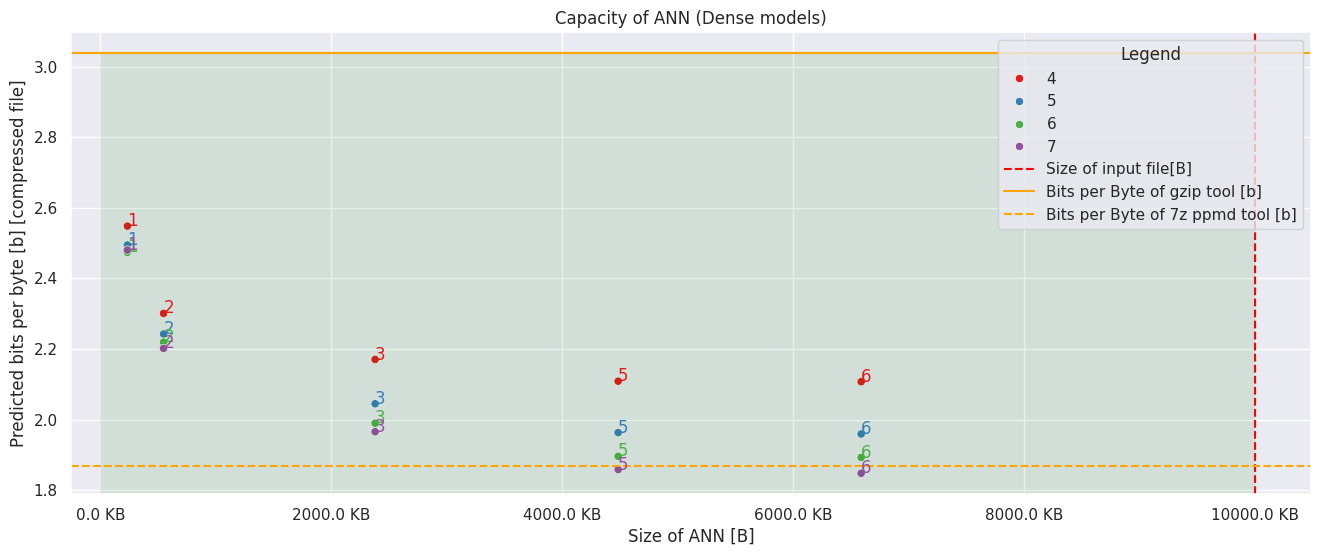

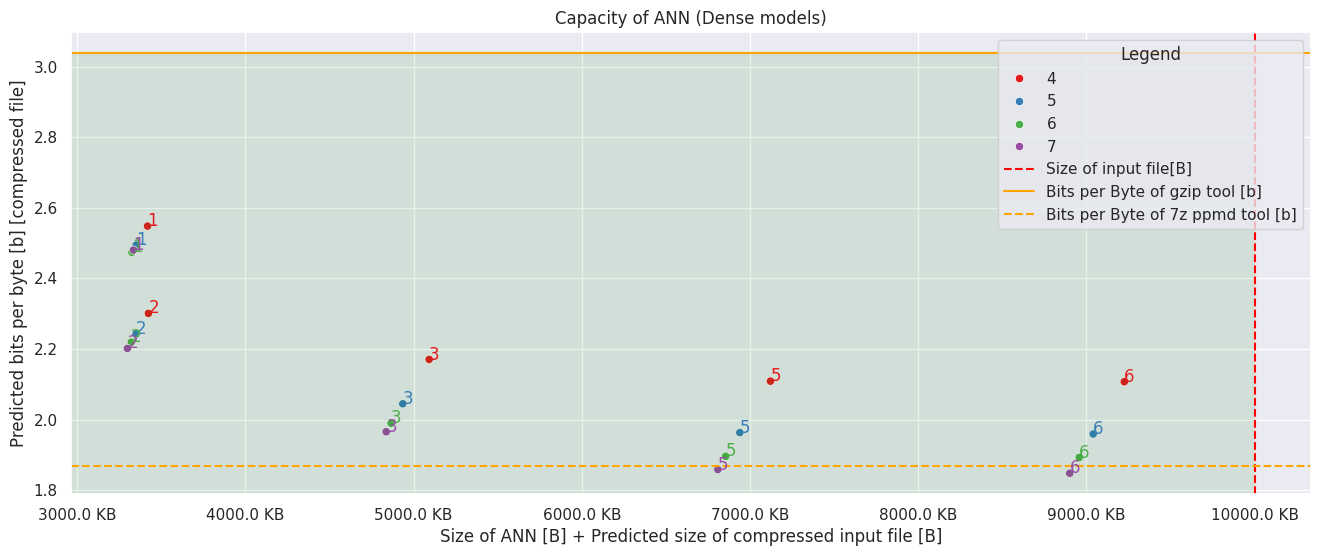

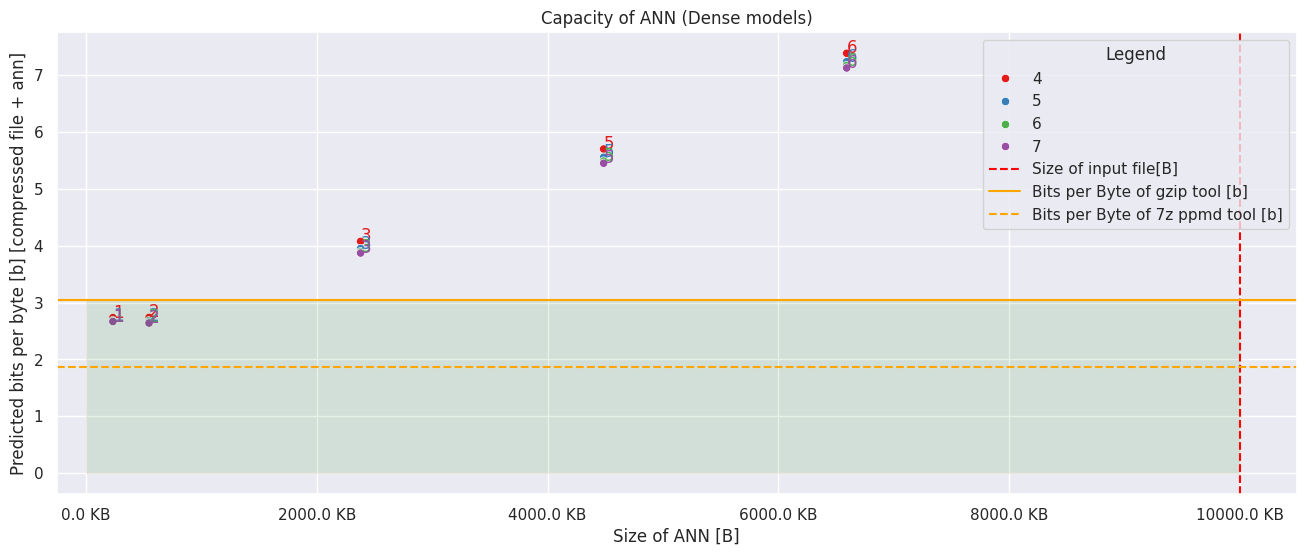

In [38]:
df = load_results([ r"./logs/RNN_LSTM_log_k4_10MB.txt", r"./logs/RNN_LSTM_log_k5_10MB.txt", r"./logs/RNN_LSTM_log_k6_10MB.txt", r"./logs/RNN_LSTM_log_k7_10MB.txt"])
input_file_size_in_bits = 80_000_000
gzip_bits_per_byte = 3.0376
sevenzip_bits_per_byte = 1.8696

plot_capacity_of_ann_only_model_size(df, input_file_size_in_bits, gzip_bits_per_byte, sevenzip_bits_per_byte)
plot_capacity_of_ann(df, input_file_size_in_bits, gzip_bits_per_byte, sevenzip_bits_per_byte, )
plot_capacity_of_ann_y_all(df, input_file_size_in_bits, gzip_bits_per_byte, sevenzip_bits_per_byte, )

#### DNN, Homogenous

##### DNN, 1MB, Batch Size = 64, Epochs = 10

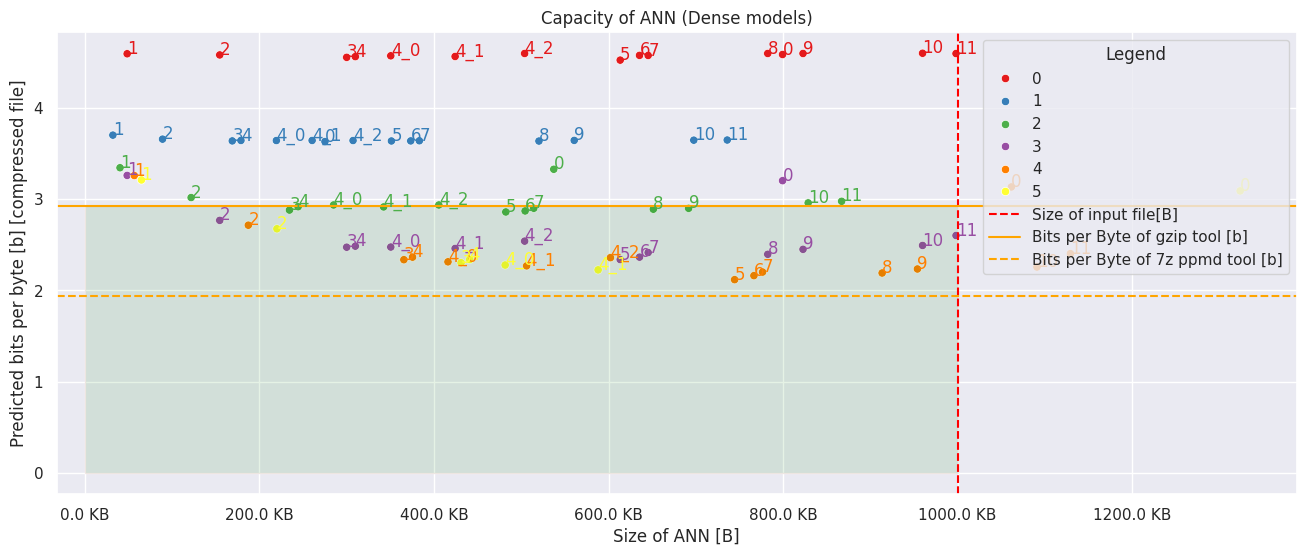

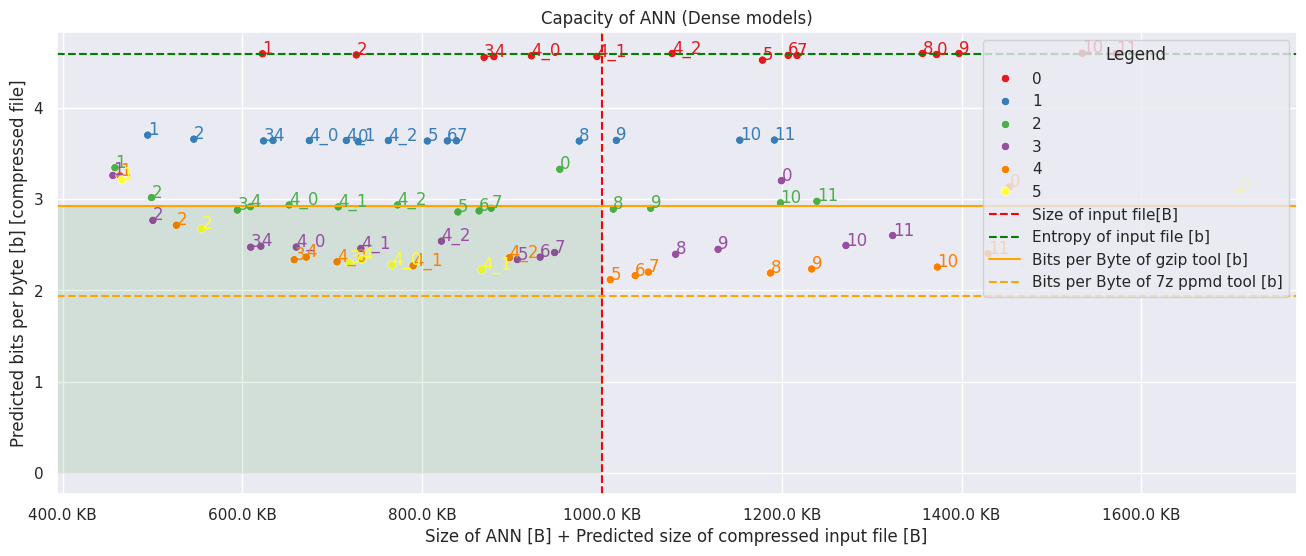

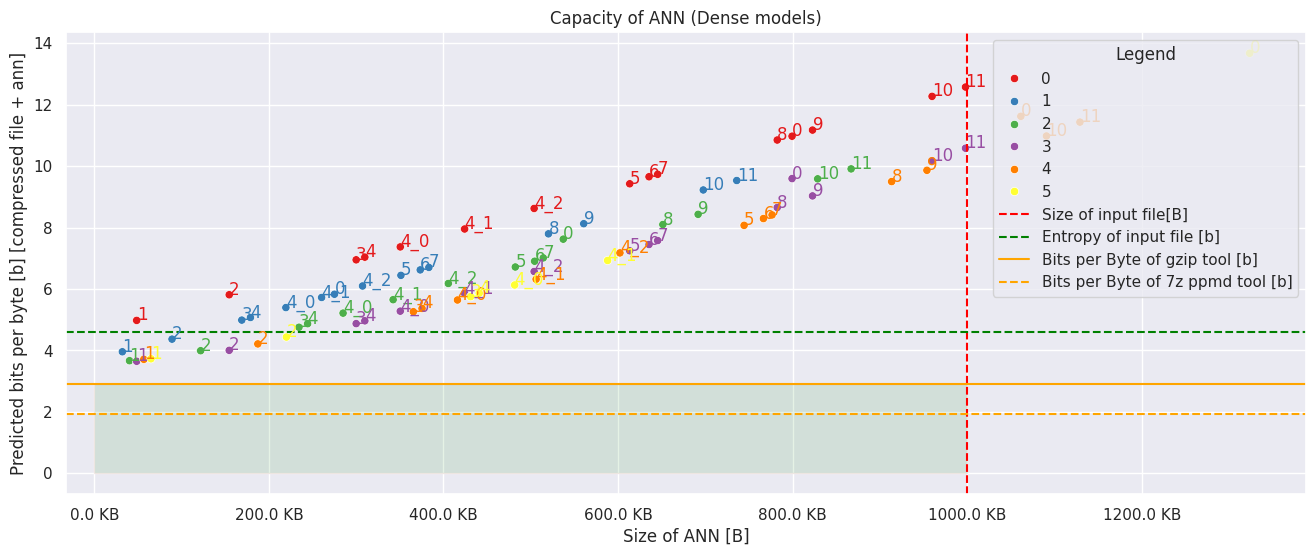

In [36]:
df = load_results([ r"./logs/DNN_log_k0_1MB.txt", r"./logs/DNN_log_k1_1MB.txt", r"./logs/DNN_log_k2_1MB.txt", r"./logs/DNN_log_k3_1MB.txt",  r"./logs/DNN_log_k4_1MB.txt",  r"./logs/DNN_log_k5_1MB.txt"])
input_file_size_in_bits = 8_000_000
gzip_bits_per_byte = 2.9224
sevenzip_bits_per_byte = 1.9384
entropy_of_file = 4.590017983378693

plot_capacity_of_ann_only_model_size(df, input_file_size_in_bits, gzip_bits_per_byte, sevenzip_bits_per_byte)
plot_capacity_of_ann(df, input_file_size_in_bits, gzip_bits_per_byte, sevenzip_bits_per_byte, entropy_of_file)
plot_capacity_of_ann_y_all(df, input_file_size_in_bits, gzip_bits_per_byte, sevenzip_bits_per_byte, entropy_of_file)

##### DNN, 5MB, Batch Size = 128, Epochs = 10

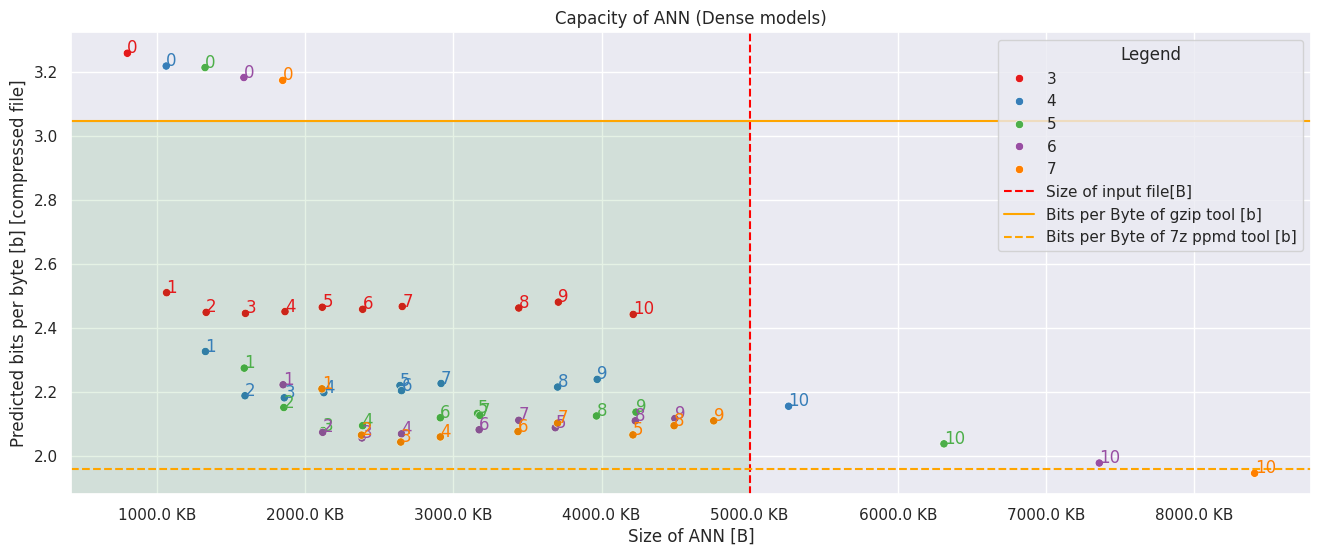

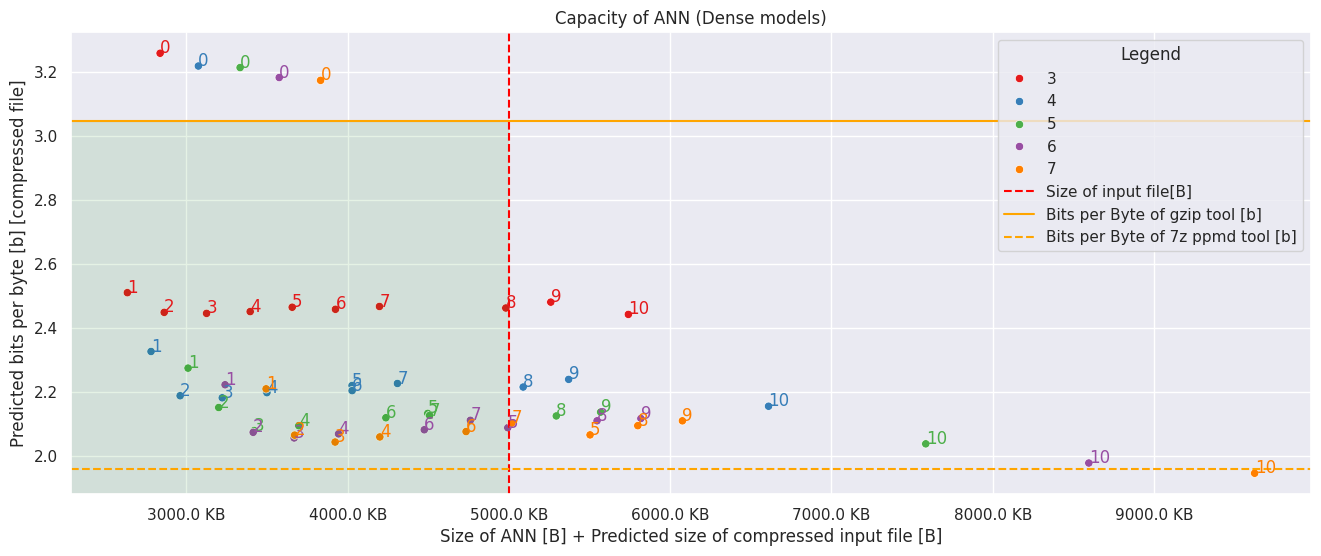

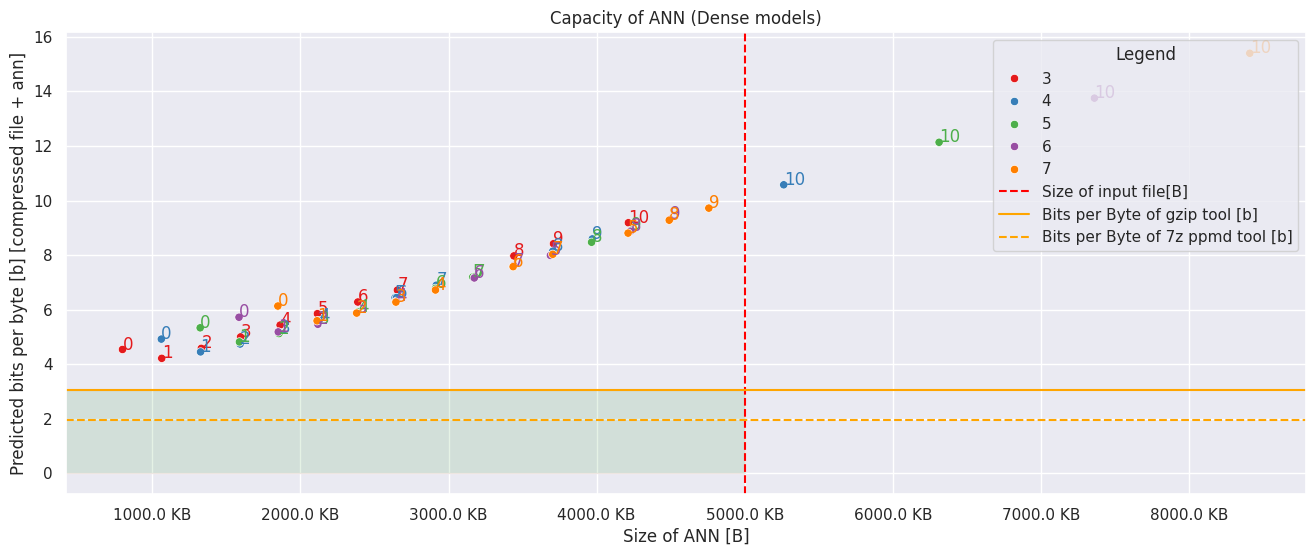

In [37]:
df = load_results([ r"./logs/DNN_log_k3_5MB.txt",  r"./logs/DNN_log_k4_5MB.txt",  r"./logs/DNN_log_k5_5MB.txt", r"./logs/DNN_log_k6_5MB.txt", r"./logs/DNN_log_k7_5MB.txt"])
input_file_size_in_bits = 40_000_000
gzip_bits_per_byte = 3.048
sevenzip_bits_per_byte = 1.96 

plot_capacity_of_ann_only_model_size(df, input_file_size_in_bits, gzip_bits_per_byte, sevenzip_bits_per_byte)
plot_capacity_of_ann(df, input_file_size_in_bits, gzip_bits_per_byte, sevenzip_bits_per_byte, )
plot_capacity_of_ann_y_all(df, input_file_size_in_bits, gzip_bits_per_byte, sevenzip_bits_per_byte, )

##### DNN, 10MB, Batch Size = 128, Epochs = 10

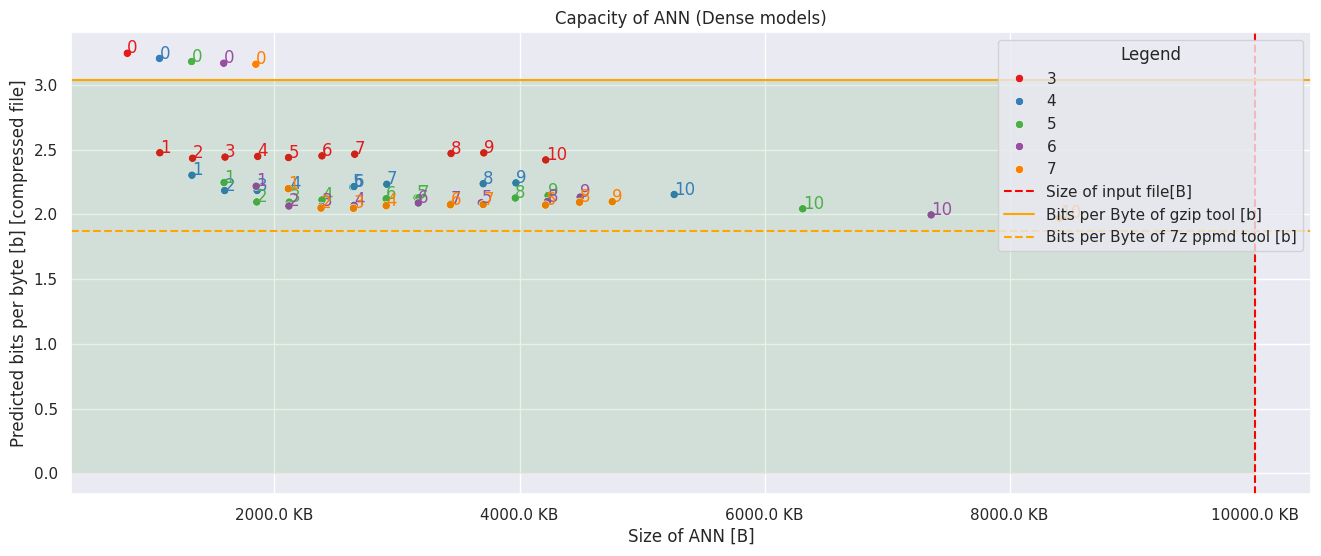

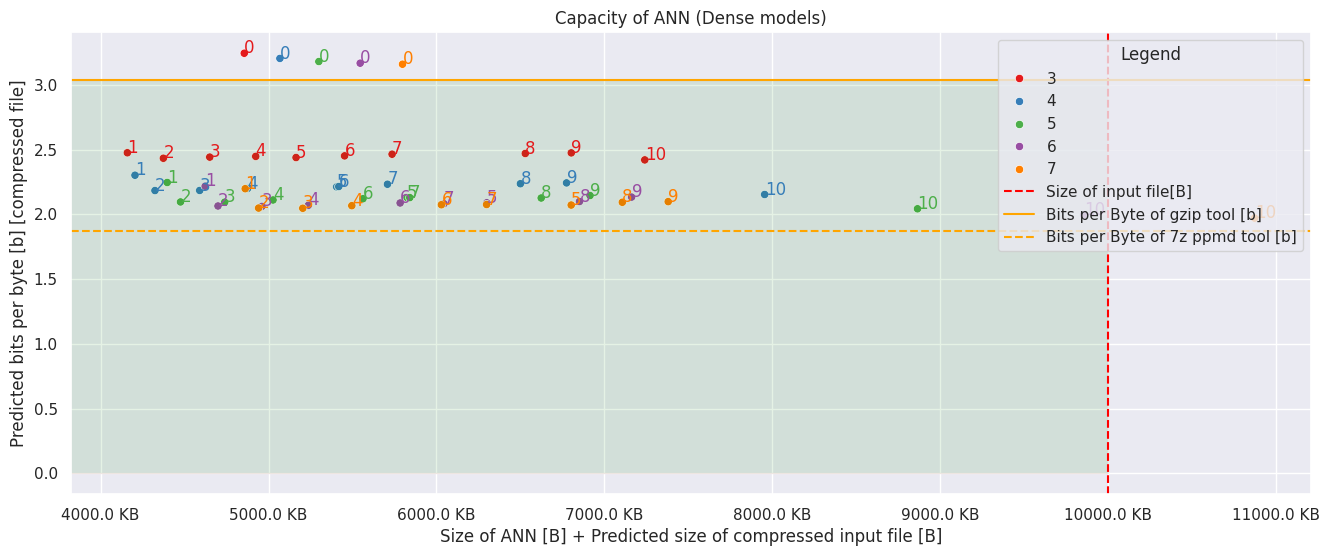

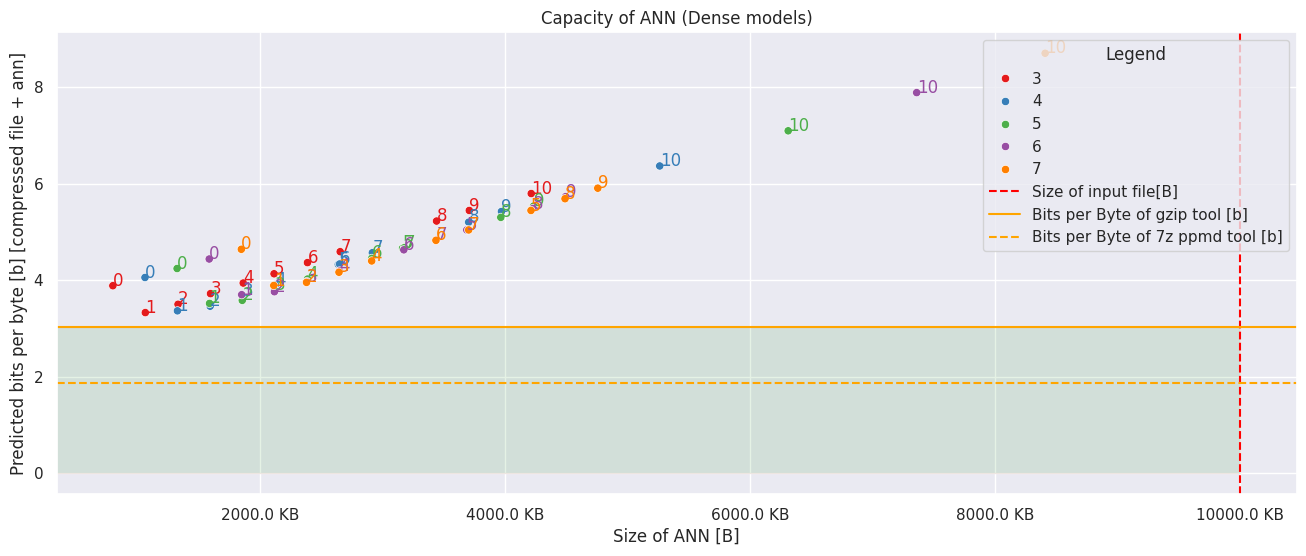

In [43]:
df = load_results([ r"./logs/DNN_log_k3_10MB.txt",  r"./logs/DNN_log_k4_10MB.txt",  r"./logs/DNN_log_k5_10MB.txt", r"./logs/DNN_log_k6_10MB.txt", r"./logs/DNN_log_k7_10MB.txt"])
input_file_size_in_bits = 80_000_000
gzip_bits_per_byte = 3.0376
sevenzip_bits_per_byte = 1.8696

plot_capacity_of_ann_only_model_size(df, input_file_size_in_bits, gzip_bits_per_byte, sevenzip_bits_per_byte)
plot_capacity_of_ann(df, input_file_size_in_bits, gzip_bits_per_byte, sevenzip_bits_per_byte, )
plot_capacity_of_ann_y_all(df, input_file_size_in_bits, gzip_bits_per_byte, sevenzip_bits_per_byte, )

#### RNN-GRU, Heterogenous
- k=4: 2.1616 bpB
- k=5: 2.0576 bpB
- k=6: 2.0160 bpB
- k=7: 2.0296 bpB

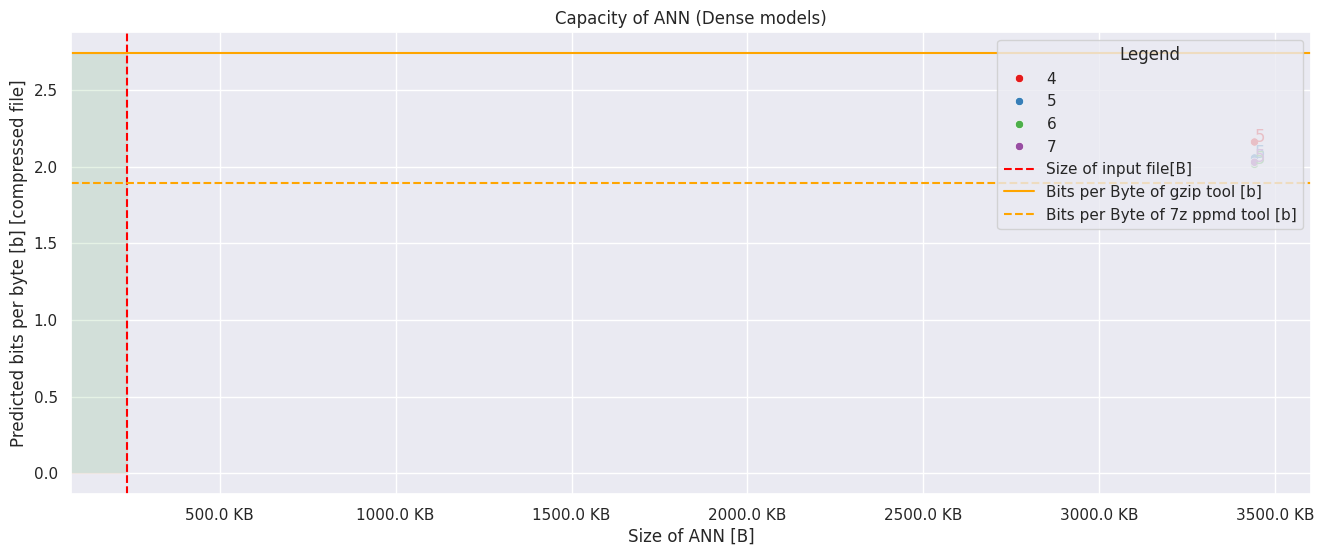

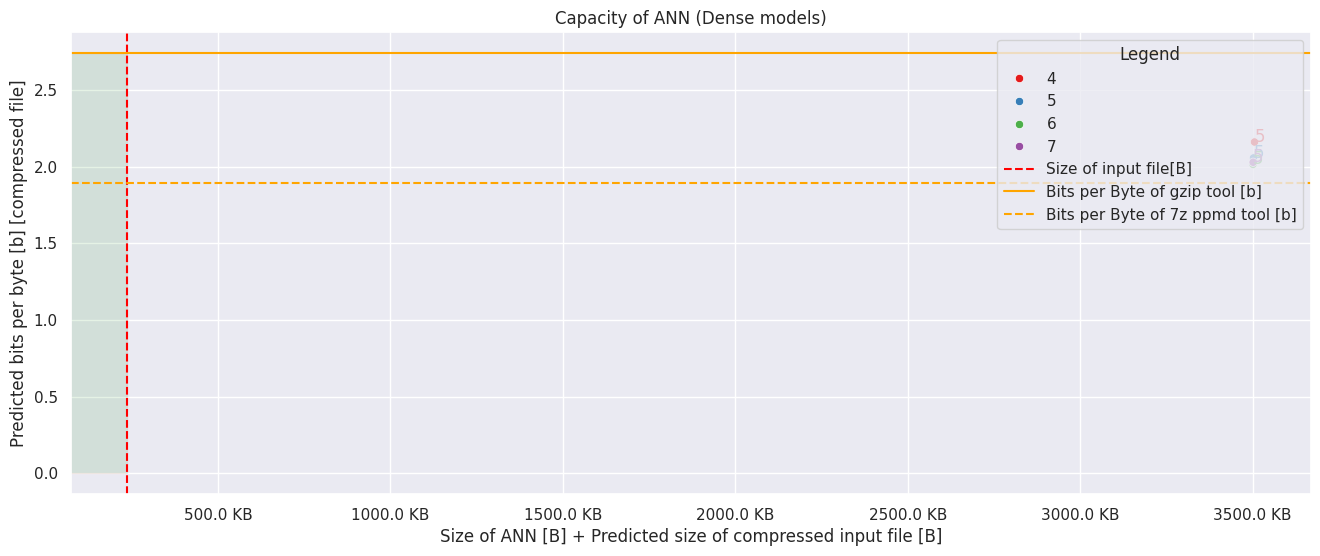

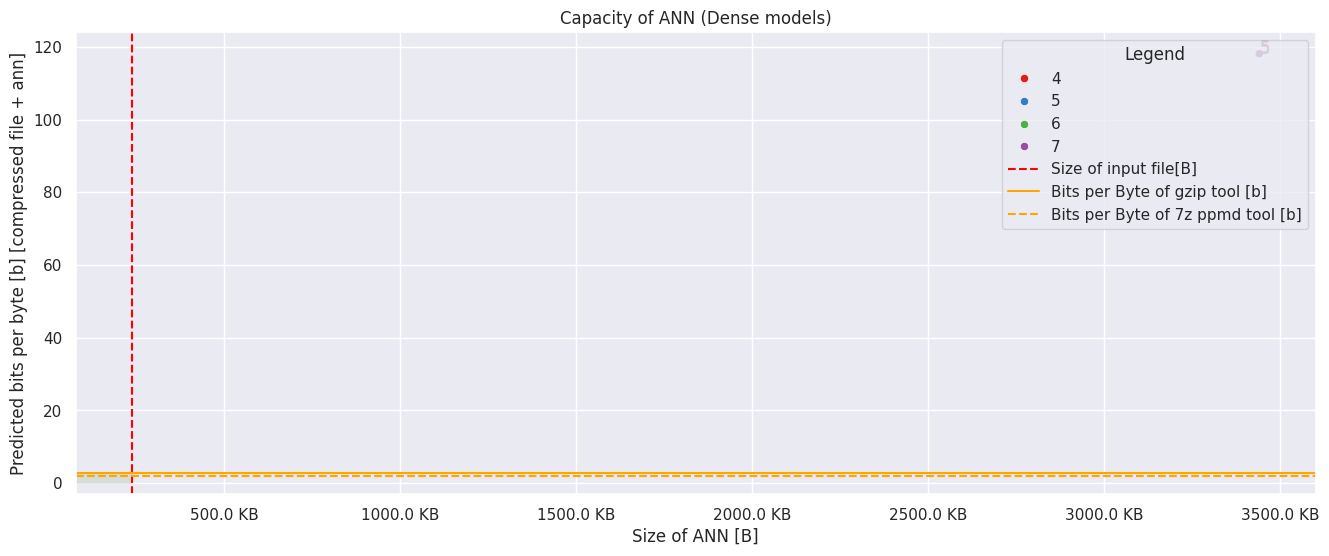

In [31]:
df = load_results([ r"./logs/heterogenous/RNN_GRU_k4.txt",  r"./logs/heterogenous/RNN_GRU_k5.txt",  r"./logs/heterogenous/RNN_GRU_k6.txt", r"./logs/heterogenous/RNN_GRU_k7.txt"])
input_file_size_in_bits = 1_897_672
gzip_bits_per_byte = 2.7408
sevenzip_bits_per_byte = 1.8932839816364473

plot_capacity_of_ann_only_model_size(df, input_file_size_in_bits, gzip_bits_per_byte, sevenzip_bits_per_byte)
plot_capacity_of_ann(df, input_file_size_in_bits, gzip_bits_per_byte, sevenzip_bits_per_byte, )
plot_capacity_of_ann_y_all(df, input_file_size_in_bits, gzip_bits_per_byte, sevenzip_bits_per_byte, )

#### RNN-LSTM, Heterogenous
- k=4: 2.1736 bpB
- k=5: 2.1112 bpB
- k=6: 2.0480 bpB
- k=7: 2.0504 bpB

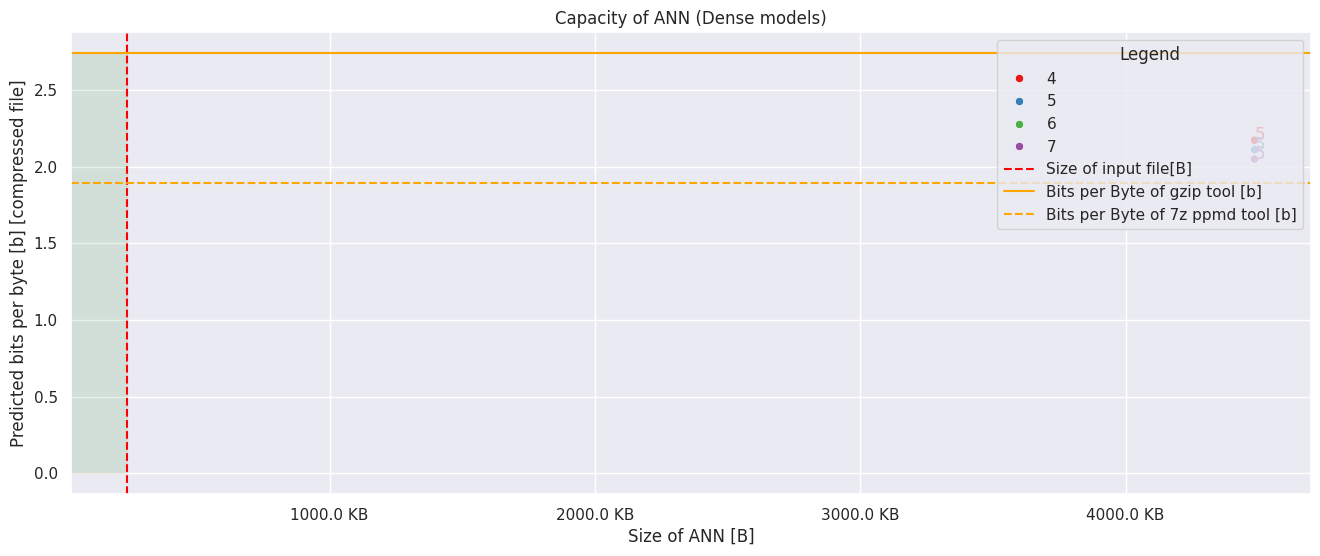

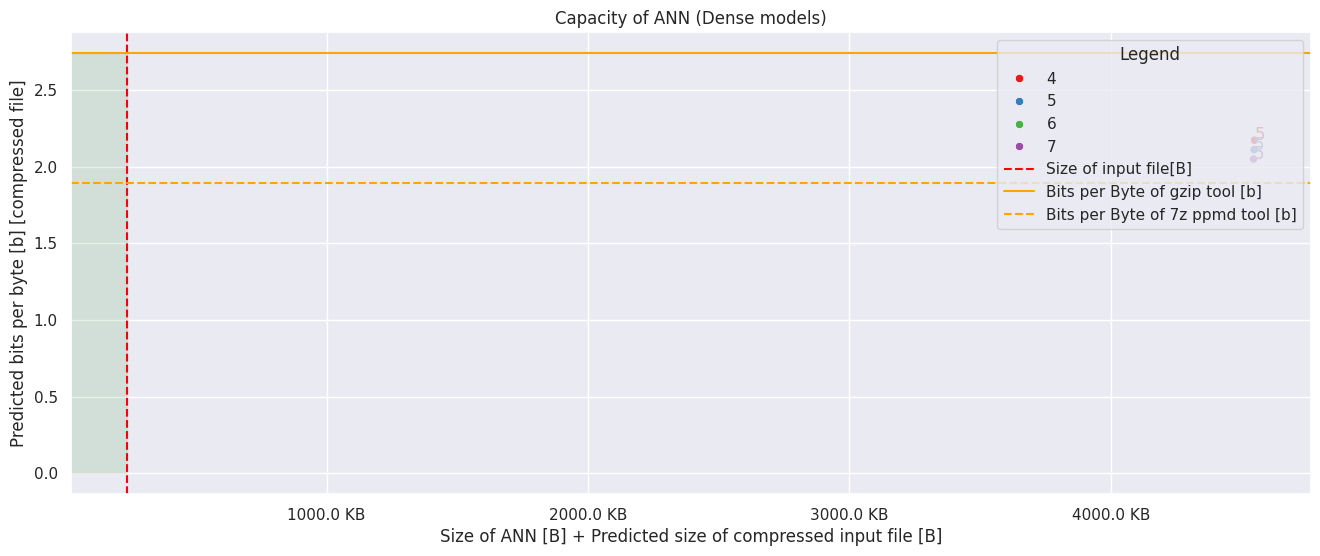

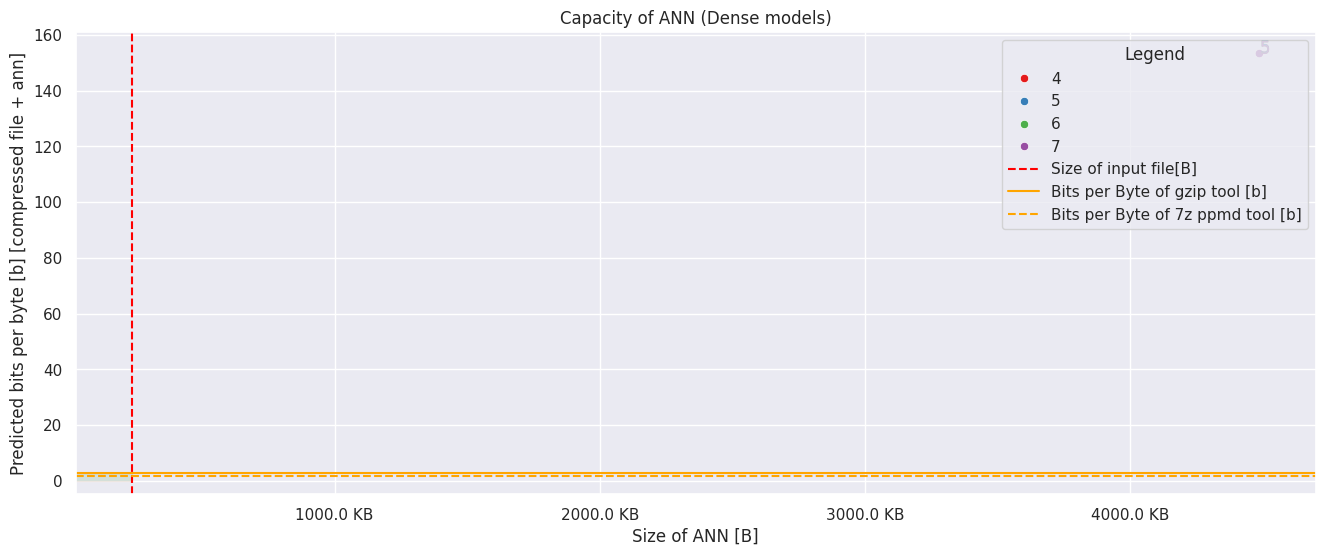

In [32]:
df = load_results([ r"./logs/heterogenous/RNN_LSTM_k4.txt",  r"./logs/heterogenous/RNN_LSTM_k5.txt",  r"./logs/heterogenous/RNN_LSTM_k6.txt", r"./logs/heterogenous/RNN_LSTM_k7.txt"])
input_file_size_in_bits = 1_897_672
gzip_bits_per_byte = 2.7408
sevenzip_bits_per_byte = 1.8932839816364473

plot_capacity_of_ann_only_model_size(df, input_file_size_in_bits, gzip_bits_per_byte, sevenzip_bits_per_byte)
plot_capacity_of_ann(df, input_file_size_in_bits, gzip_bits_per_byte, sevenzip_bits_per_byte, )
plot_capacity_of_ann_y_all(df, input_file_size_in_bits, gzip_bits_per_byte, sevenzip_bits_per_byte, )

#### DNN, Heterogenous
- k=4: 2.1952 bpB
- k=5: 2.1584 bpB
- k=6: 2.1496 bpB
- k=7: 2.1304 bpB

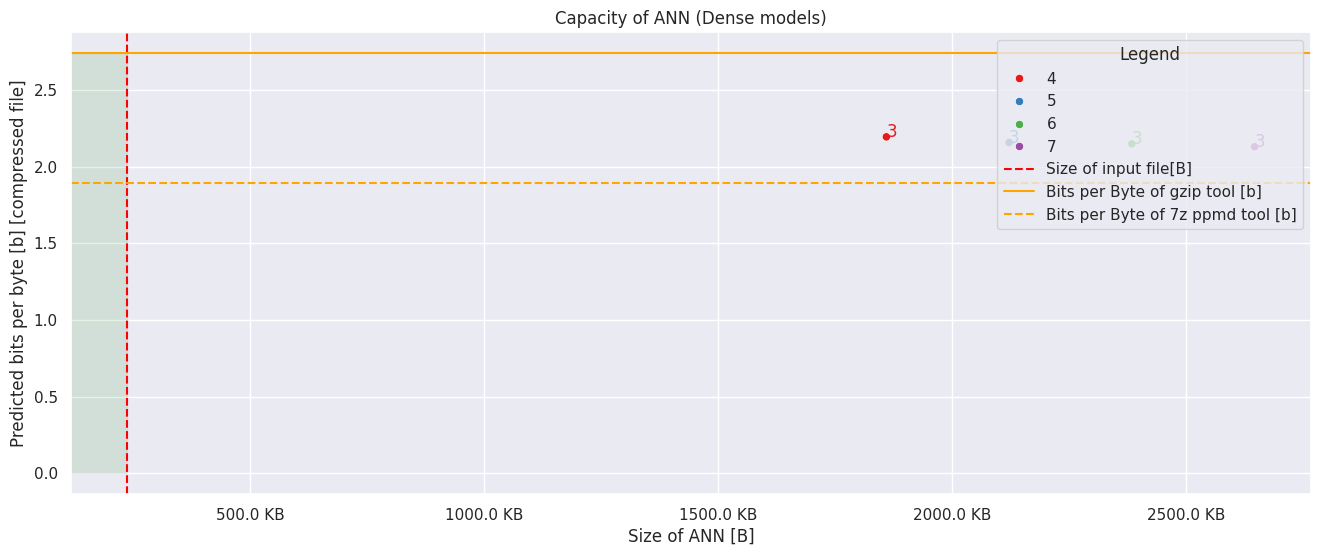

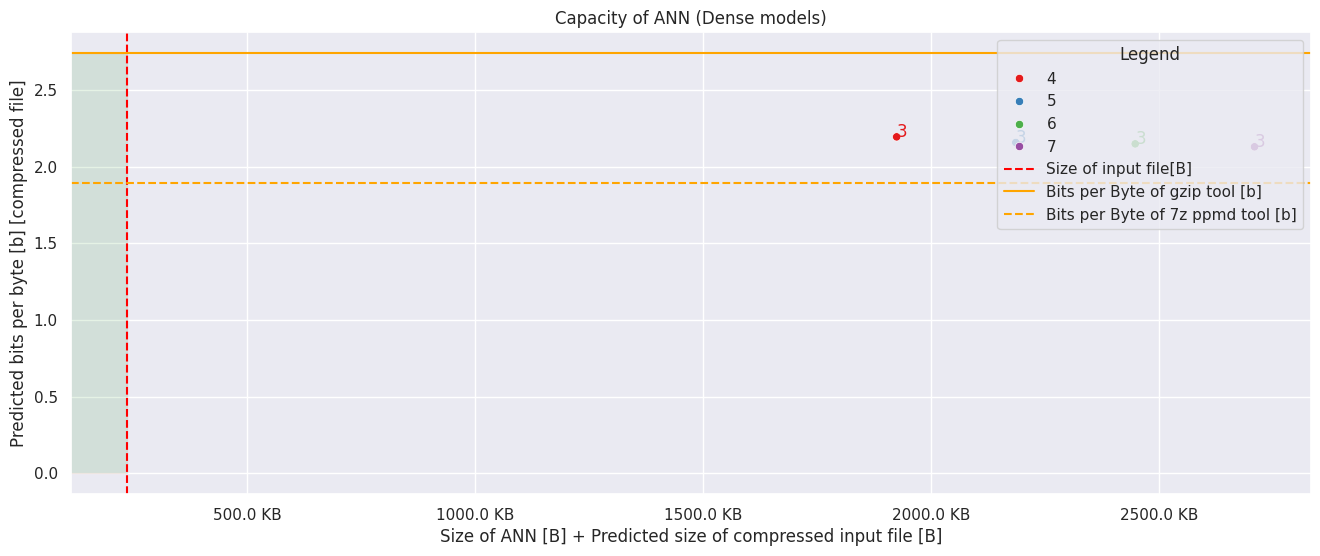

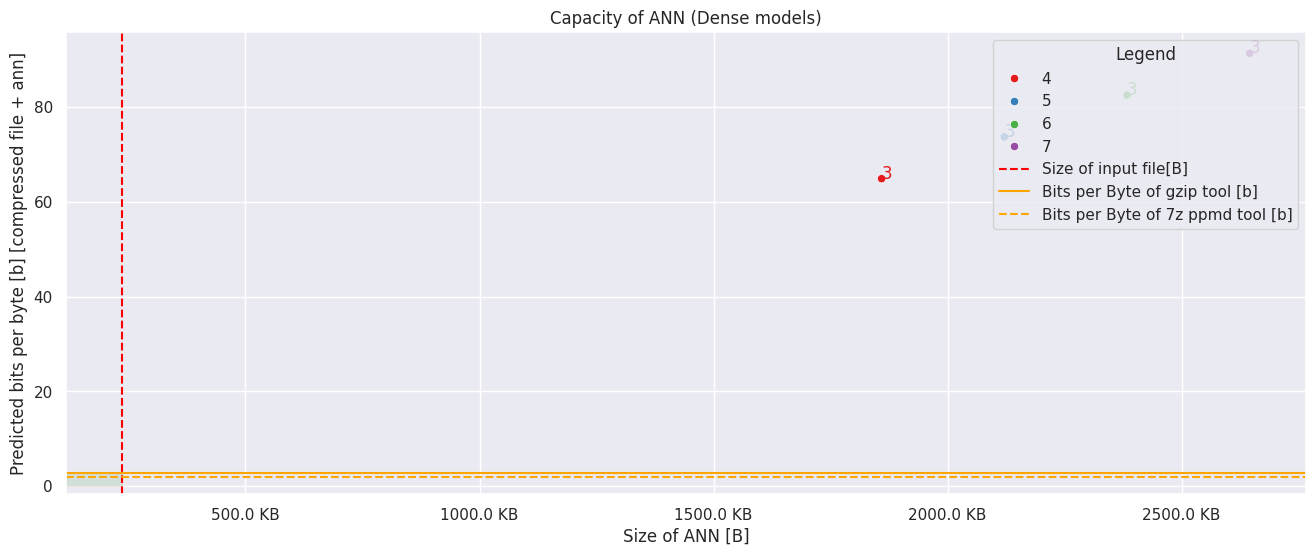

In [33]:
df = load_results([ r"./logs/heterogenous/DNN_k4.txt",  r"./logs/heterogenous/DNN_k5.txt",  r"./logs/heterogenous/DNN_k6.txt", r"./logs/heterogenous/DNN_k7.txt"])
input_file_size_in_bits = 1_897_672
gzip_bits_per_byte = 2.7408
sevenzip_bits_per_byte = 1.8932839816364473

plot_capacity_of_ann_only_model_size(df, input_file_size_in_bits, gzip_bits_per_byte, sevenzip_bits_per_byte)
plot_capacity_of_ann(df, input_file_size_in_bits, gzip_bits_per_byte, sevenzip_bits_per_byte, )
plot_capacity_of_ann_y_all(df, input_file_size_in_bits, gzip_bits_per_byte, sevenzip_bits_per_byte, )

# Notes

- porovnat (velikost modelu + predikovana velikost) s (velikosti vstupního souboru) a najít maximum.
    - ✅ -> 2 verze grafů, na ose x - Velikost ANN, Velikost ANN + Velikost výstupního souboru
- změnit parametr k
    - ✅ -> Vyzkoušeny hodnoty k - 0, 1, 2, 3, 4, 5, 6, 7
- změnit velikost vstupů na 1MB, 5MB, 10MB ✅
- přidat vizualizace loss funkce
    - ✅ -> Jen pro pár experimentů
- Přidat experimenty s rekurentními sítěmi ✅
- k = 0 - dávat náhodné vstupy
    - x z rovnomerneho rozdeleni
    - y z textu postupne.
    - ✅ -> Hotovo pro 1MB dat
- Zkusit zavolat gbc na konci epochy či batche. ✅
- k = 0 je nutné porovnat s entropii 0 řádu ✅
- Přenásobit bits per bits hodnotou 8 abych dostal bits per bytes. ✅ 
- Porovnat s výsledky komprimace 7z ppmd tool ✅
- Upravit osu Y - přičíst i velikost neuronky. ✅
- Rekurentni ANN ✅

- Další experiment až po první fázi
    - naučit na souoru X a predikovat na souboru Y ✅
 
- Attention vrstva experiment
- Siť pro predikci dle typu souboru

- Naučit na kombinaci obrázek text a predikovat na stejných. Očekává se zhoršní?
- 
- 

In [ ]:
# gzip lz77
# 7zip, ppmd 